In [388]:
DQL_MODEL = ("SELECT", "INNER JOIN", "LEFT JOIN", "RIGHT JOIN", "FULL OUTER JOIN", "WHERE", "GROUP BY", "HAVING", "ORDER BY")
SYNTAX_ELEMENT_COUNT_CAP = 10
REGULATION = 0.4
MAX_TASK_COUNT =50
LEARNER_COUNT = 5000

In [ ]:
import numpy as np

def calc_complexity(frequency):
    regulation = REGULATION
    if(frequency>=SYNTAX_ELEMENT_COUNT_CAP): return 1
    return ((frequency**(1 / regulation)) / (20 + (frequency**(1 / regulation))))

def calc_frequency(complexity):
    regulation = REGULATION
    if complexity >= 1:
        return SYNTAX_ELEMENT_COUNT_CAP
    if complexity <= 0:
        return 0
    x = (20 * complexity / (1 - complexity)) ** regulation
    if x > SYNTAX_ELEMENT_COUNT_CAP:
        return SYNTAX_ELEMENT_COUNT_CAP
    return round(x)

def rgbeta(n: int, min: float = 0, max: float = 1) -> float:

    x = np.random.beta(6,6, n)
    y = (max - min) * x

    return y.tolist()

def calc_potential_competency(competency, help):
    potential_competency = []
    for i in range(len(competency)):
        potential_competency.append(min(1.0, competency[i] + help[i]))
    return potential_competency

def calc_task(task_complexity):
    task = []
    for complexity in task_complexity:
        frequency = calc_frequency(complexity)
        real_complexity = calc_complexity(frequency)
        if(real_complexity > complexity): frequency -= 1
        task.append(frequency)
    return task

def create_complexity_in_approximate_range(a, b):
    complexity = []
    for i in range(len(DQL_MODEL)):
        ai = max(a[i]-0.15, 0)
        bi = min(b[i]+0.15, 1)
        complexity.append(np.random.uniform(ai, bi))
    return complexity
        
def create_random_task():
    task = []
    for i in range(len(DQL_MODEL)):
        frequency = np.random.randint(0, SYNTAX_ELEMENT_COUNT_CAP)
        task.append(frequency)
    return task

def create_random_complexity():
    return np.random.uniform(0, 1, len(DQL_MODEL)).tolist()

def calc_task_complexity(task):
    task_complexity = []
    for frequency in task:
        complexity = calc_complexity(frequency)
        task_complexity.append(complexity)
    return task_complexity

def calc_delta(competency, potential_competency, task_complexity):
    delta = []
    for i in range(len(DQL_MODEL)):
        if task_complexity[i] <= competency[i]:
            delta.append(0)
        elif task_complexity[i] > potential_competency[i]:
            delta.append(0)
        else:
            delta.append(task_complexity[i] - competency[i])
    return delta

def add_delta_to_competency(competency, delta):
    new_competency = []
    for i in range(len(competency)):
        new_competency.append(min(1.0, competency[i] + delta[i]))
    return new_competency

In [390]:
def sample_competencies():
    competencies = []
    for i in range(LEARNER_COUNT):
        competency = rgbeta(len(DQL_MODEL))
        competencies.append(competency)
    return competencies

def sample_help():
    help = []
    for i in range(LEARNER_COUNT):
        learner_help = []
        for j in range(MAX_TASK_COUNT):
            learner_help.append(rgbeta(len(DQL_MODEL), 0, 0.2))
        help.append(learner_help)
    return help

def create_learner_population():
    population = {
        "competencies": sample_competencies(),
        "help": sample_help(),
    }
    return population

In [408]:
def plot_one_log_item(log, index):
    item = log[index]    
    
    competency = item["competency"]
    potential_competency = item["potential_competency"]
    task_complexity = item["real_task_complexity"]
    
    avg_competencies = []
    avg_potential_competencies = []
    avg_task_complexities = []
    
    for i in range(MAX_TASK_COUNT):
        avg_competency = np.mean(competency[i])
        avg_potential_competency = np.mean(potential_competency[i])
        avg_task_complexity = np.mean(task_complexity[i])
        avg_competencies.append(avg_competency)
        avg_potential_competencies.append(avg_potential_competency)
        avg_task_complexities.append(avg_task_complexity)
        
    print(f"Competency: {avg_competencies}")
    print(f"Potential Competency: {avg_potential_competencies}")
    print(f"Task Complexity: {avg_task_complexities}")
    
    import matplotlib.pyplot as plt
        
    # Create a figure and axis
    plt.figure(figsize=(12, 7), dpi=300)
        
    # Plot the average values over tasks
    plt.plot(range(MAX_TASK_COUNT), avg_competencies, label='Tatsächliches Kompetenzniveau', color='blue')
    plt.plot(range(MAX_TASK_COUNT), avg_potential_competencies, label='Potentielles Kompetenzniveau', color='green')
    plt.plot(range(MAX_TASK_COUNT), avg_task_complexities, label='Aufgabenkomplexität', color='red')
    
    # Add labels and title
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Aufgabe zum Zeitpunkt t')
    plt.ylabel('Aufgabenkomplexität / Kompetenzniveau')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
        
    # Display the plot
    plt.tight_layout()
    plt.show()


def plot_average_over_all_learners(log):
    # Initialize arrays to store the average values for all learners
    avg_competencies_all = np.zeros(MAX_TASK_COUNT)
    avg_potential_competencies_all = np.zeros(MAX_TASK_COUNT)
    avg_task_complexities_all = np.zeros(MAX_TASK_COUNT)
    
    # Calculate the average over all learners for each task
    for learner_idx in range(len(log)):
        competency = log[learner_idx]["competency"]
        potential_competency = log[learner_idx]["potential_competency"]
        task_complexity = log[learner_idx]["real_task_complexity"]
        
        for task_idx in range(MAX_TASK_COUNT):
            avg_competencies_all[task_idx] += np.mean(competency[task_idx]) / len(log)
            avg_potential_competencies_all[task_idx] += np.mean(potential_competency[task_idx]) / len(log)
            avg_task_complexities_all[task_idx] += np.mean(task_complexity[task_idx]) / len(log)
    
    import matplotlib.pyplot as plt
    
    # Create a figure and axis
    plt.figure(figsize=(12, 7), dpi=300)
    
    # Plot the average values over all learners
    plt.plot(range(MAX_TASK_COUNT), avg_competencies_all, 
             label='Durchschnittliches tatsächliches Kompetenzniveau', color='blue')
    plt.plot(range(MAX_TASK_COUNT), avg_potential_competencies_all, 
             label='Durchschnittliches potentielles Kompetenzniveau', color='green')
    plt.plot(range(MAX_TASK_COUNT), avg_task_complexities_all, 
             label='Durchschnittliche Aufgabenkomplexität', color='red')
    
    # Add labels and title
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Aufgabe zum Zeitpunkt t')
    plt.ylabel('Durchschnittliche Aufgabenkomplexität / Kompetenzniveau')
    plt.title('Durchschnitt über alle Lernenden')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Display the plot
    plt.tight_layout()
    plt.show()
    
def plot_one_element(log, index, element_index):
    item = log[index]
    
    # Extract data for the specific element
    competencies = [comp[element_index] for comp in item["competency"]]
    potential_competencies = [pot[element_index] for pot in item["potential_competency"]]
    task_complexities = [task[element_index] for task in item["real_task_complexity"]]
    
    import matplotlib.pyplot as plt
    
    # Create a figure and axis
    plt.figure(figsize=(12, 7), dpi=300)
    
    # Plot the values over tasks
    plt.plot(range(MAX_TASK_COUNT), competencies, label='Tatsächliches Kompetenzniveau', color='blue', marker='o', markersize=4)
    plt.plot(range(MAX_TASK_COUNT), potential_competencies, label='Potentielles Kompetenzniveau', color='green', marker='o', markersize=4, linestyle='--')
    plt.plot(range(MAX_TASK_COUNT), task_complexities, label='Aufgabenkomplexität', color='red', marker='s', markersize=4, linestyle='None')
    
    # Add labels and title
    plt.ylim(0, 1.1)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('Aufgabe zum Zeitpunkt t')
    plt.ylabel('Aufgabenkomplexität / Kompetenzniveau')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    
    # Display the plot
    plt.tight_layout()
    plt.show()

In [ ]:
learner_population = create_learner_population()

log = [{
    "task": [],
    "real_task_complexity": [],
    "competency": [],
    "potential_competency": [],
    "help": [],
    "deltas": []
} for _ in range(LEARNER_COUNT)]

for i in range(LEARNER_COUNT):
    help = learner_population["help"][i]
    for j in range(MAX_TASK_COUNT):
        learner_competency = learner_population["competencies"][i]
        task_help = help[j]
        potential_competency = calc_potential_competency(learner_competency, task_help)
        real_task_complexity = create_complexity_in_approximate_range(learner_competency, potential_competency)
        # real_task_complexity = create_random_complexity()
        
        # random_task_complexity = create_random_complexity()
        delta = calc_delta(learner_competency, potential_competency, real_task_complexity)
        
        # log[i]["task"].append(task)
        log[i]["real_task_complexity"].append(real_task_complexity)
        log[i]["competency"].append(learner_competency)
        log[i]["potential_competency"].append(potential_competency)
        log[i]["help"].append(task_help)
        log[i]["deltas"].append(delta)
        
        new_competency = add_delta_to_competency(learner_competency, delta)
        learner_population["competencies"][i] = new_competency
        if(i == 0 and j == 0):
            print("### Example ###")
            print("Learner Competency: ", learner_competency)
            print("Learner Help: ", task_help)
            print("Optimal Task Complexity / potential competency: ", potential_competency)
            # print("Optimal Task: ", task)
            print("Real Task Complexity: ", real_task_complexity)
            print("Delta: ", delta)     
            print("New Competency: ", new_competency)
            
            
records = []
order_id = 1
problem_id = 1

# Iterate through each student 
for studentId in range(len(log)):
    for taskIndex in range(MAX_TASK_COUNT):
        for skill_position in range(len(DQL_MODEL)):
            delta = log[studentId]["deltas"][taskIndex][skill_position]
            record = {
                'order_id': f'{order_id:08d}',
                'user_id': f'{studentId+1:06d}',
                'sequence_id': f'{studentId+1:06d}',
                'skill_id': skill_position,
                'problem_id': f'{problem_id:08d}',
                'correct': 1 if delta > 0 else 0
            }
            records.append(record)
            order_id += 1  
        problem_id += 1
        

### Example ###
Learner Competency:  [0.4174927034436701, 0.5365994064247309, 0.575843312740157, 0.36778119444904717, 0.3742792098629408, 0.6739043436067286, 0.6558296974221737, 0.4439378670238004, 0.3407263262904843]
Learner Help:  [0.06357176375582956, 0.12138108240363941, 0.1163960349308111, 0.12696591313951938, 0.09077103534753266, 0.05315391173642242, 0.12952546774405135, 0.12660305625638715, 0.11713932866728782]
Optimal Task Complexity / potential competency:  [0.4810644671994997, 0.6579804888283703, 0.6922393476709681, 0.49474710758856655, 0.46505024521047345, 0.727058255343151, 0.785355165166225, 0.5705409232801876, 0.45786565495777215]
Real Task Complexity:  [0.443194489954932, 0.4708264544439345, 0.644018185562722, 0.3820924249685019, 0.47335963637818085, 0.5518510399454001, 0.8228547073033923, 0.503691918868163, 0.21318872698616015]
Delta:  [0.02570178651126187, 0, 0.06817487282256496, 0.01431123051945471, 0, 0, 0, 0.05975405184436261, 0]
New Competency:  [0.443194489954932,

In [393]:
import pandas as pd

df = pd.DataFrame(records)
df.to_csv('simulation_dataset.csv', index=False, sep=',')

Competency: [np.float64(0.48737711791819255), np.float64(0.5060373336623752), np.float64(0.5154226602667831), np.float64(0.5256528400885468), np.float64(0.556192265291259), np.float64(0.5614365930296643), np.float64(0.5893435755200227), np.float64(0.5973918587105433), np.float64(0.6143441140174767), np.float64(0.65679214241243), np.float64(0.6652722807189494), np.float64(0.6826110613097136), np.float64(0.7145013096812788), np.float64(0.7158977851422157), np.float64(0.7261067603338262), np.float64(0.7632411318042149), np.float64(0.7702237380327461), np.float64(0.7702237380327461), np.float64(0.7791553765907575), np.float64(0.7981544131749101), np.float64(0.8140593220503038), np.float64(0.8225407796997558), np.float64(0.8310680250559653), np.float64(0.845136248017186), np.float64(0.87499306394156), np.float64(0.9007055680611386), np.float64(0.9019451514945465), np.float64(0.9019451514945465), np.float64(0.9102767607315003), np.float64(0.9189768551285433), np.float64(0.9219438349094047), 

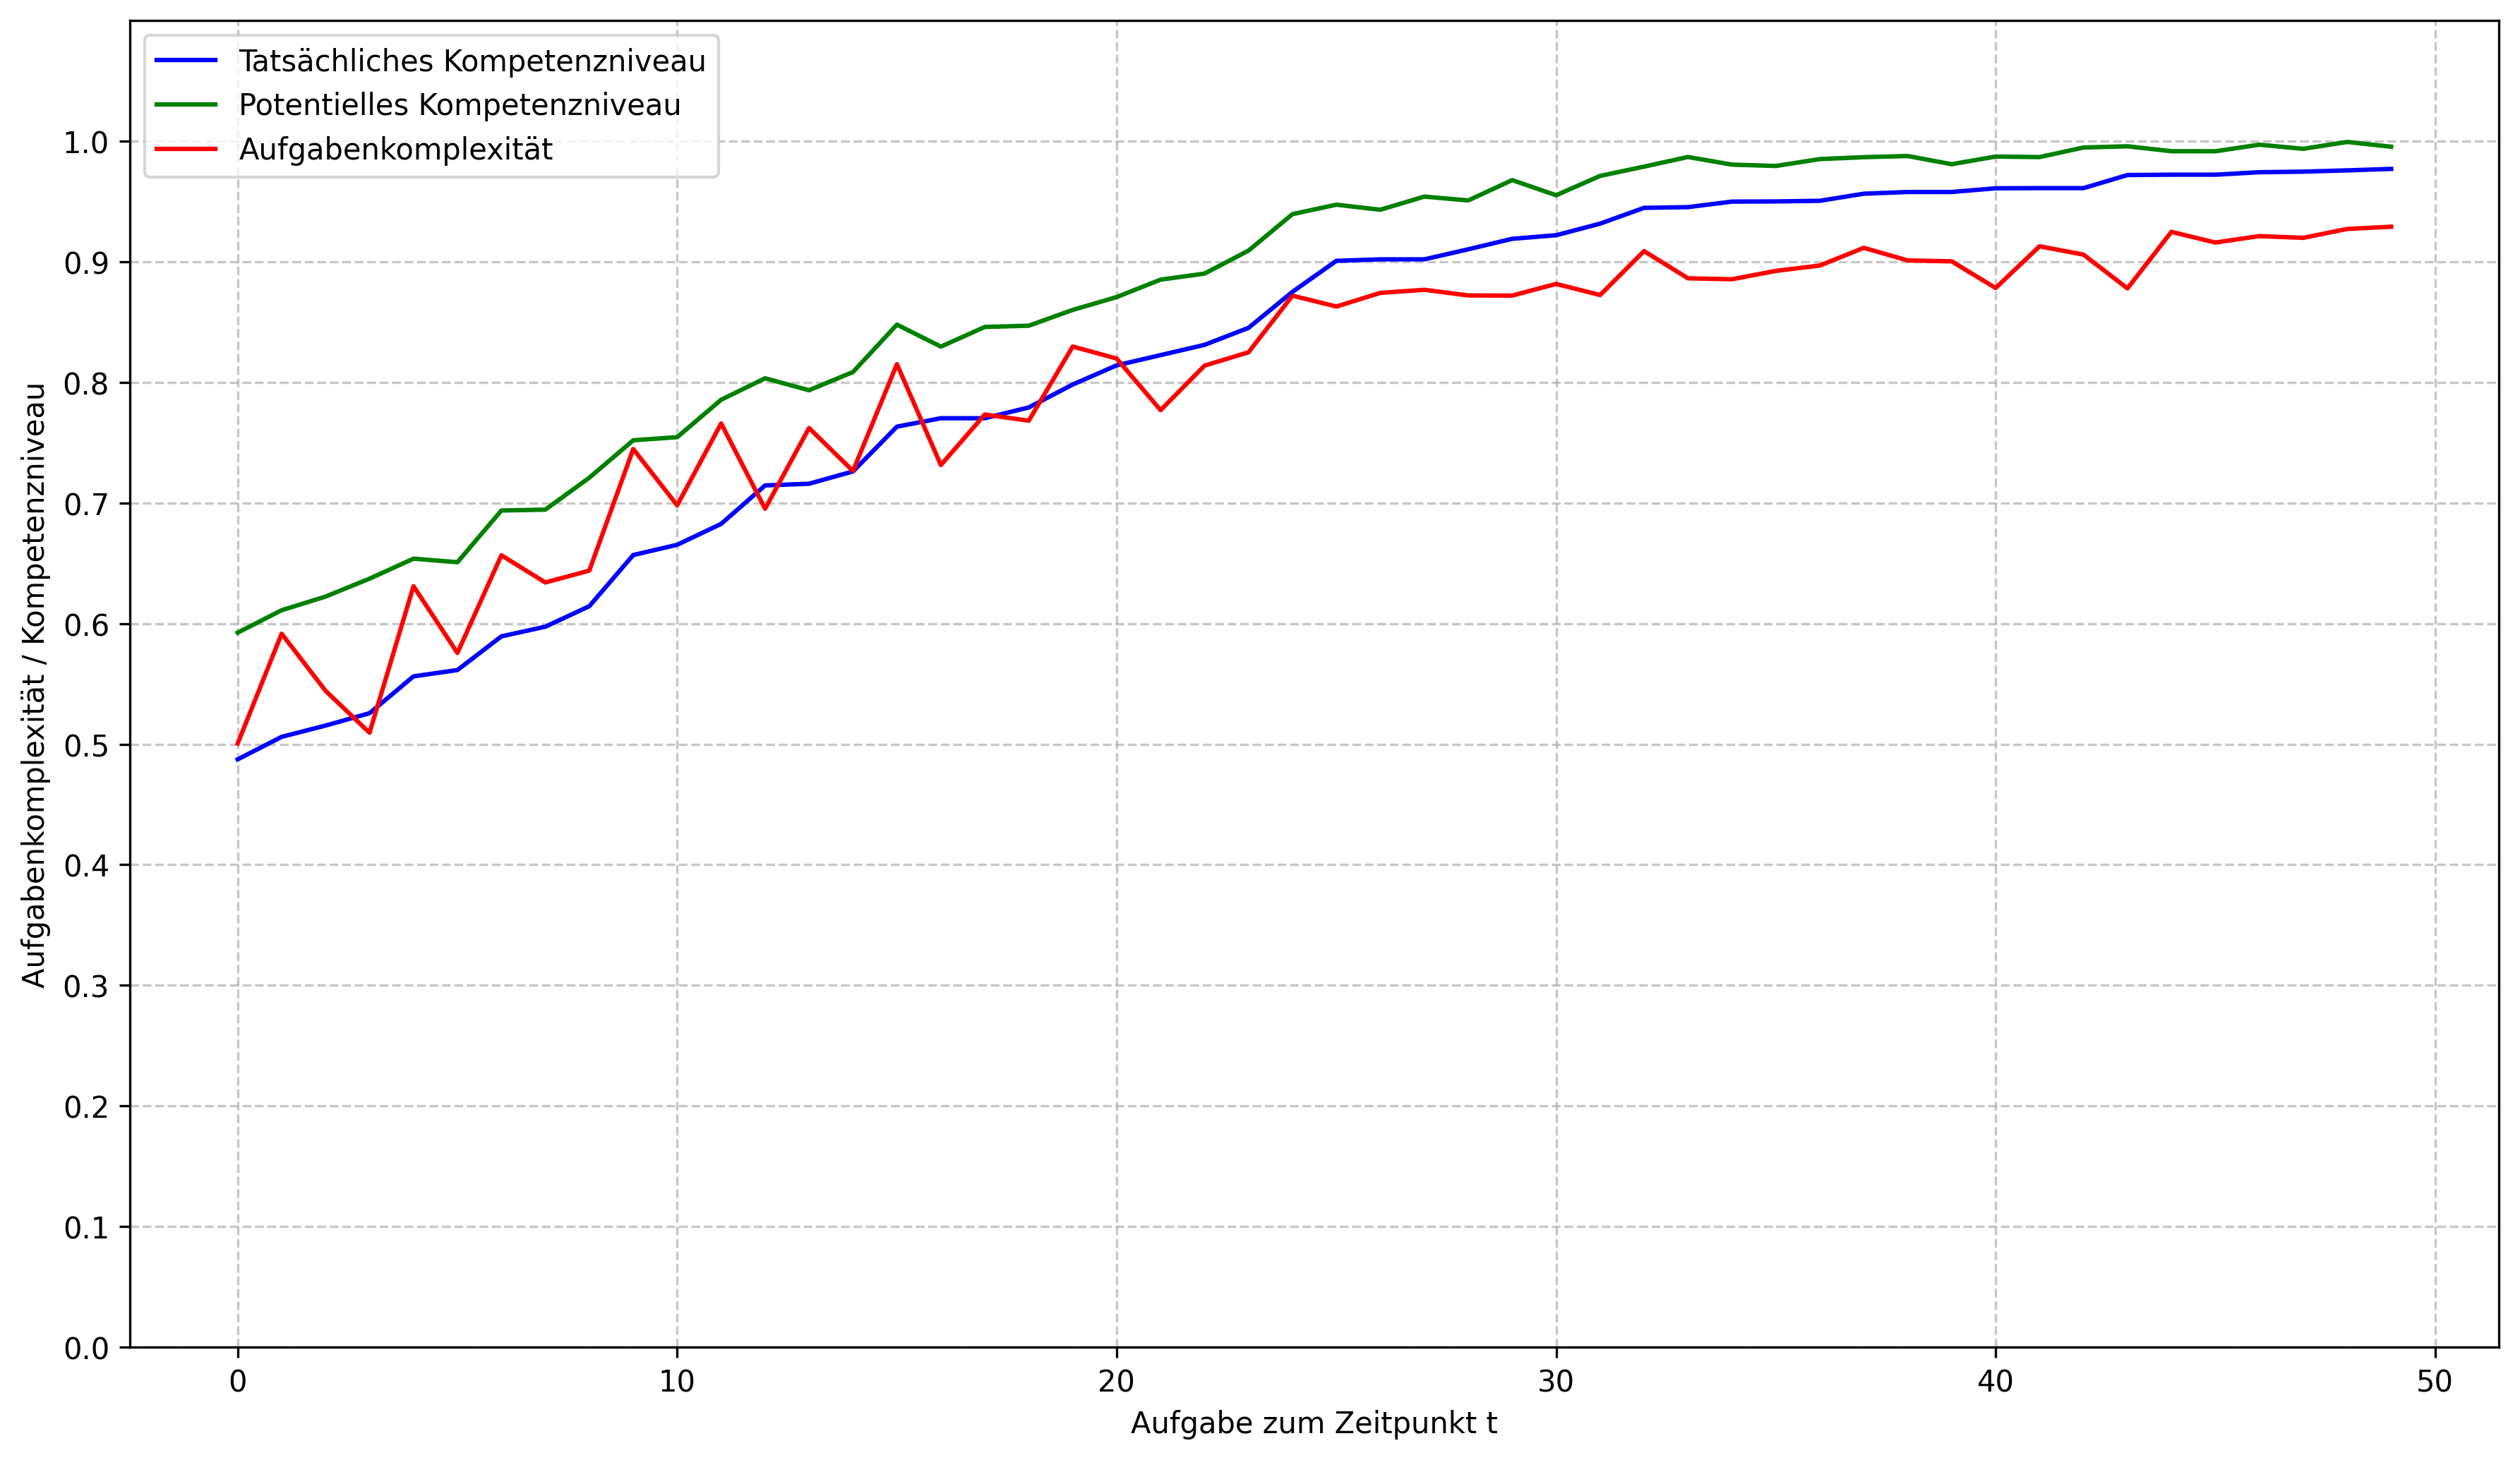

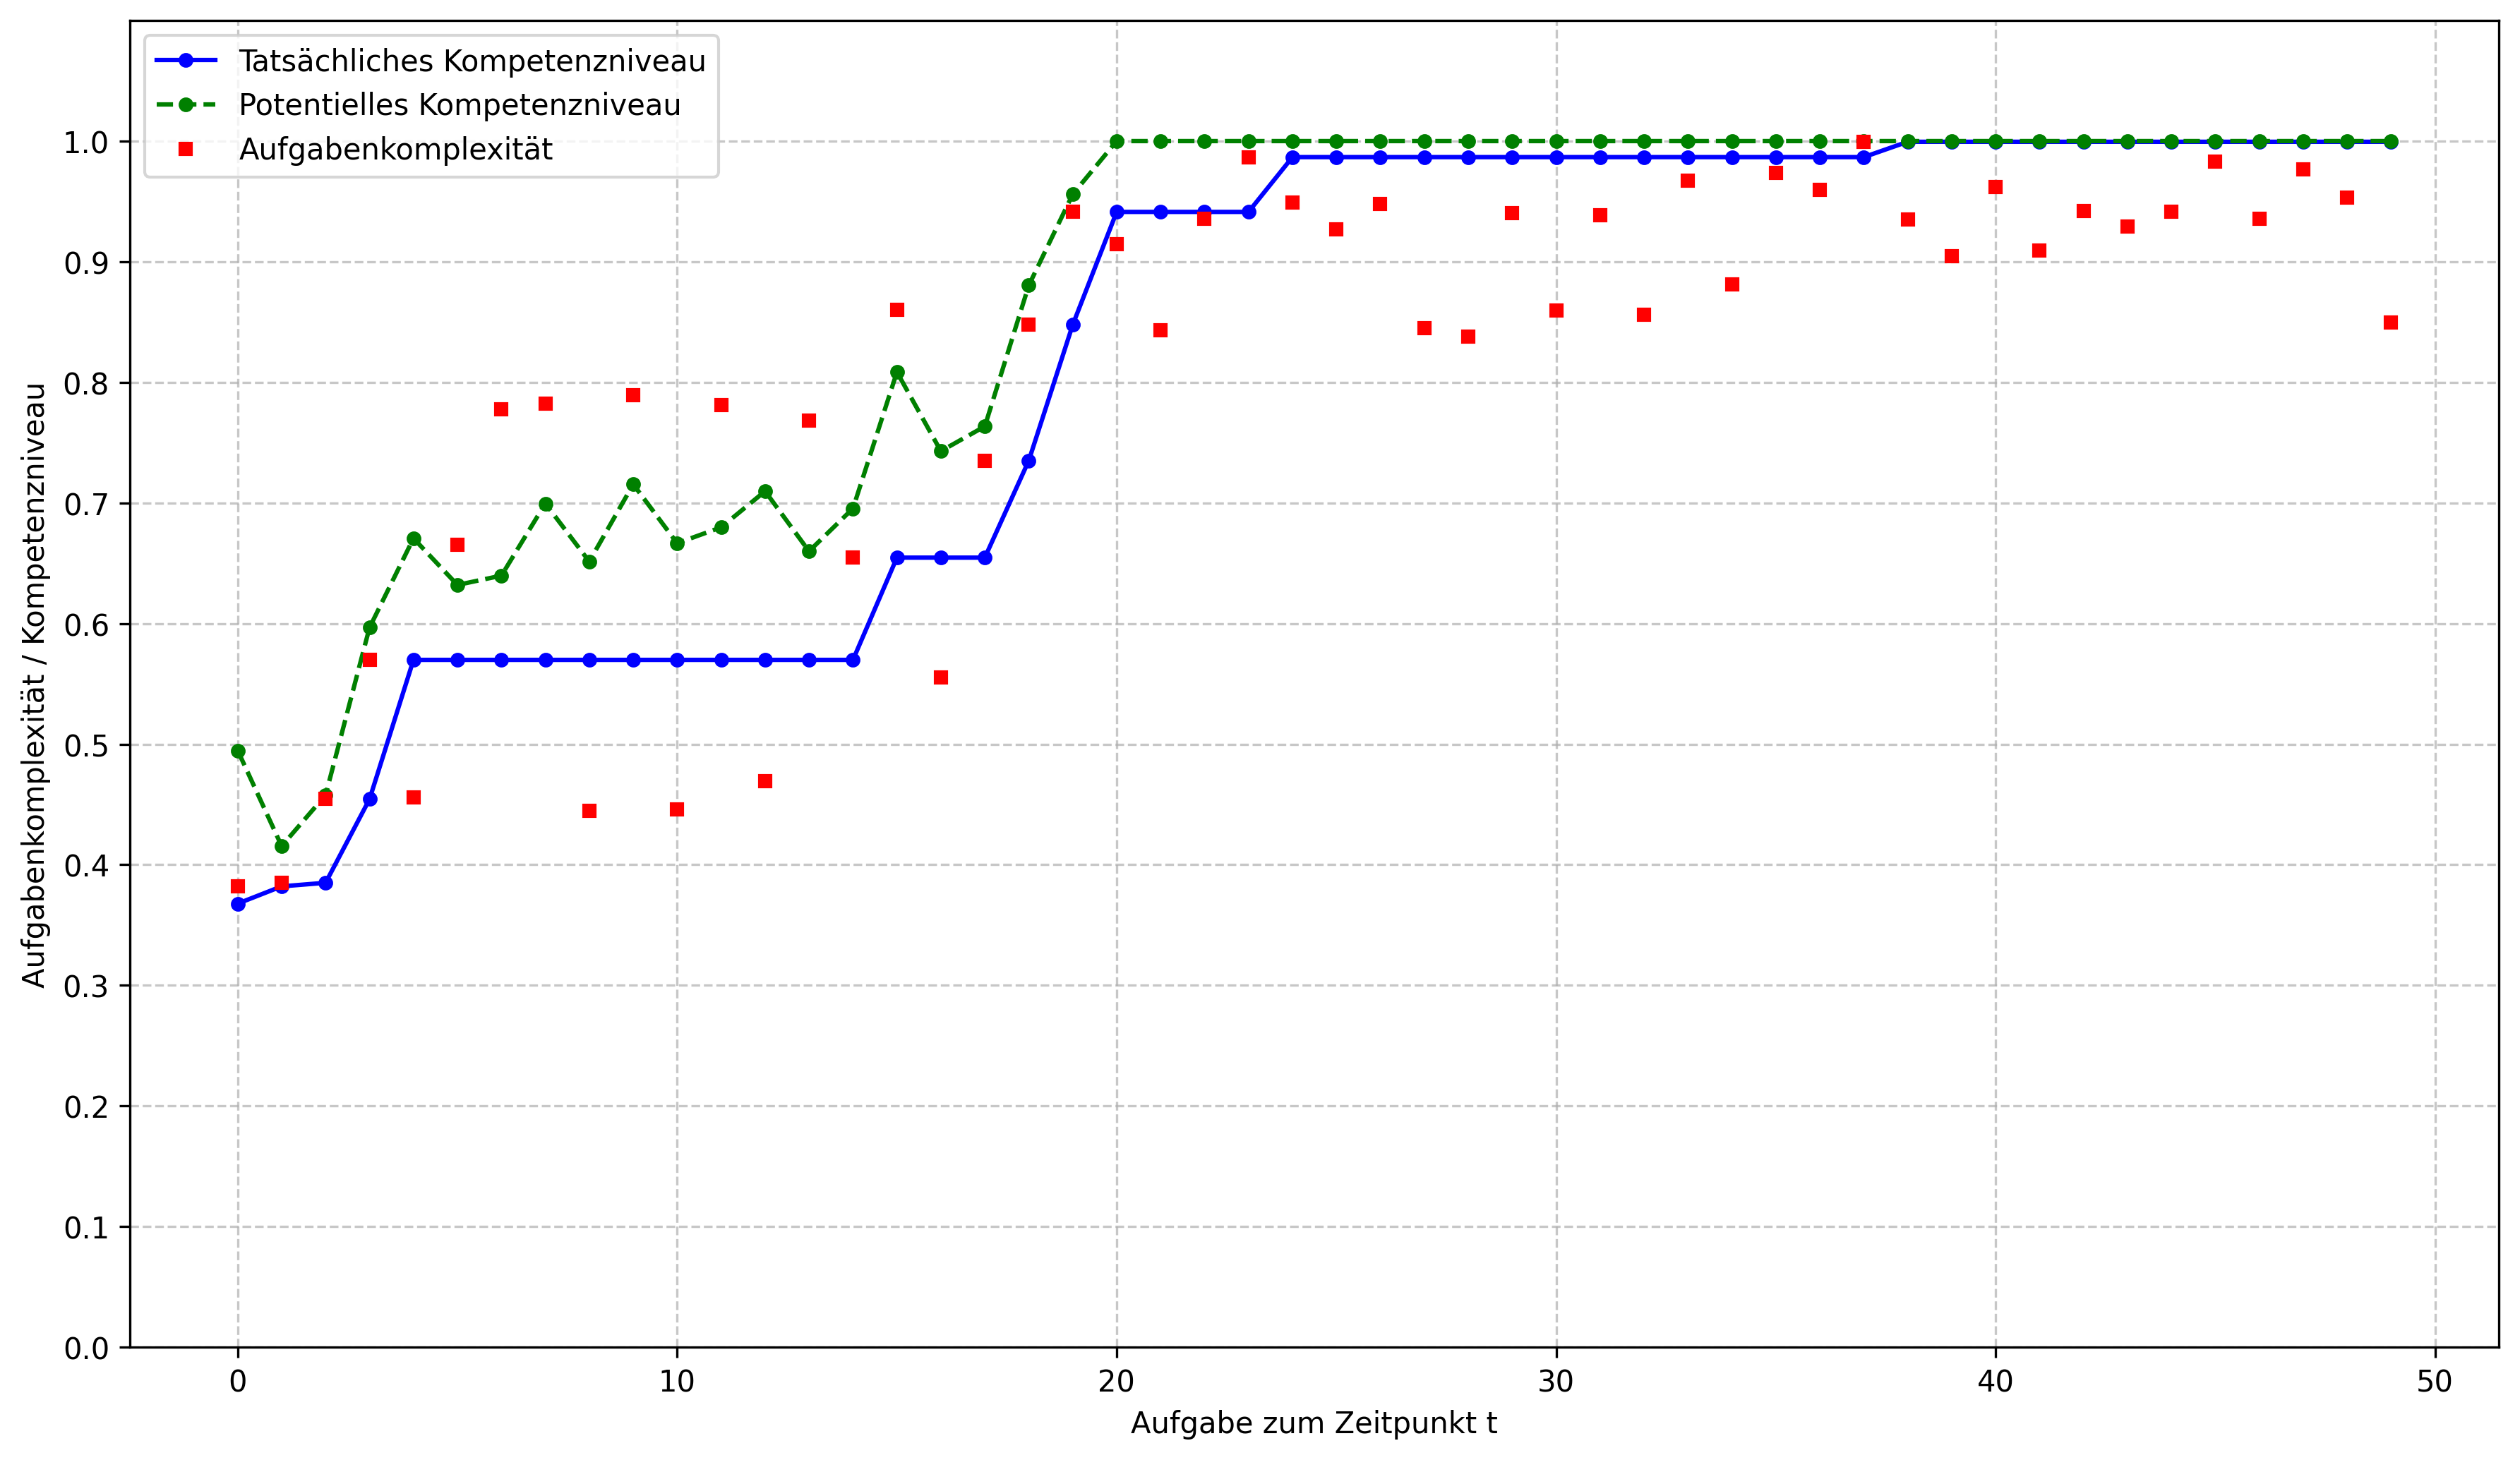

Competency: [np.float64(0.6173000932936075), np.float64(0.6330488284292699), np.float64(0.6664765105231873), np.float64(0.6973706395297807), np.float64(0.7142446244680943), np.float64(0.7320714710825516), np.float64(0.7348500042709036), np.float64(0.7364398731044935), np.float64(0.7490274594049935), np.float64(0.7543575907629374), np.float64(0.7688285887655327), np.float64(0.7888163258791935), np.float64(0.809545685890365), np.float64(0.8141109314721667), np.float64(0.8159626414625407), np.float64(0.8180757200577549), np.float64(0.8195613859281845), np.float64(0.8262517493339742), np.float64(0.8262517493339742), np.float64(0.8354239944395172), np.float64(0.842103695895791), np.float64(0.842103695895791), np.float64(0.8435900433892907), np.float64(0.844491524292152), np.float64(0.8654670247136672), np.float64(0.8705872427652911), np.float64(0.8908140276104288), np.float64(0.8964282140494849), np.float64(0.8974914563663532), np.float64(0.8974914563663532), np.float64(0.9111272309495294),

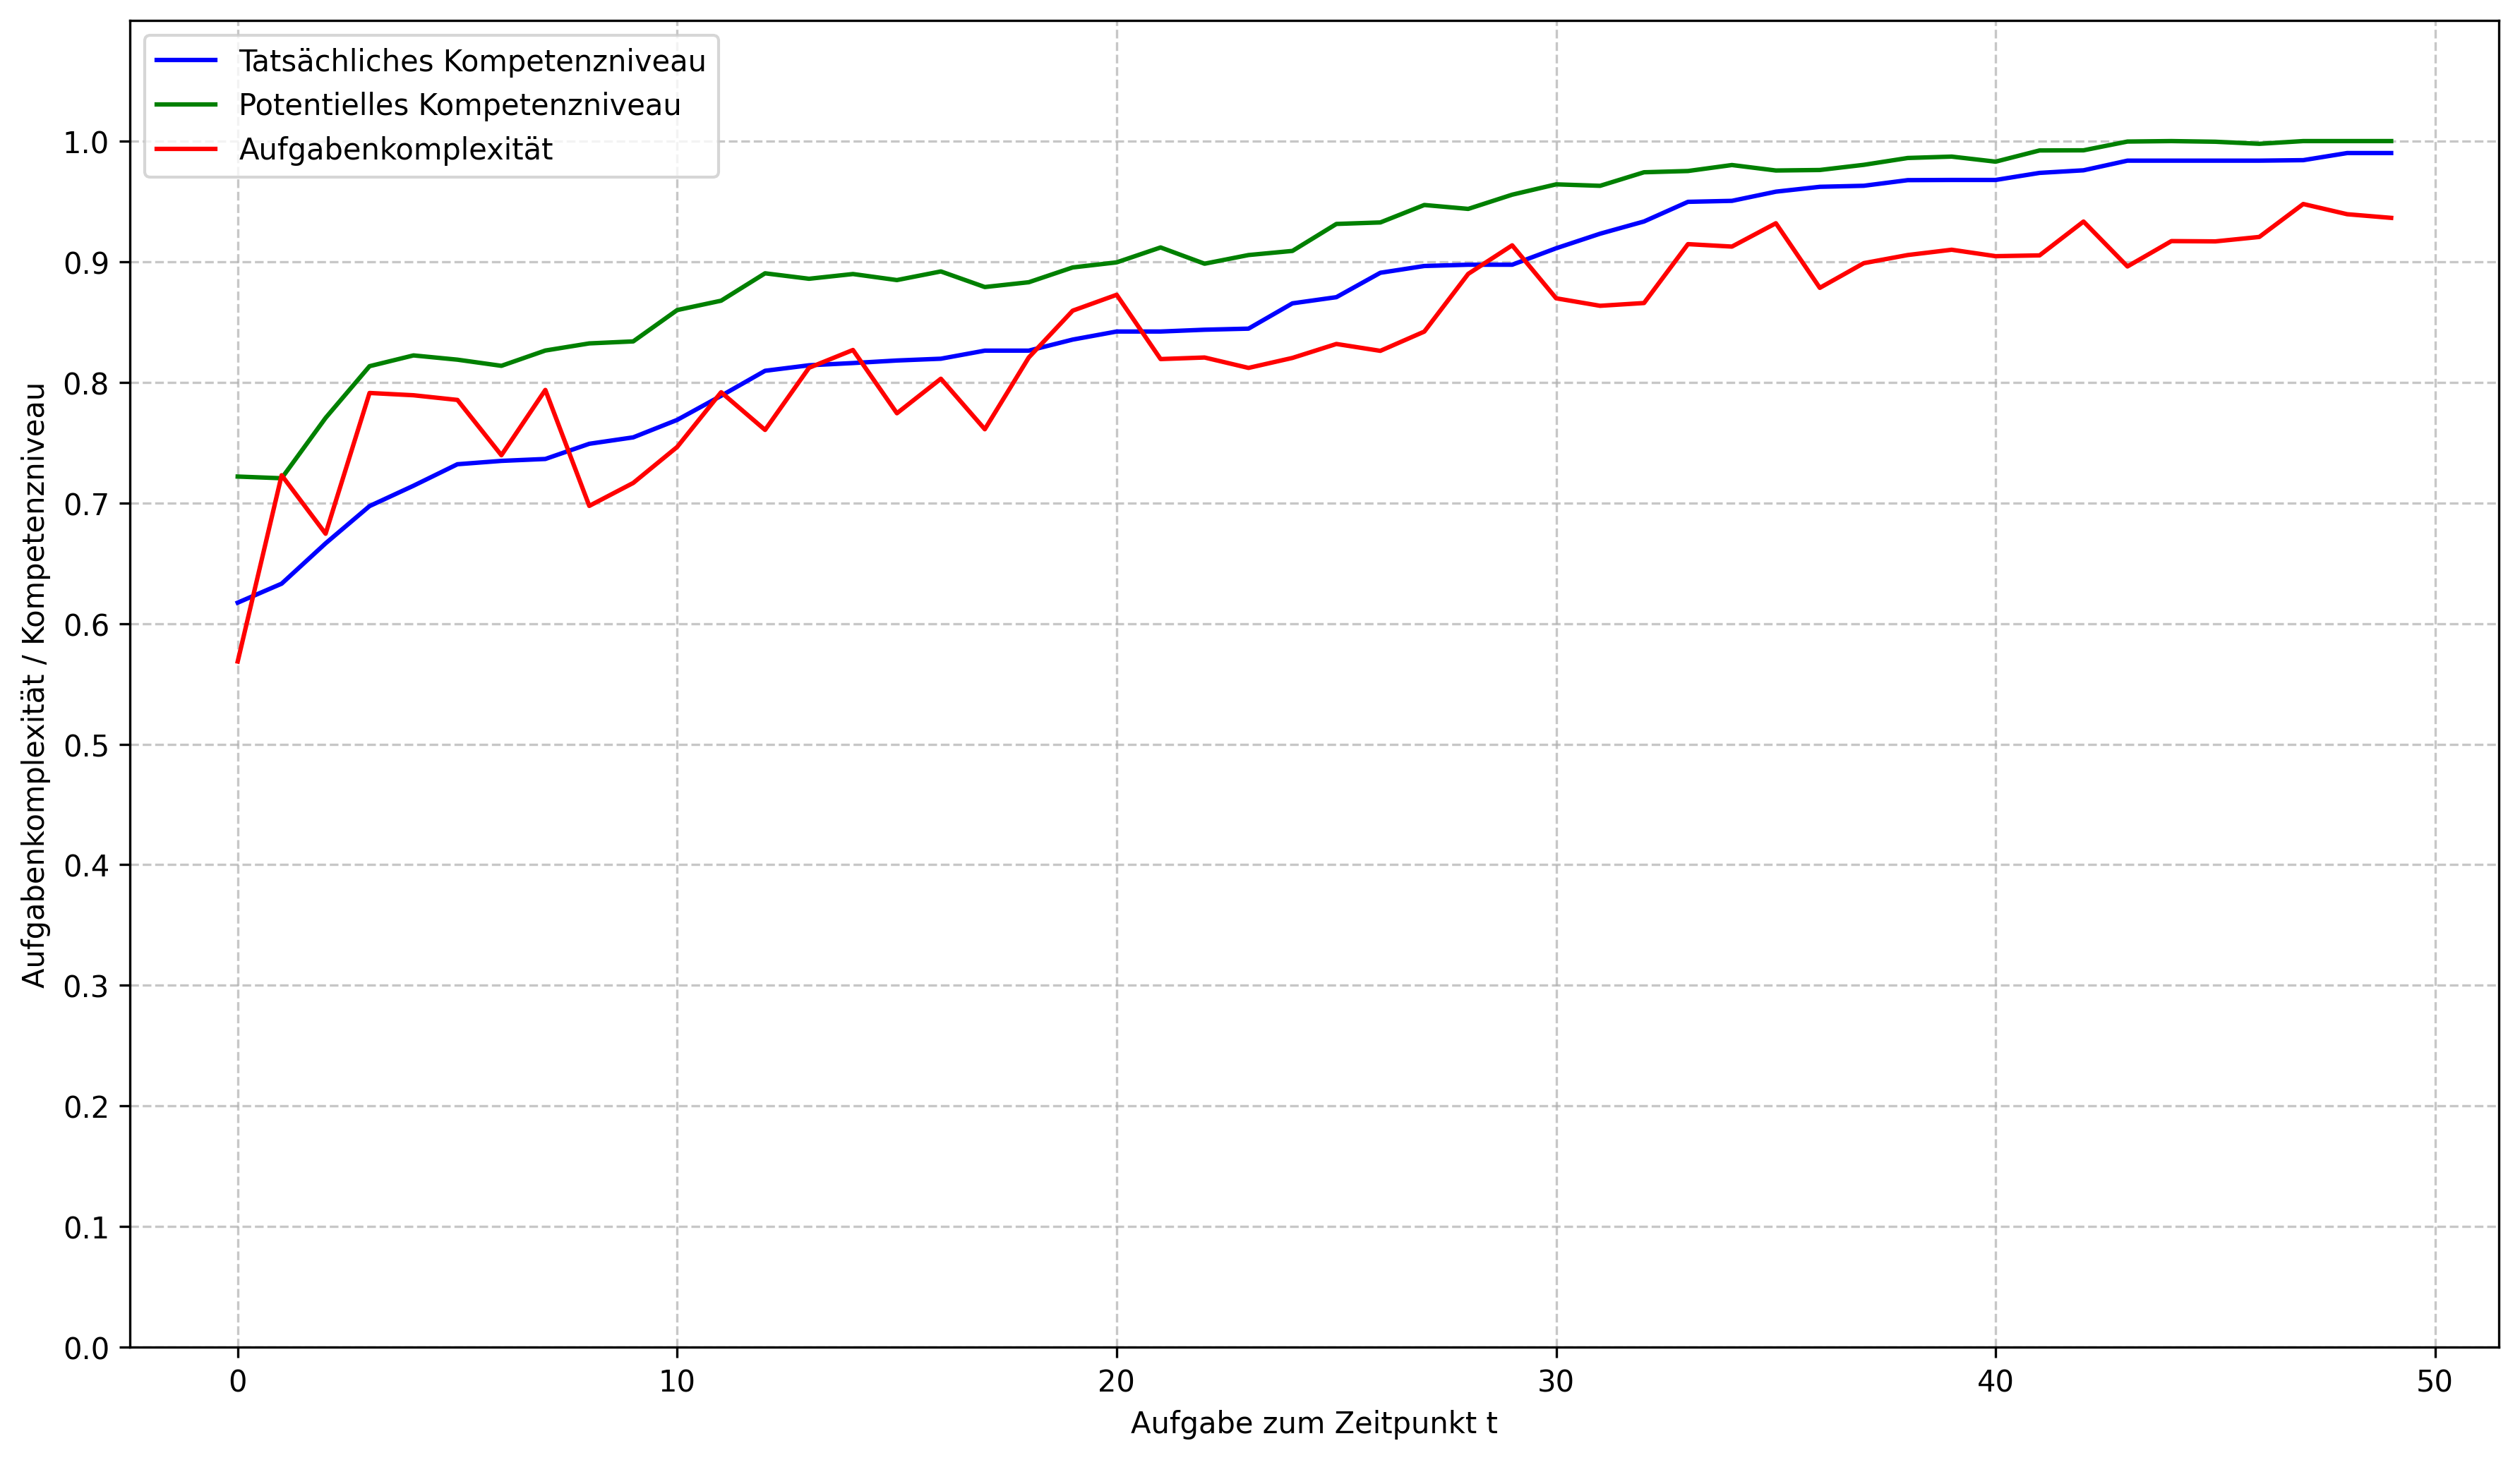

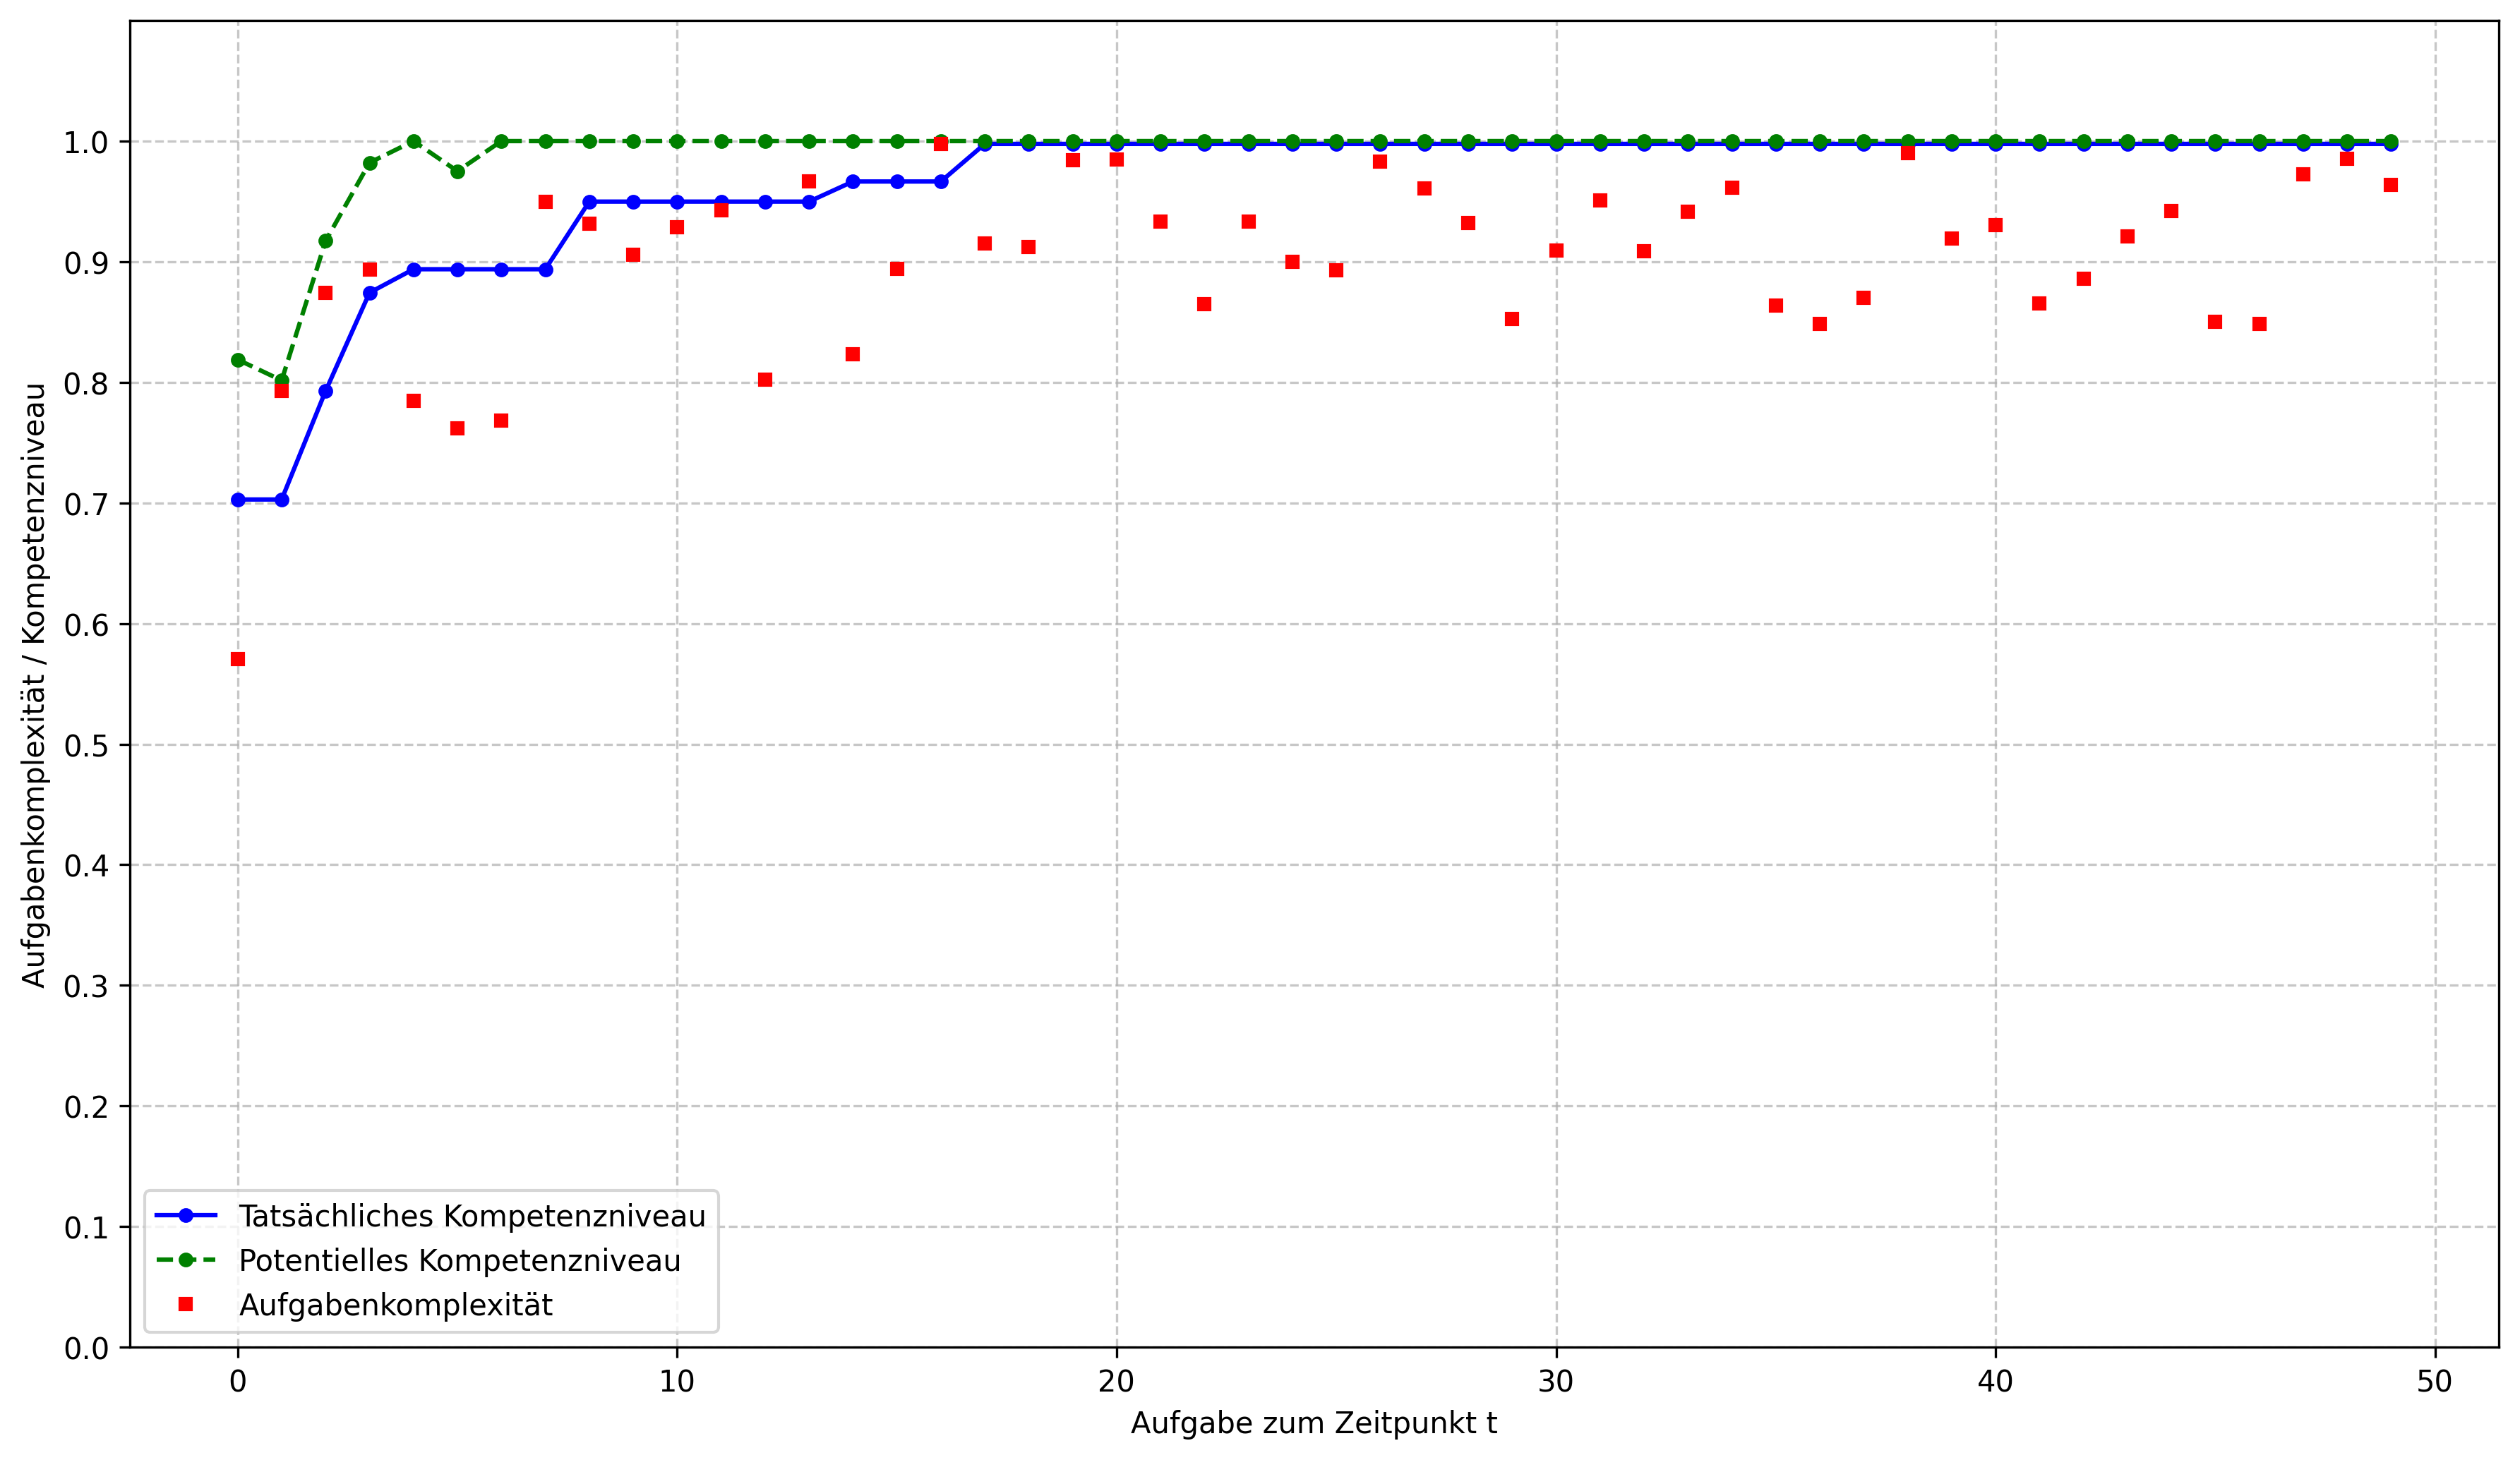

Competency: [np.float64(0.4143439845745071), np.float64(0.44214918451603274), np.float64(0.4433080551229148), np.float64(0.4562857510819621), np.float64(0.47174091407868635), np.float64(0.4835777747546708), np.float64(0.4904060312645464), np.float64(0.49668777137523956), np.float64(0.4989381766234844), np.float64(0.510389100602344), np.float64(0.5159447444773588), np.float64(0.5483450861778455), np.float64(0.5612728145850174), np.float64(0.5725803749173974), np.float64(0.5955451651955076), np.float64(0.6110056851768717), np.float64(0.6148889065415064), np.float64(0.6279763779090602), np.float64(0.6378947264004082), np.float64(0.6393390277894997), np.float64(0.6770667481771641), np.float64(0.6875766902796052), np.float64(0.6948875463334746), np.float64(0.7011412530626232), np.float64(0.7293161259012437), np.float64(0.7374920345554563), np.float64(0.7710233042168032), np.float64(0.7719951052114031), np.float64(0.7756361748859741), np.float64(0.792911331235278), np.float64(0.8172401028009

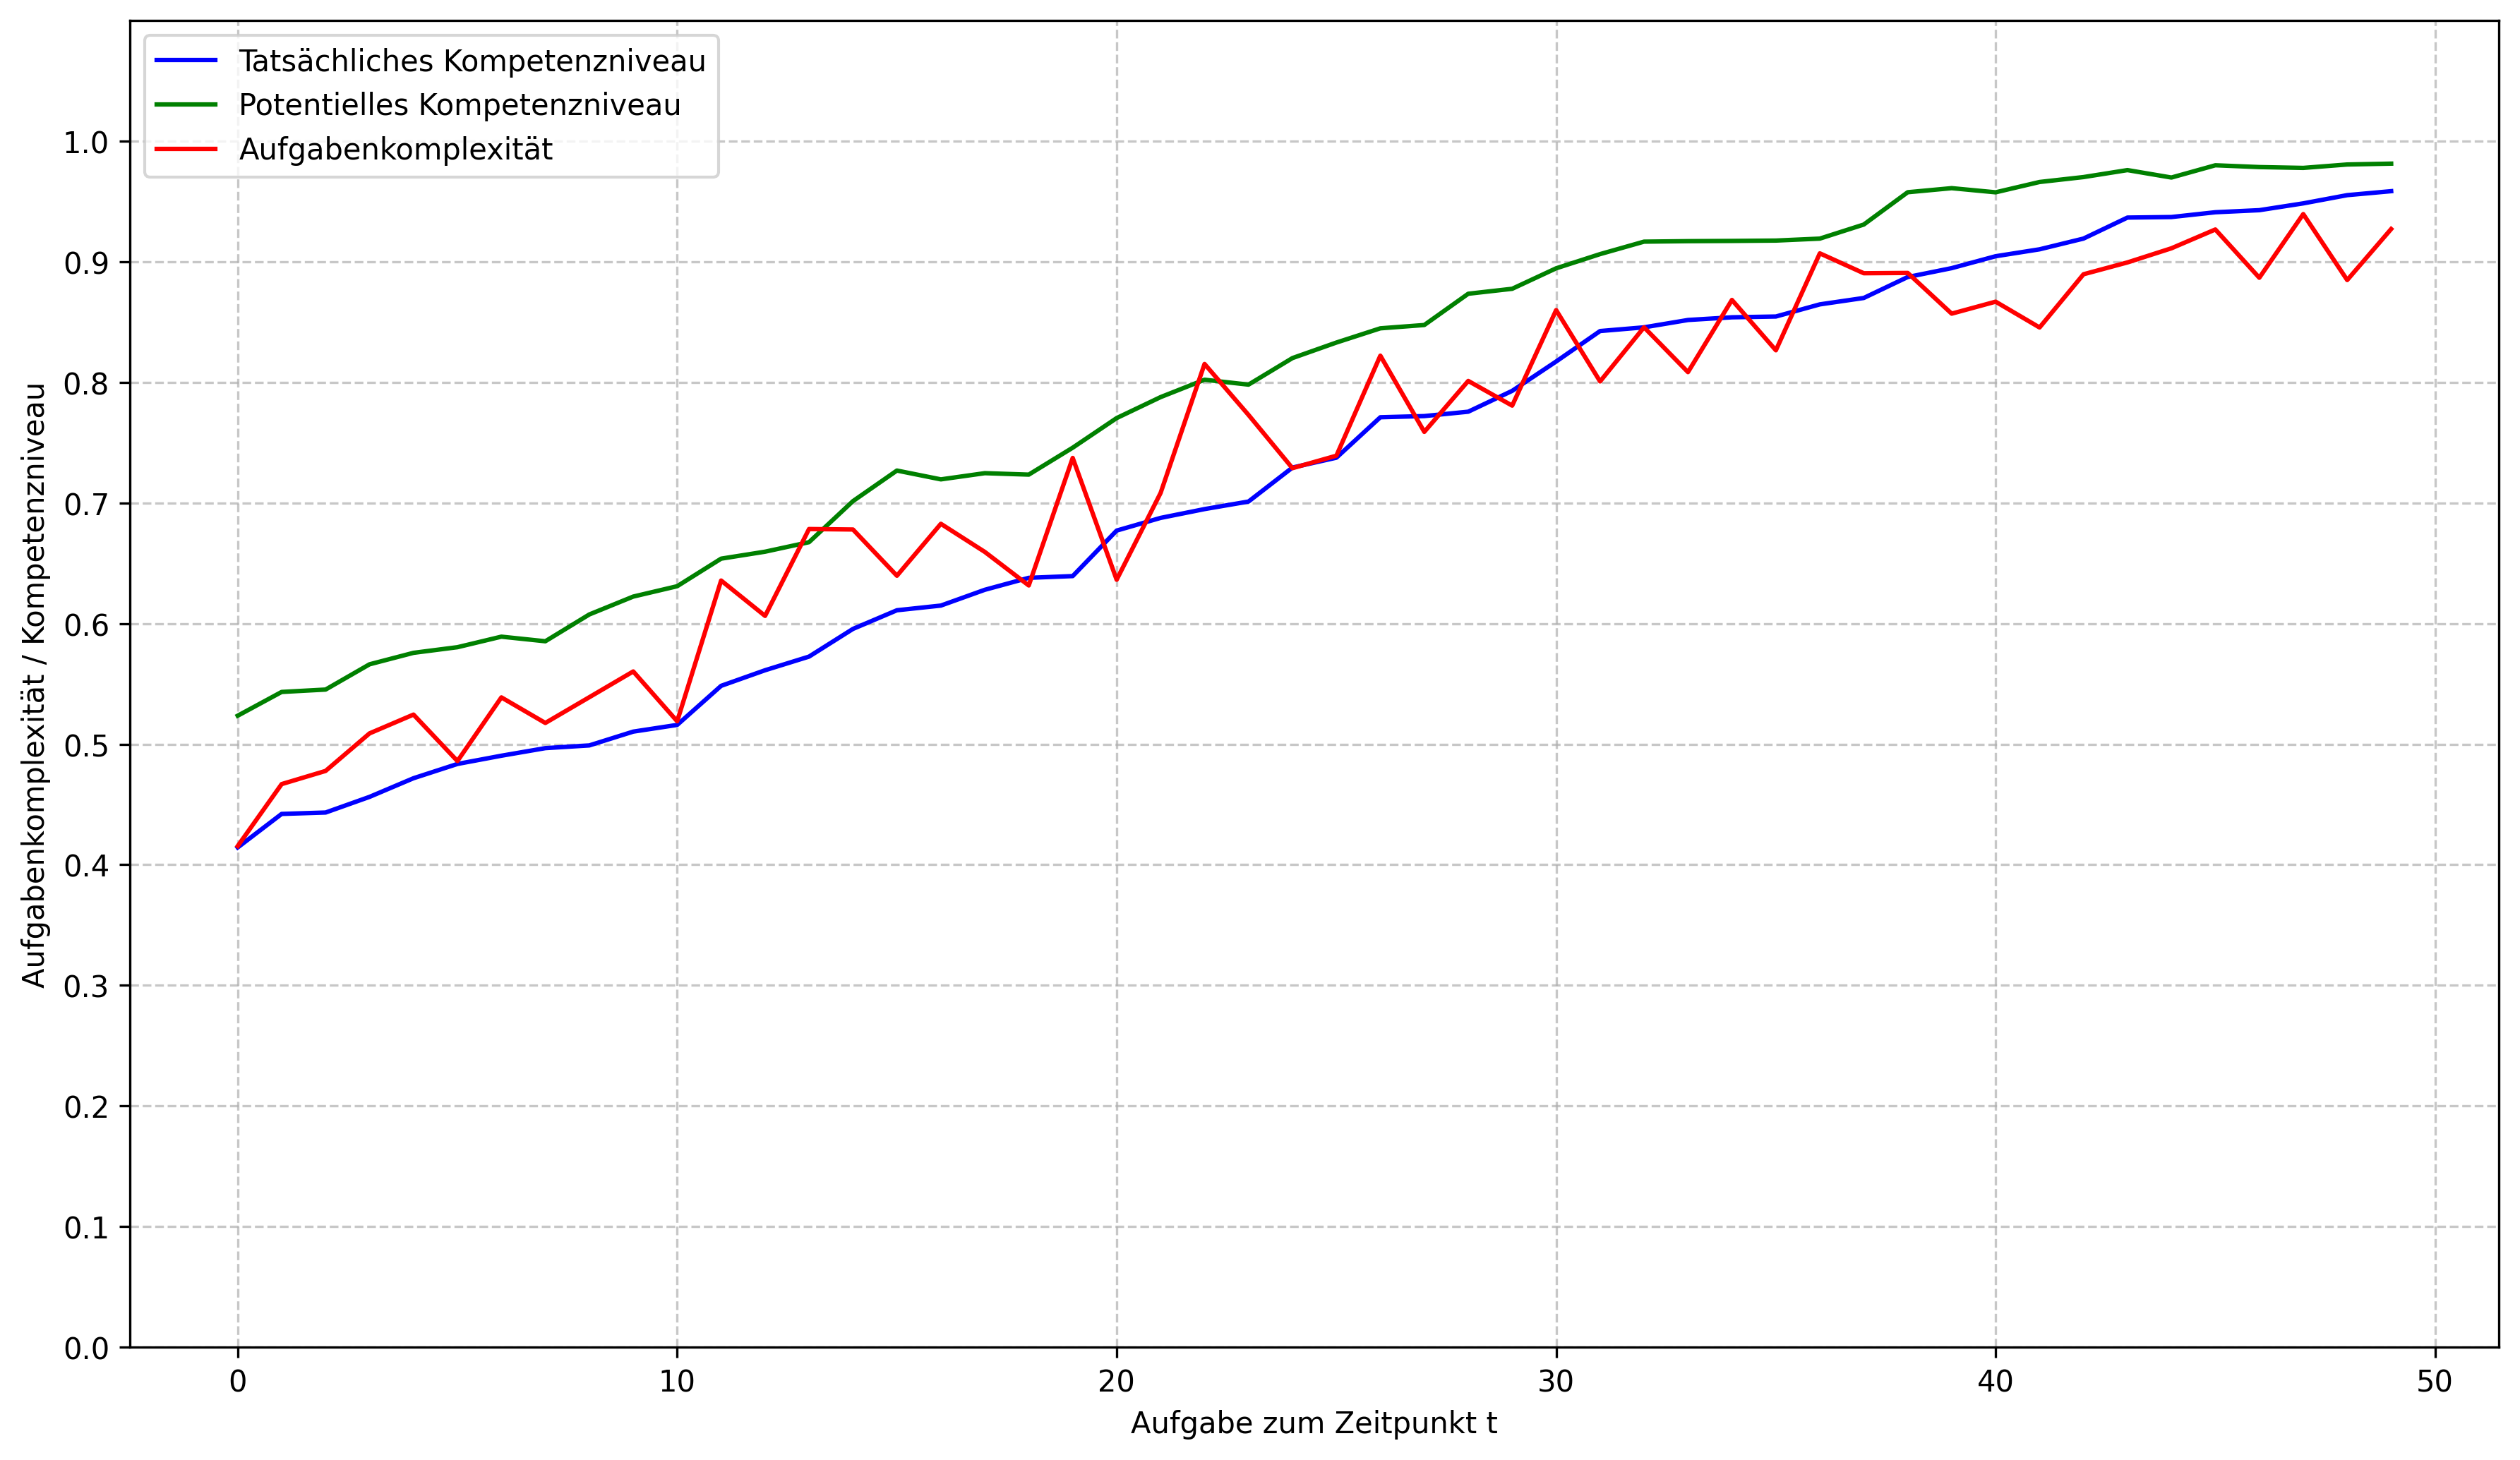

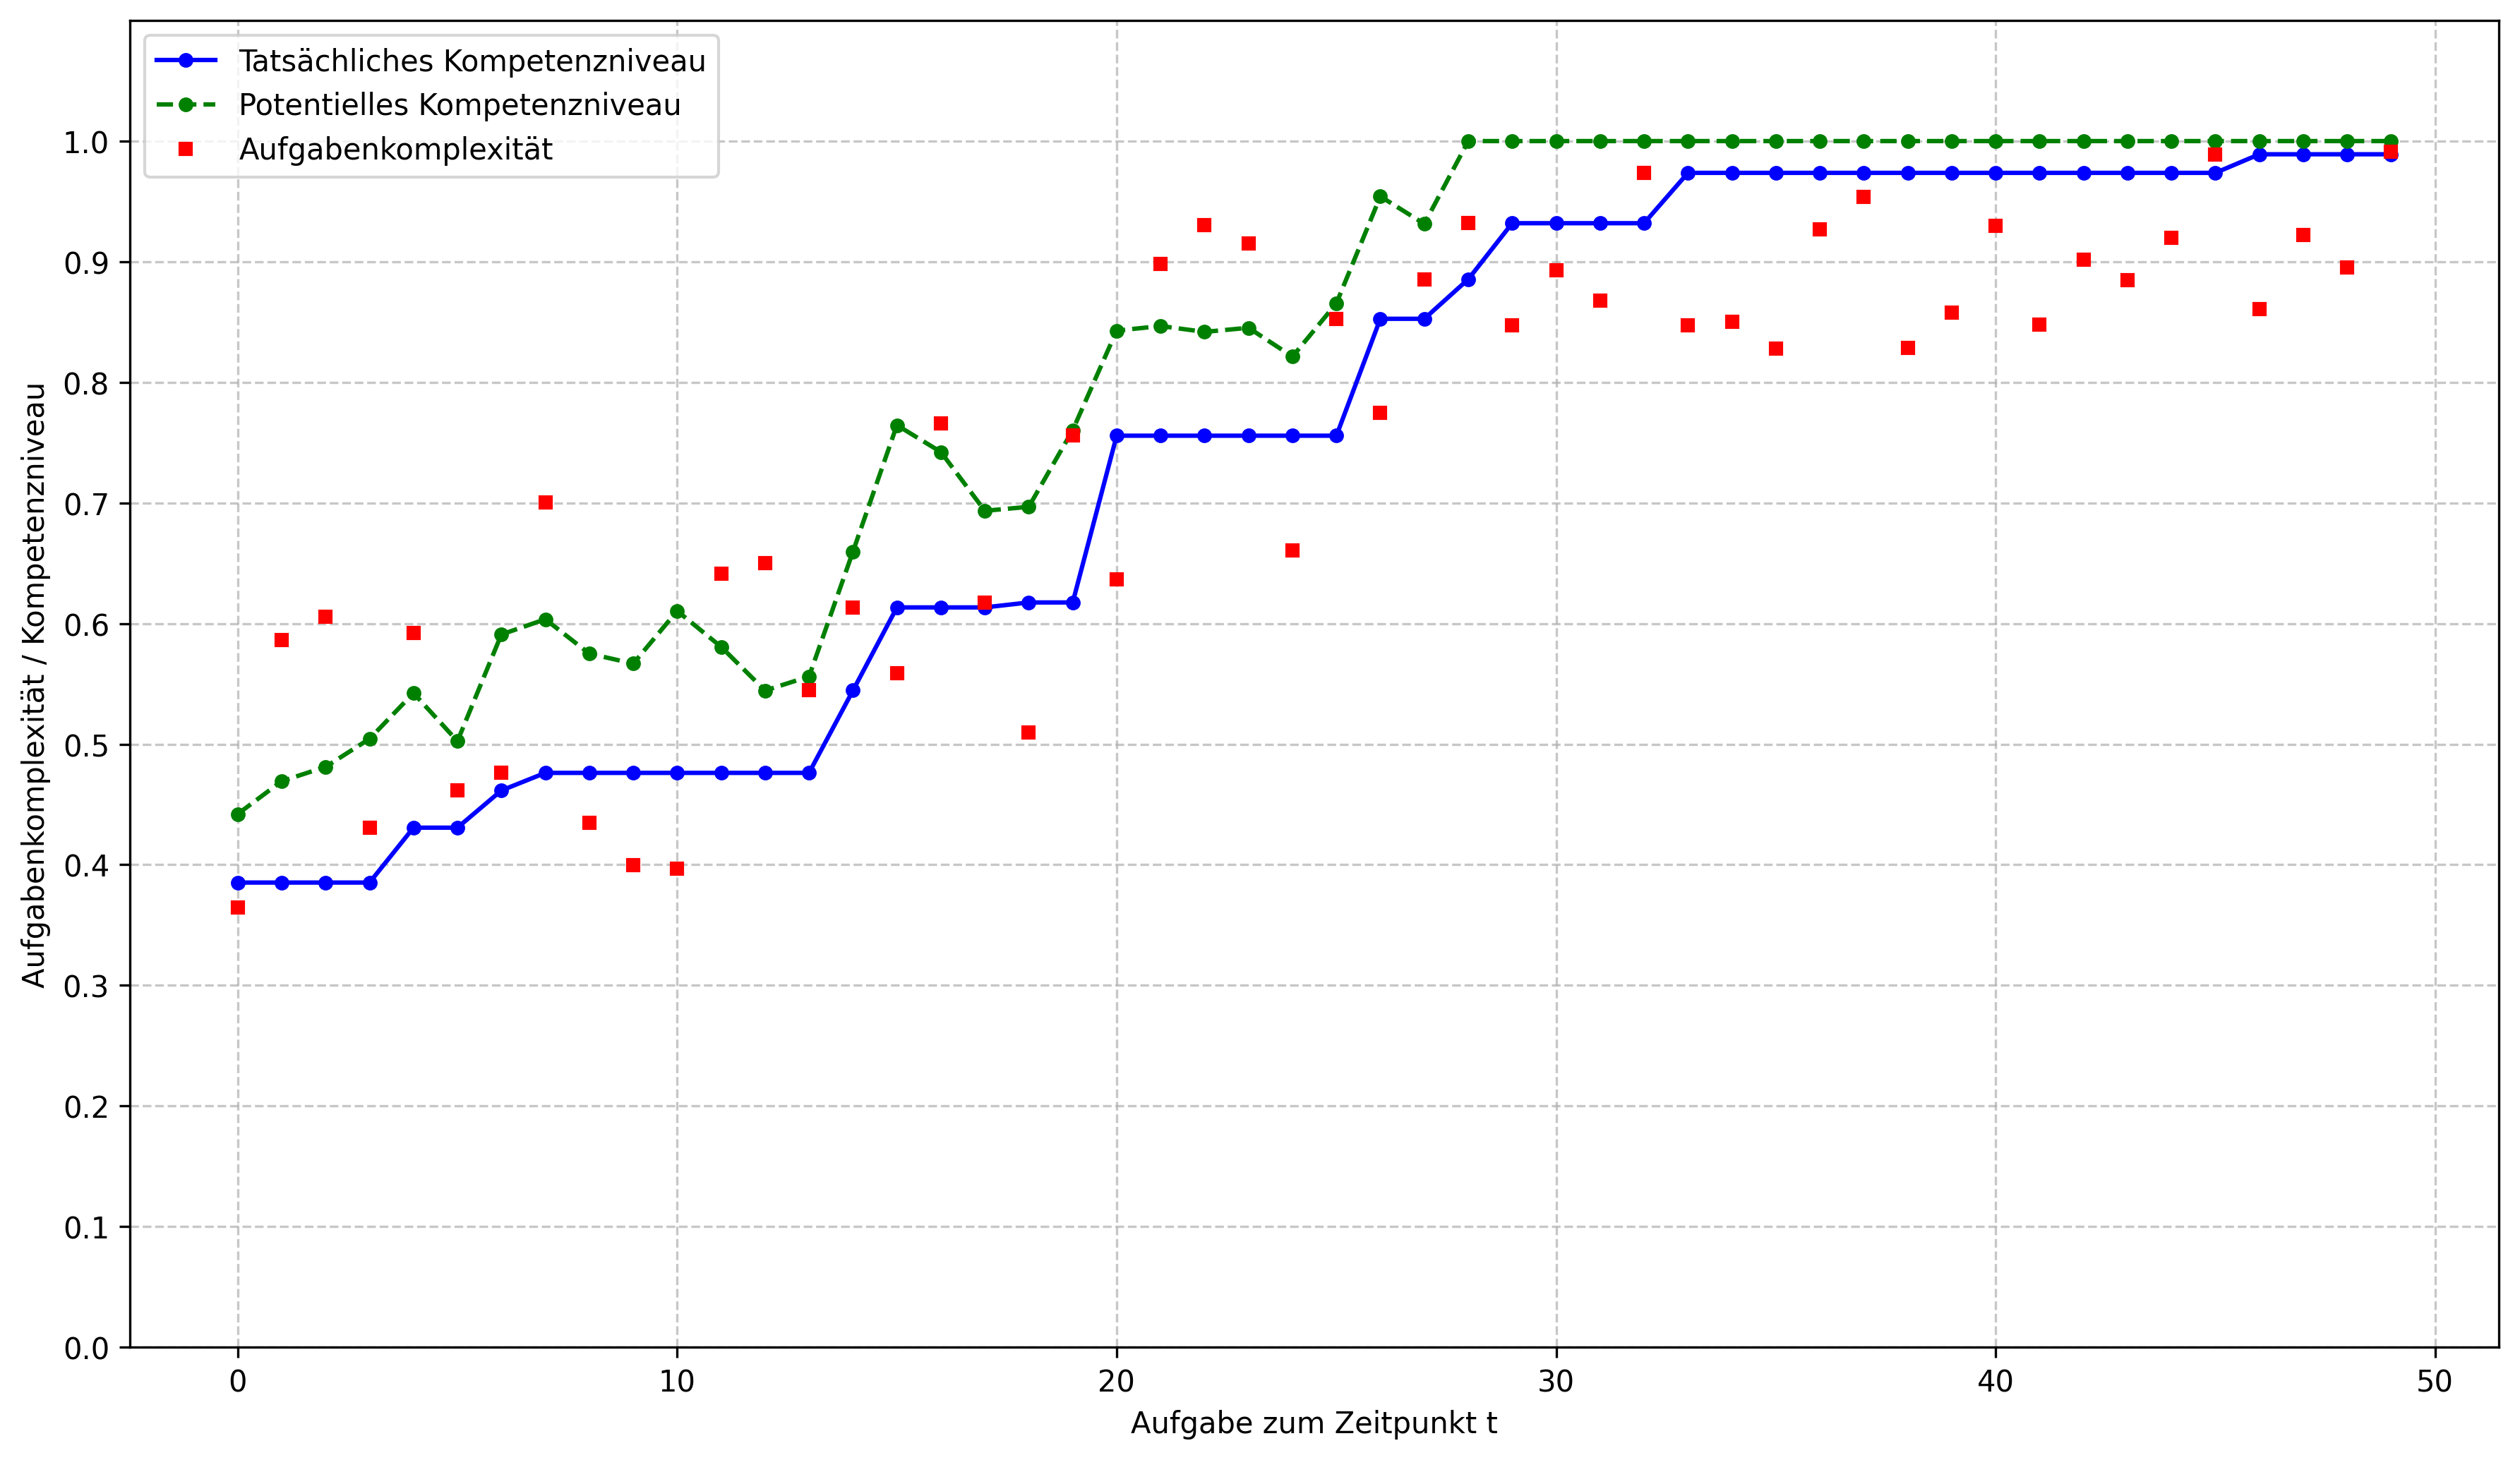

Competency: [np.float64(0.4607144944470988), np.float64(0.46573221134791354), np.float64(0.4791992257379736), np.float64(0.4928567051587199), np.float64(0.4980993699105551), np.float64(0.5039697364862161), np.float64(0.5365713638931218), np.float64(0.5588768572164109), np.float64(0.5748463689206171), np.float64(0.5766039943644745), np.float64(0.5827001221146202), np.float64(0.5959497639776656), np.float64(0.5983118570836718), np.float64(0.6111793208816643), np.float64(0.6248594367090877), np.float64(0.6395682868131862), np.float64(0.6447135234315716), np.float64(0.6676563492843048), np.float64(0.6940107339191014), np.float64(0.7108152404777971), np.float64(0.7108152404777971), np.float64(0.7279886987545713), np.float64(0.7409232956045124), np.float64(0.7557398362793837), np.float64(0.7643676385671249), np.float64(0.771526551490542), np.float64(0.7790517265115386), np.float64(0.790591865916868), np.float64(0.7983660004282883), np.float64(0.8191310190683533), np.float64(0.82647261776428)

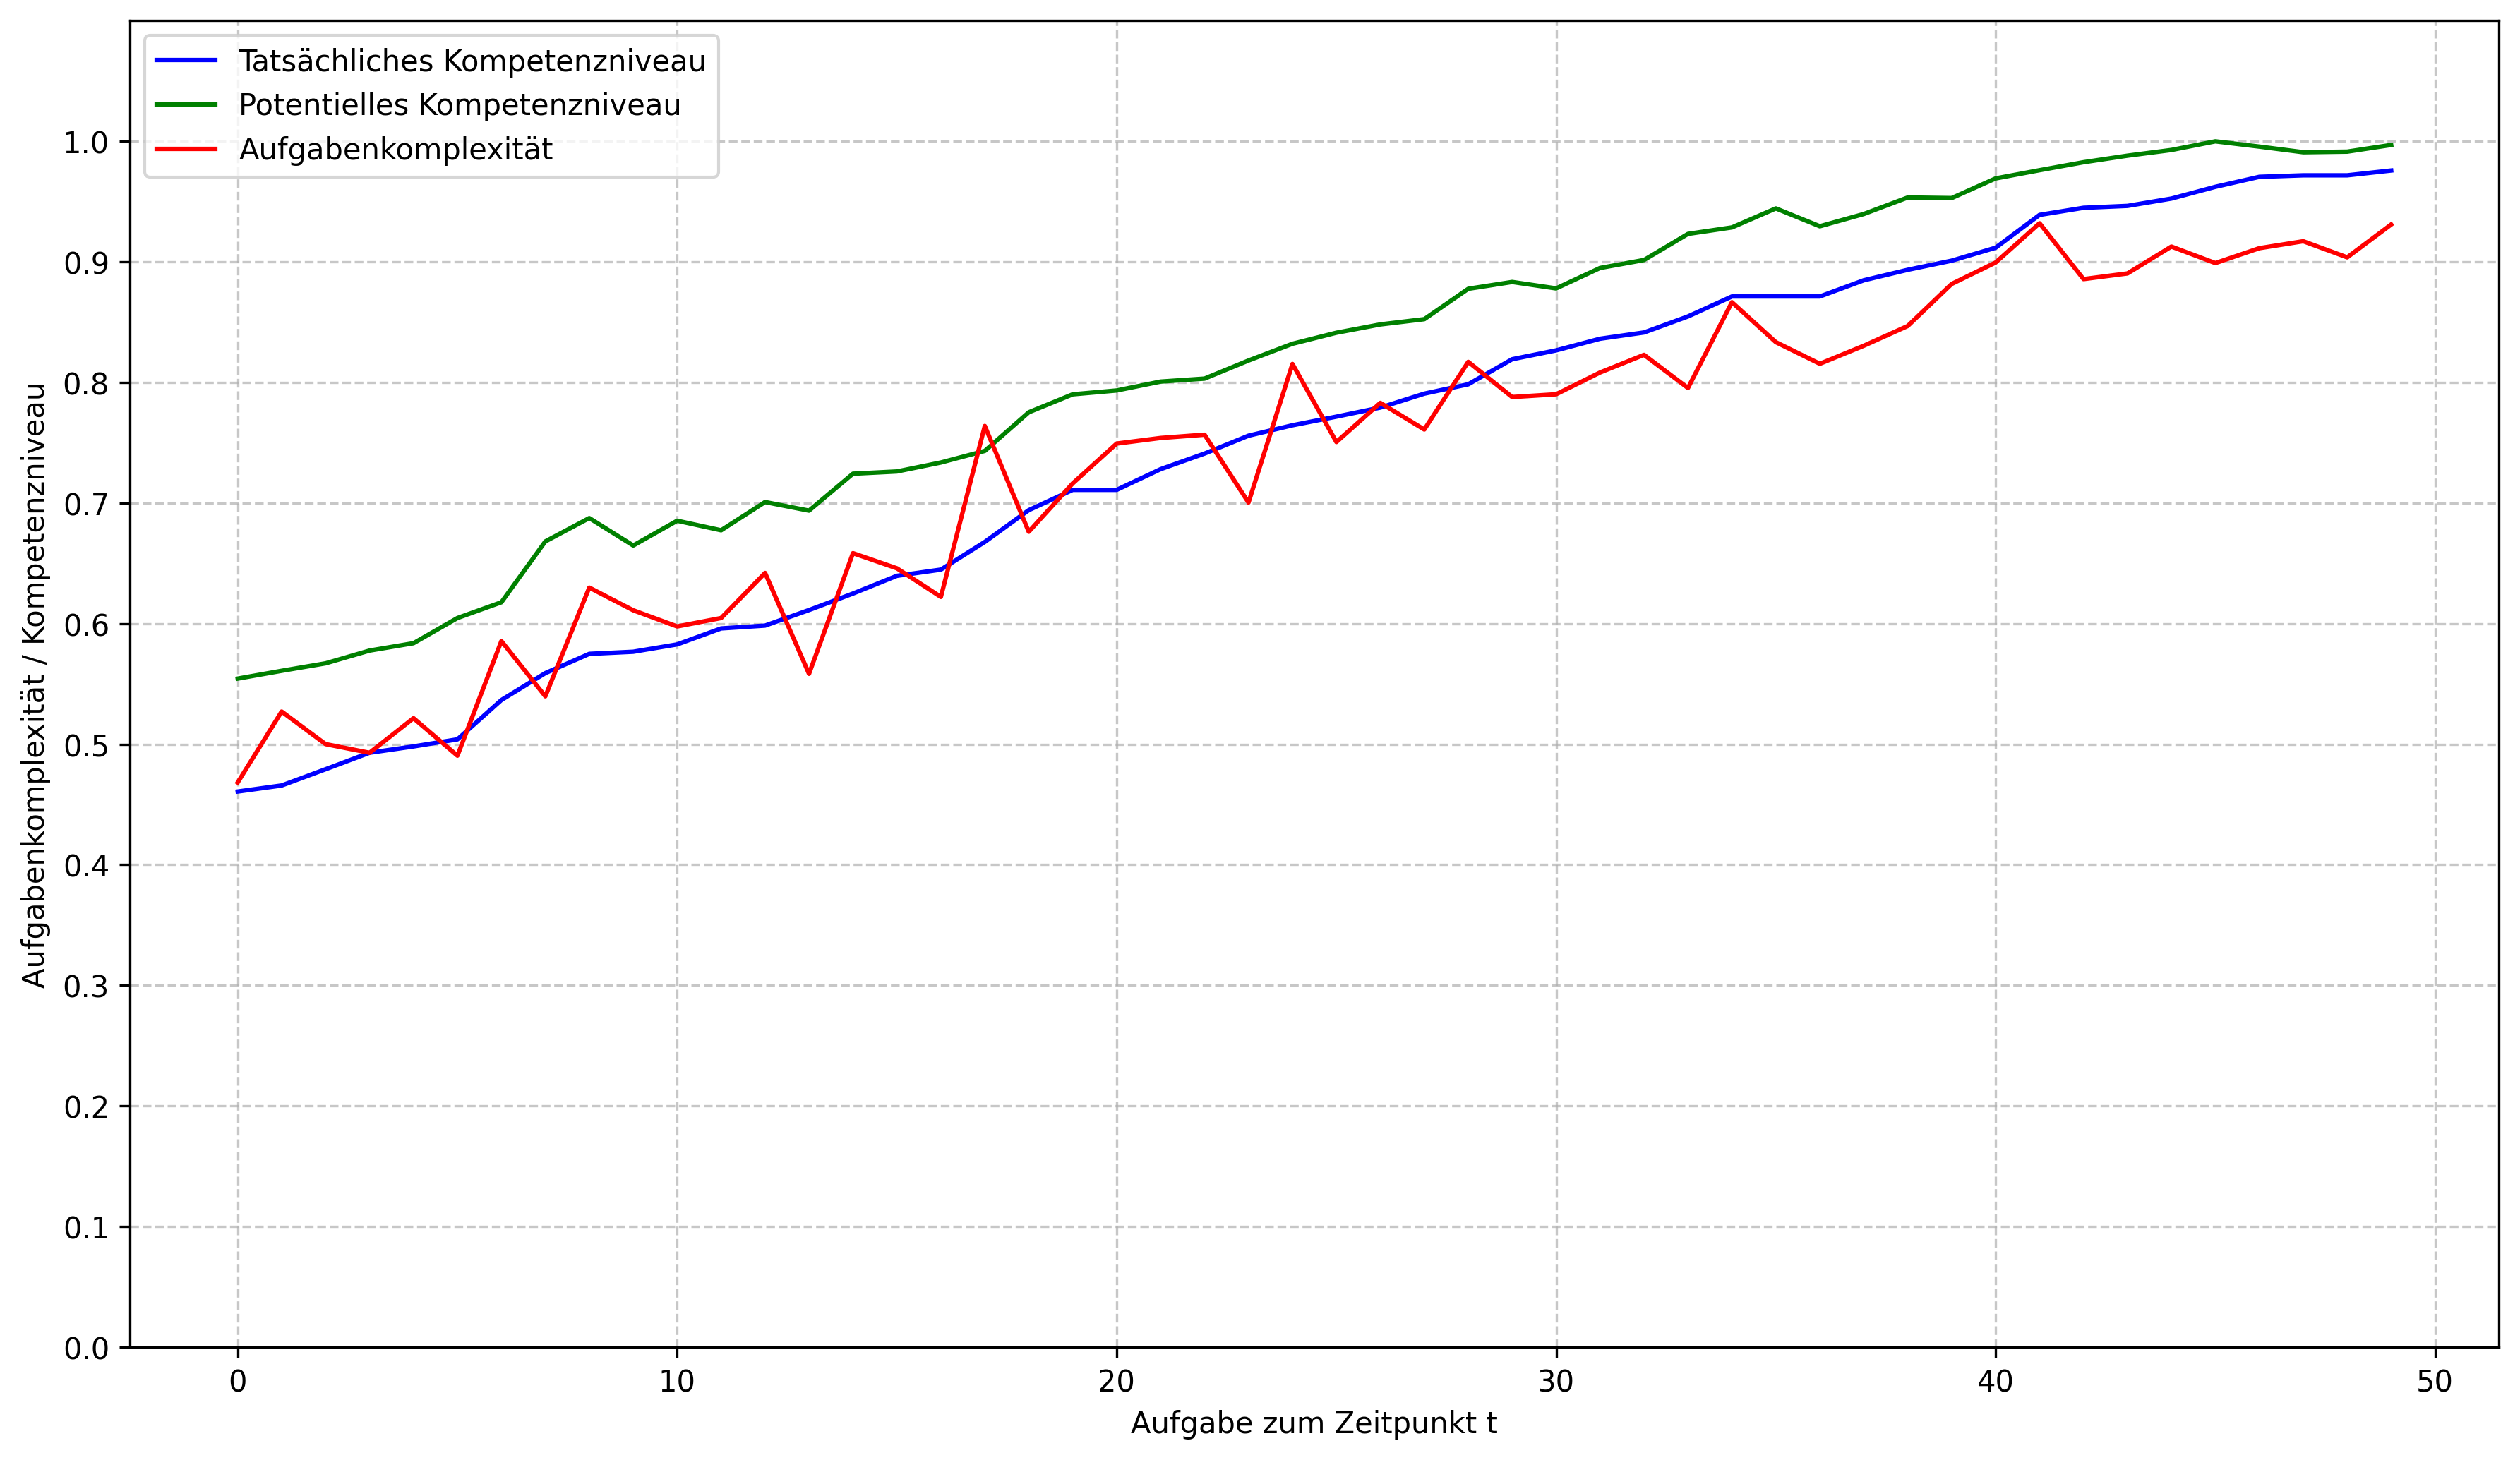

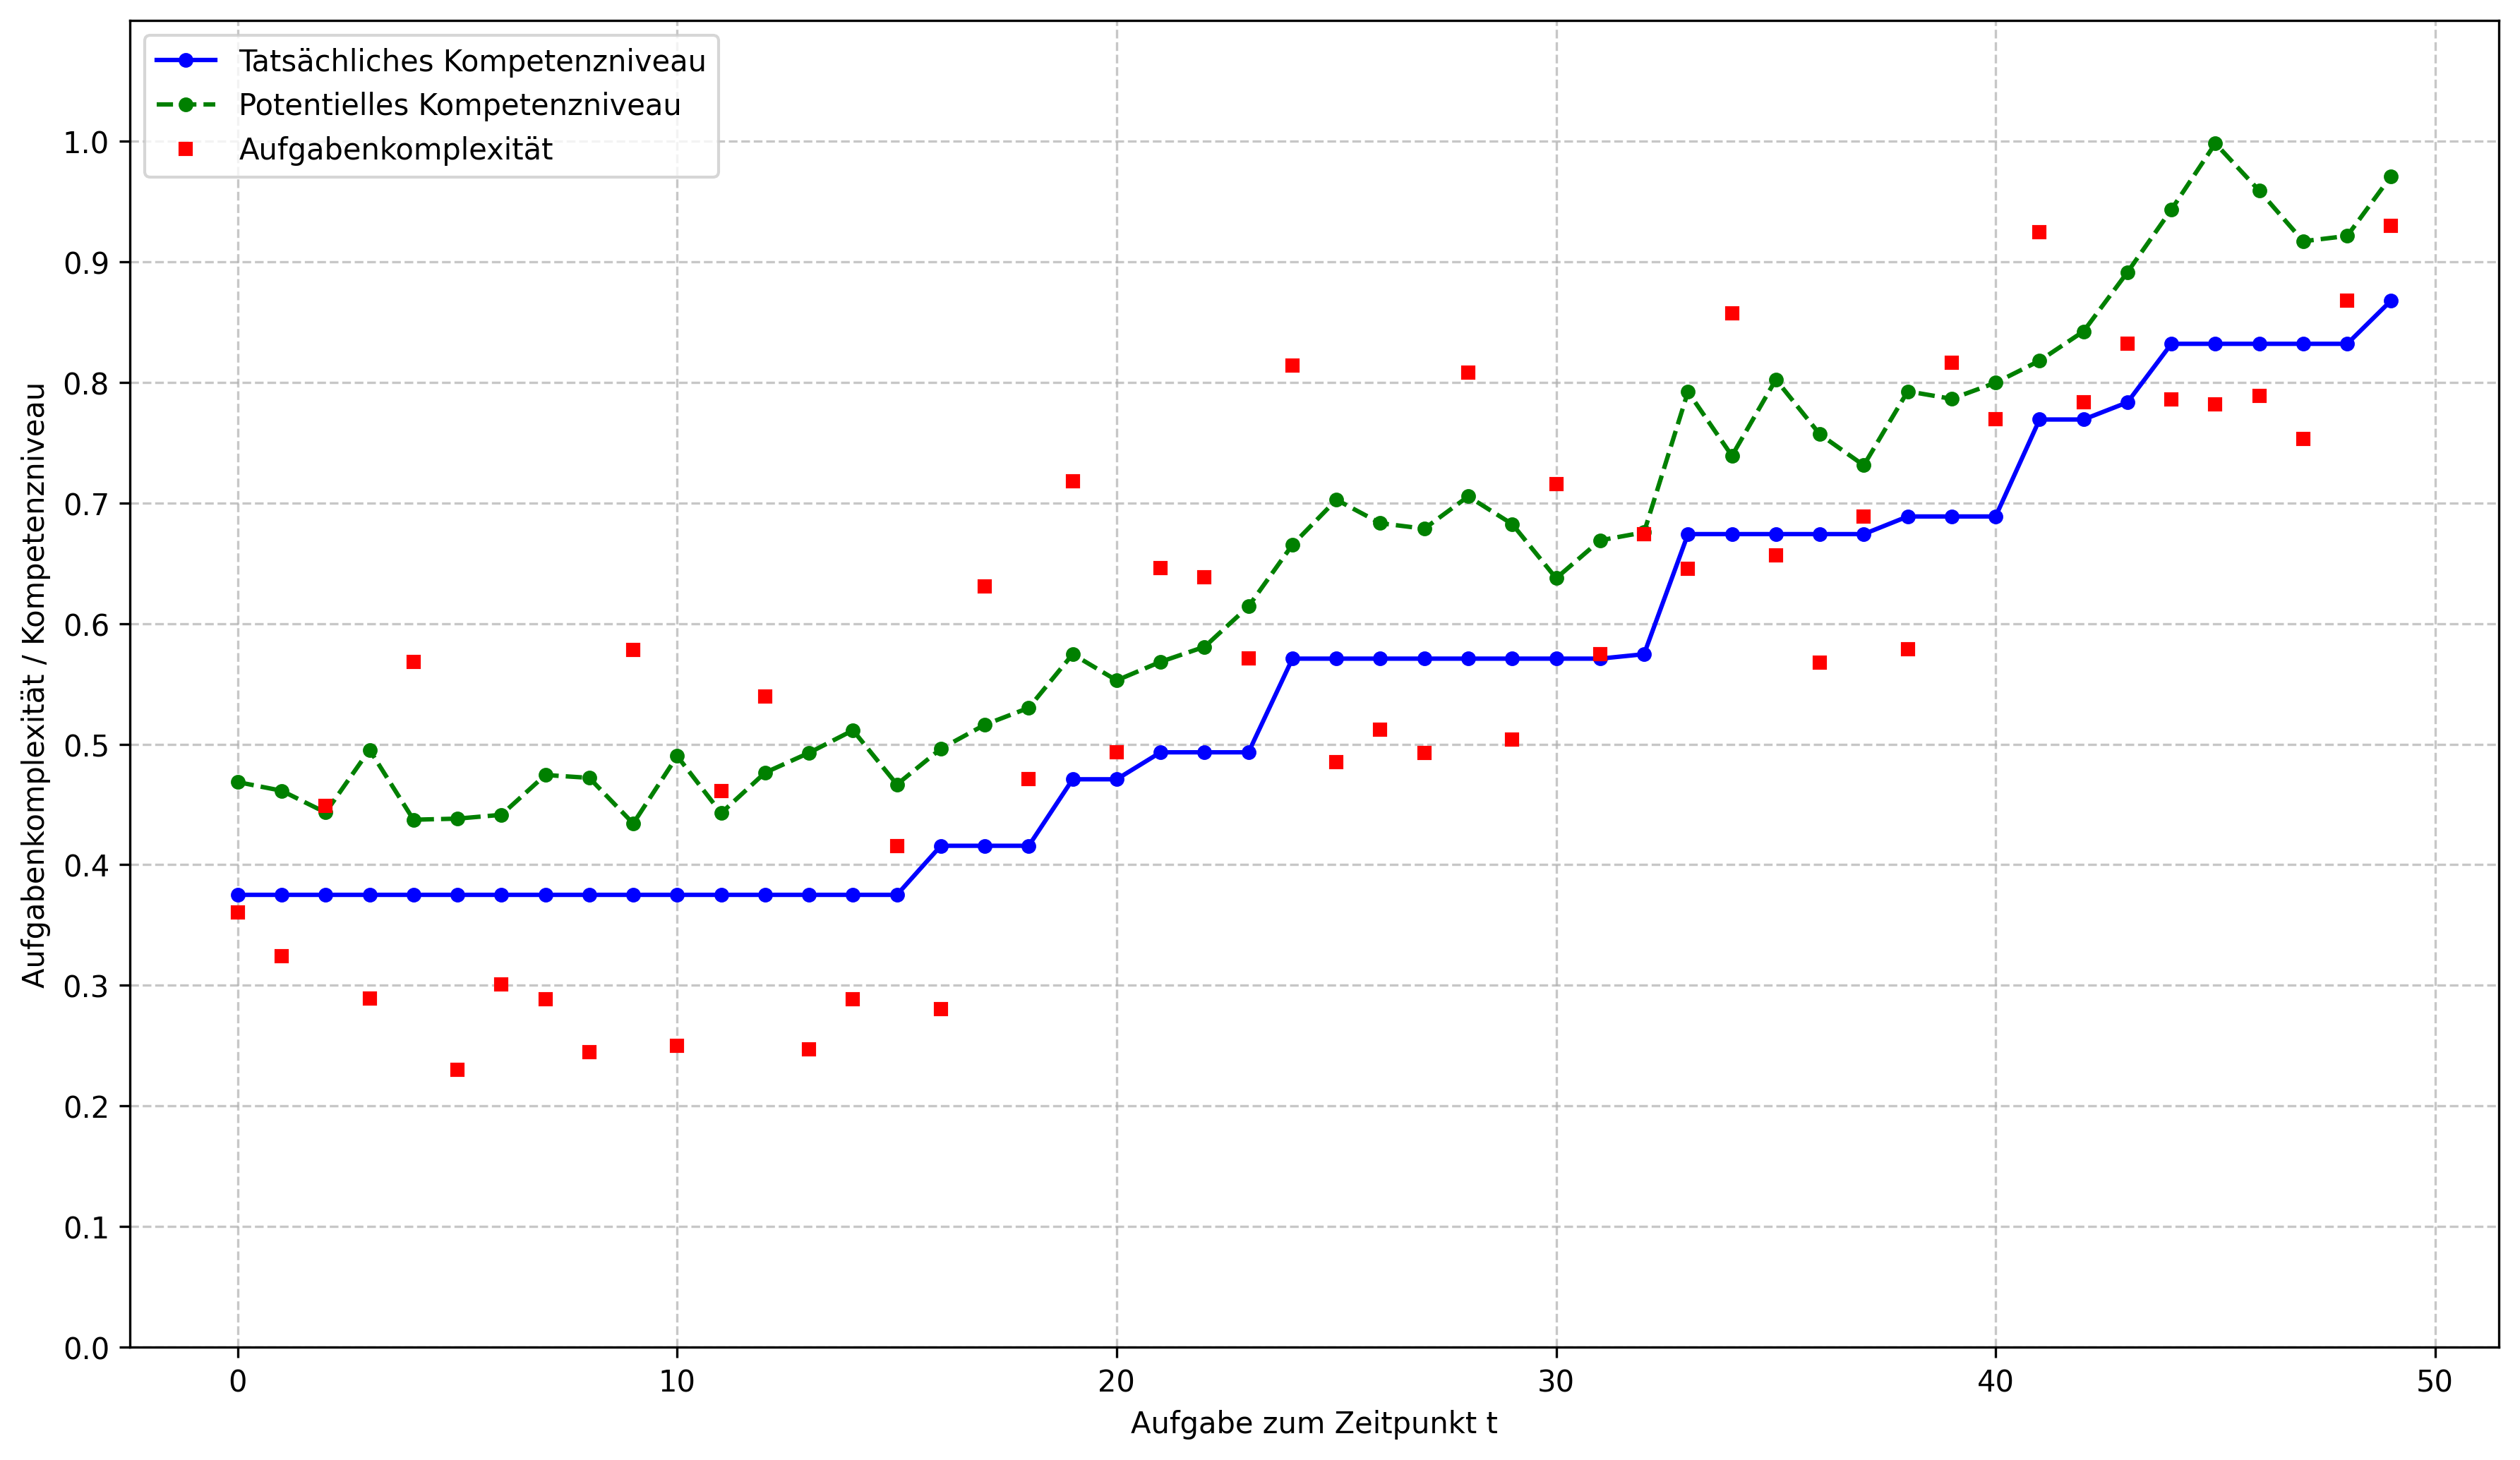

Competency: [np.float64(0.5671757722659261), np.float64(0.5897050751603475), np.float64(0.5974731308411354), np.float64(0.5974731308411354), np.float64(0.6031190689379112), np.float64(0.6283051564933246), np.float64(0.6283051564933246), np.float64(0.6430296325680996), np.float64(0.6510060983695745), np.float64(0.6620517527078059), np.float64(0.6673177099644949), np.float64(0.7009391527589819), np.float64(0.715260528173301), np.float64(0.7357096259408683), np.float64(0.7690522164937783), np.float64(0.7800710273998184), np.float64(0.7898325267786169), np.float64(0.815216404485387), np.float64(0.8320054380738601), np.float64(0.8496390223423753), np.float64(0.8525959140897075), np.float64(0.8648369536746606), np.float64(0.8751860197450022), np.float64(0.8961073326829878), np.float64(0.9230272285106774), np.float64(0.9448715653780655), np.float64(0.9618485177218431), np.float64(0.9726923404802539), np.float64(0.9764546385961373), np.float64(0.9764546385961373), np.float64(0.9764546385961373

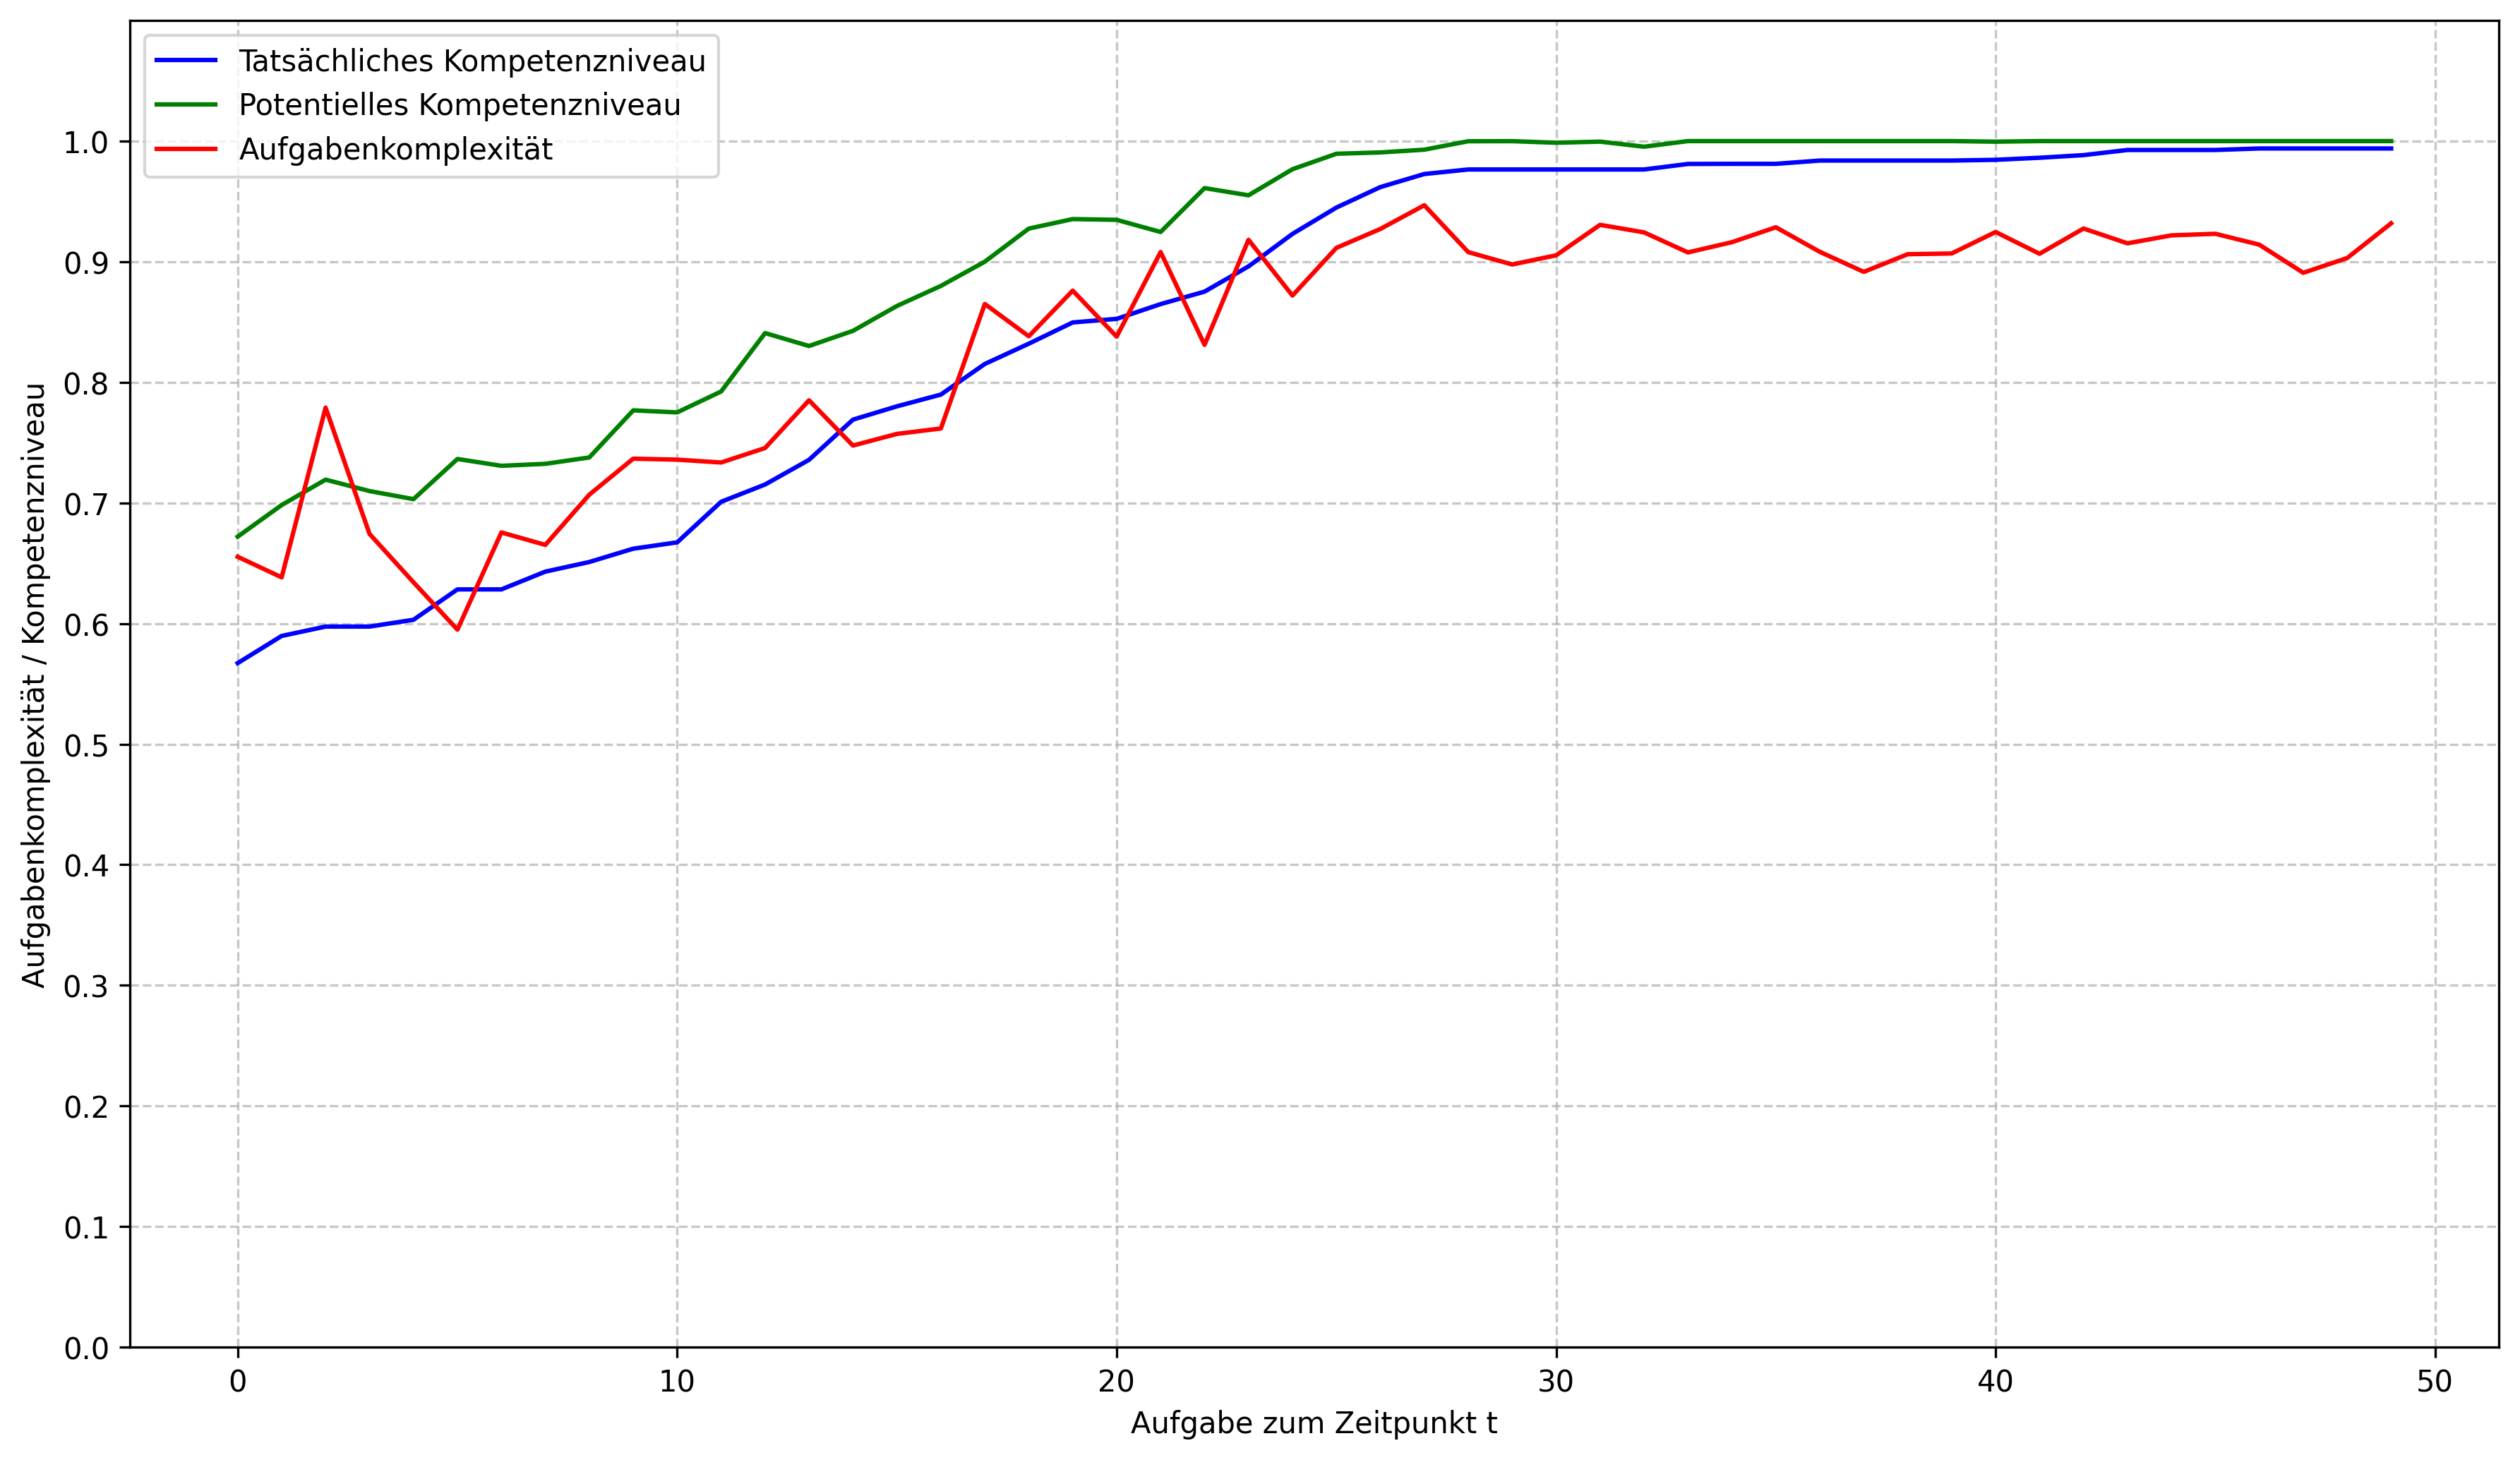

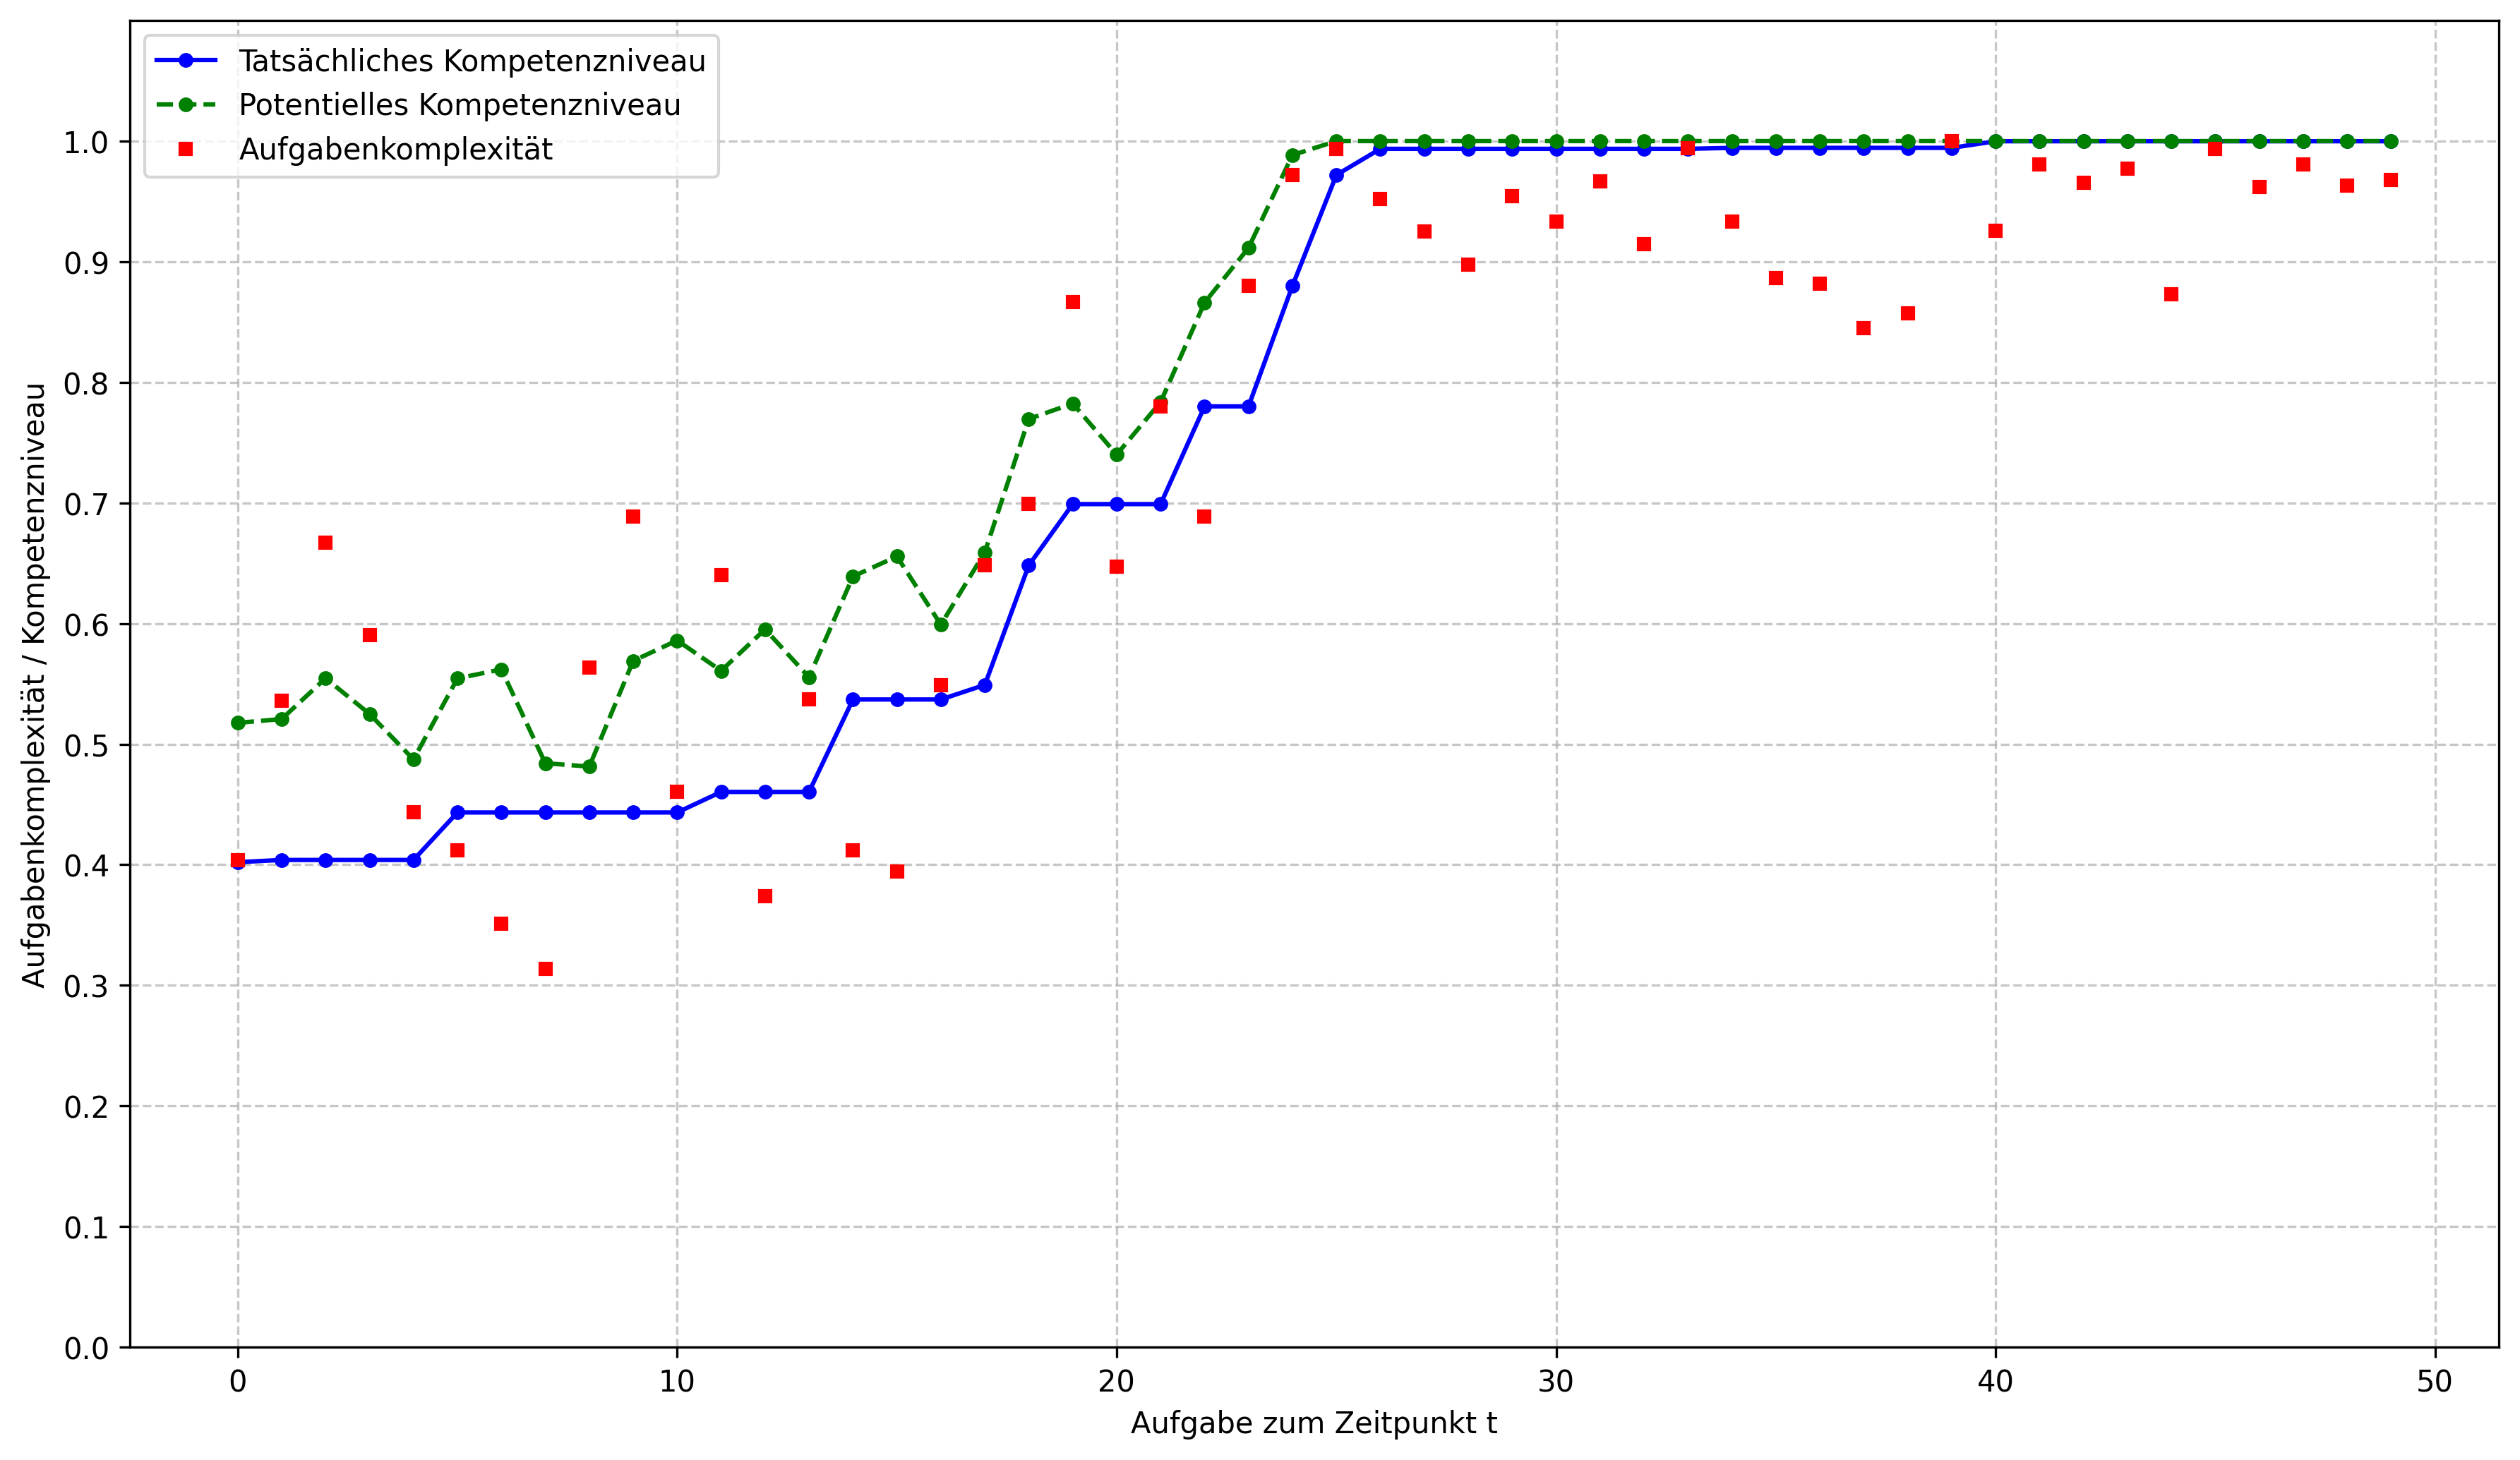

Competency: [np.float64(0.5297151200672267), np.float64(0.5436679112226676), np.float64(0.5457626526048293), np.float64(0.5540767171337352), np.float64(0.5670105999686947), np.float64(0.5977700392663094), np.float64(0.6160328295436308), np.float64(0.6461006144880557), np.float64(0.6619517038496368), np.float64(0.6702543884796985), np.float64(0.7172840396380177), np.float64(0.7317245512824564), np.float64(0.7380248109816689), np.float64(0.7471229776499775), np.float64(0.7629448033403093), np.float64(0.7829118827601291), np.float64(0.7949061368992026), np.float64(0.7954200752005243), np.float64(0.8129027938267541), np.float64(0.8160507257293811), np.float64(0.8303044996827542), np.float64(0.8303044996827542), np.float64(0.8423462032060661), np.float64(0.8599563932732048), np.float64(0.8667148847433361), np.float64(0.8683815934288119), np.float64(0.8781654862699598), np.float64(0.879485223492781), np.float64(0.8805838601235817), np.float64(0.8810753660079063), np.float64(0.881075366007906

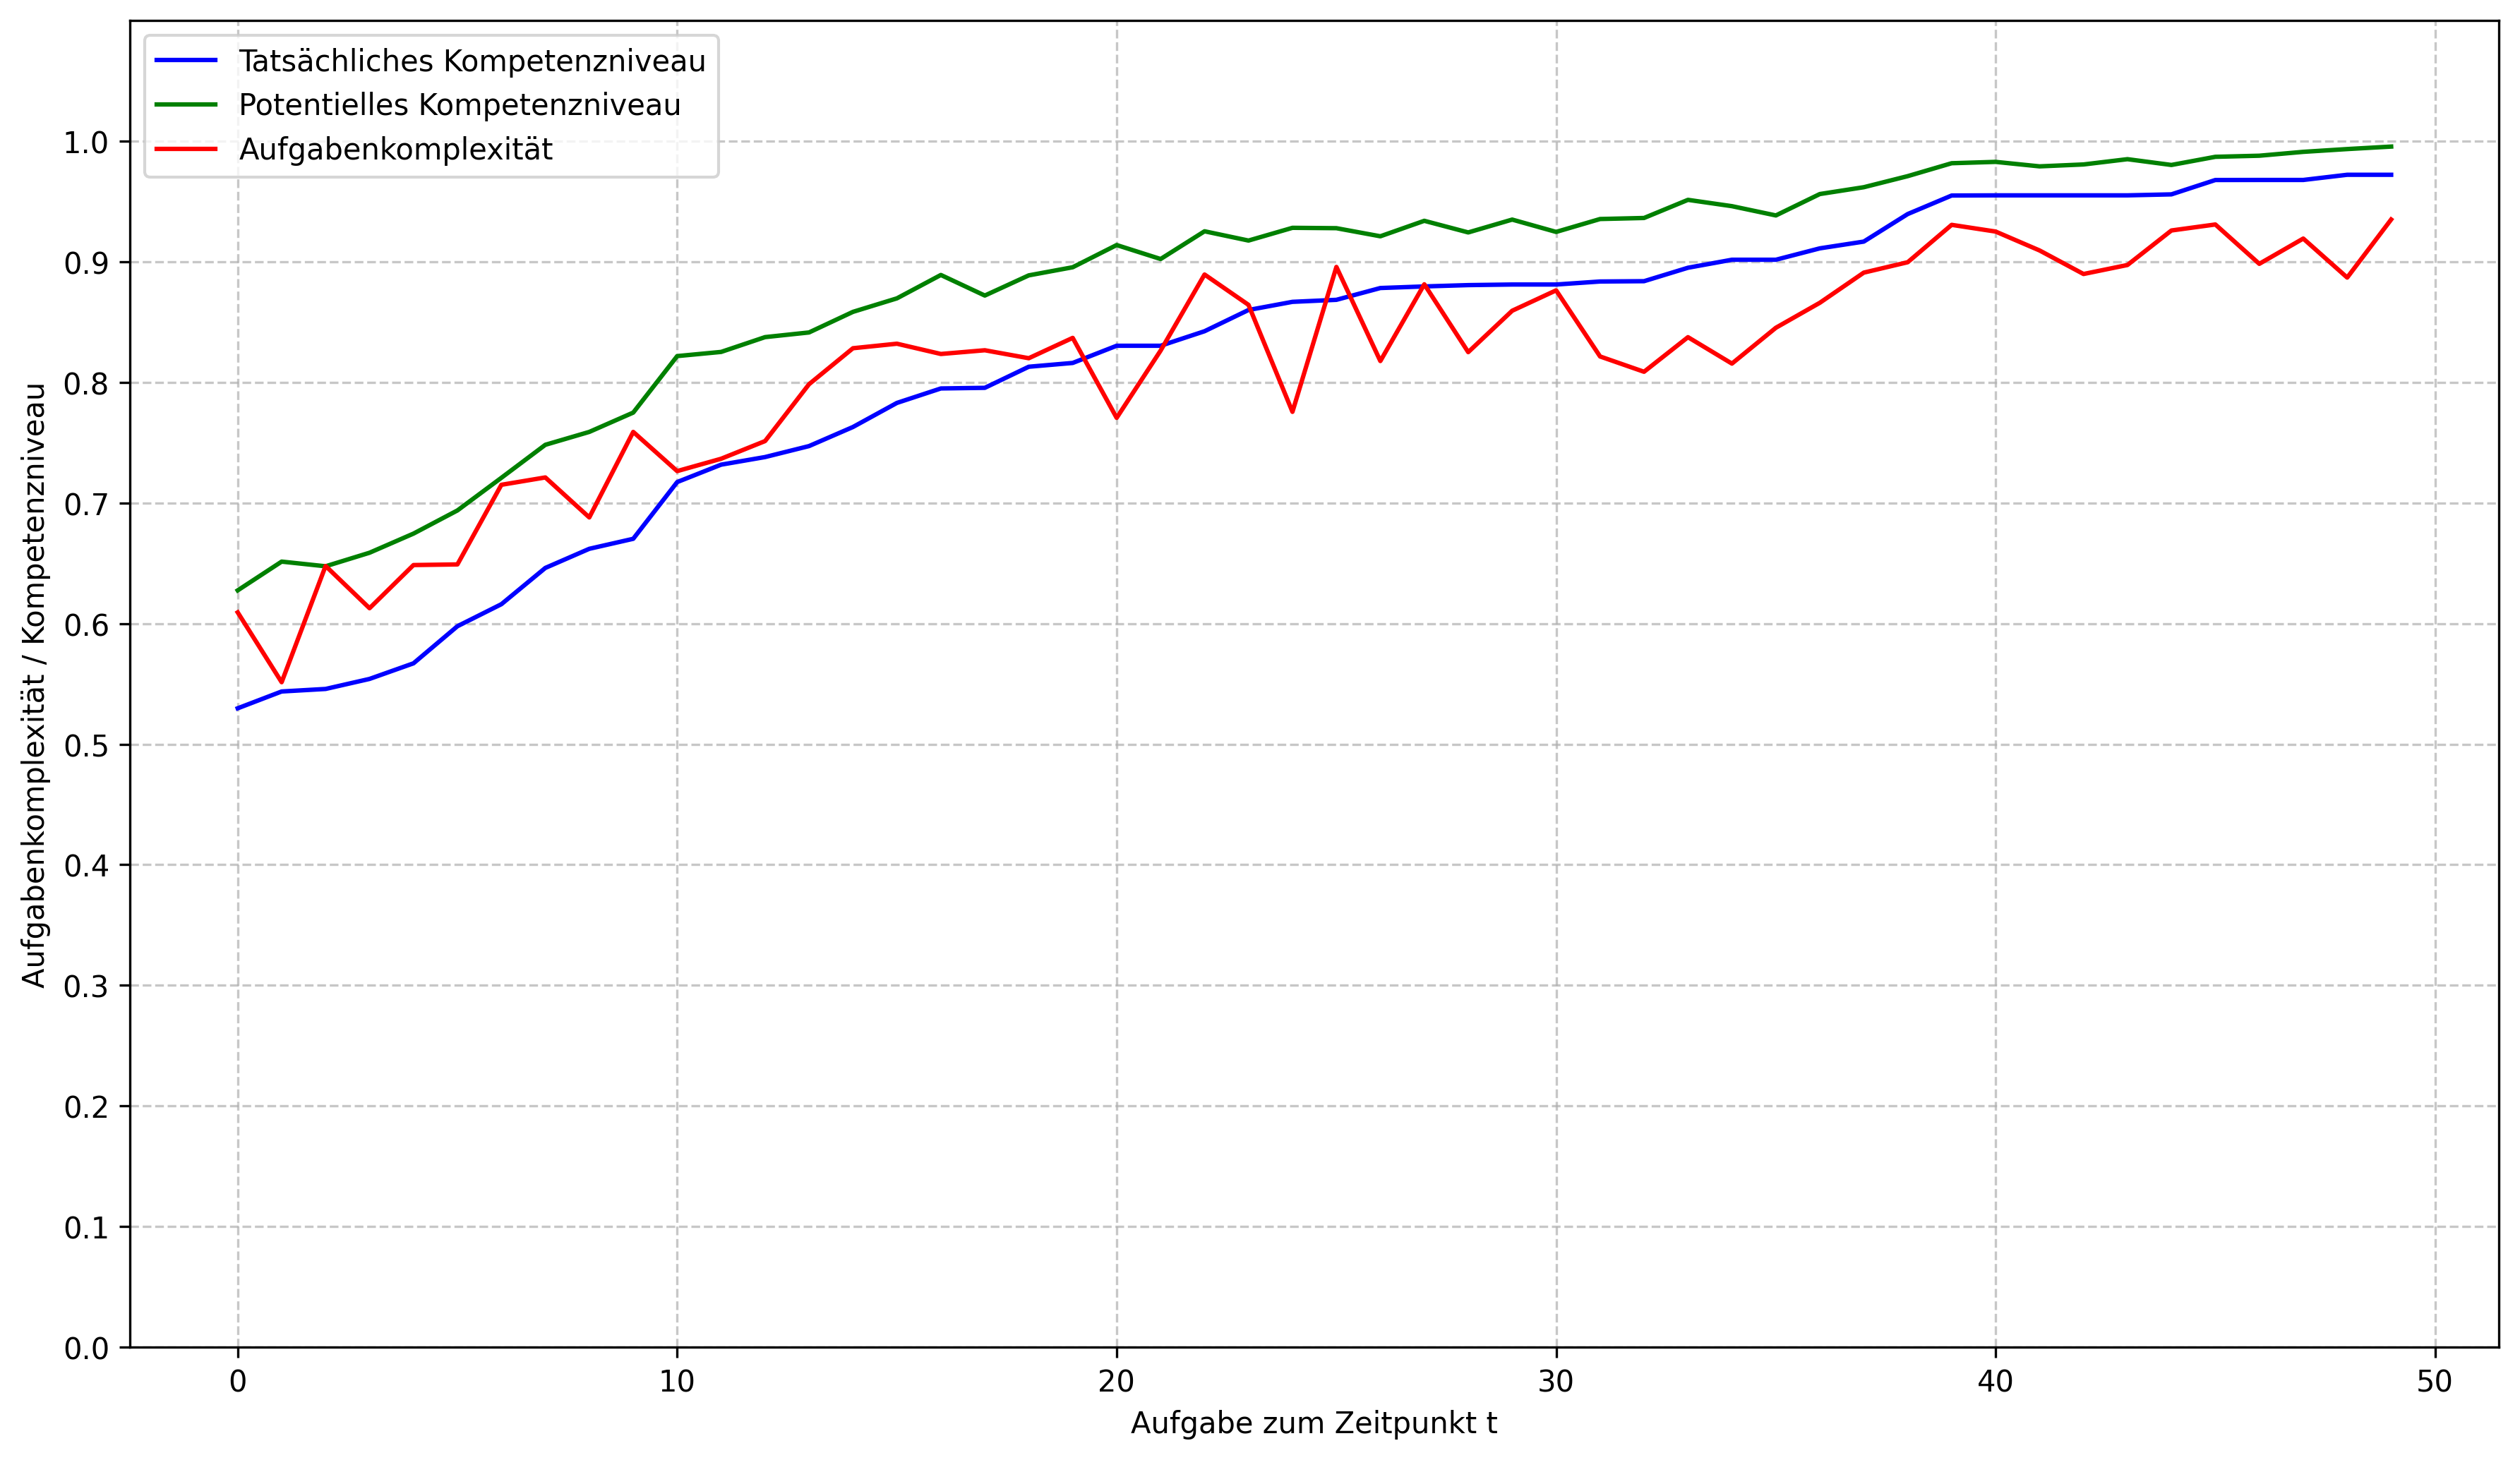

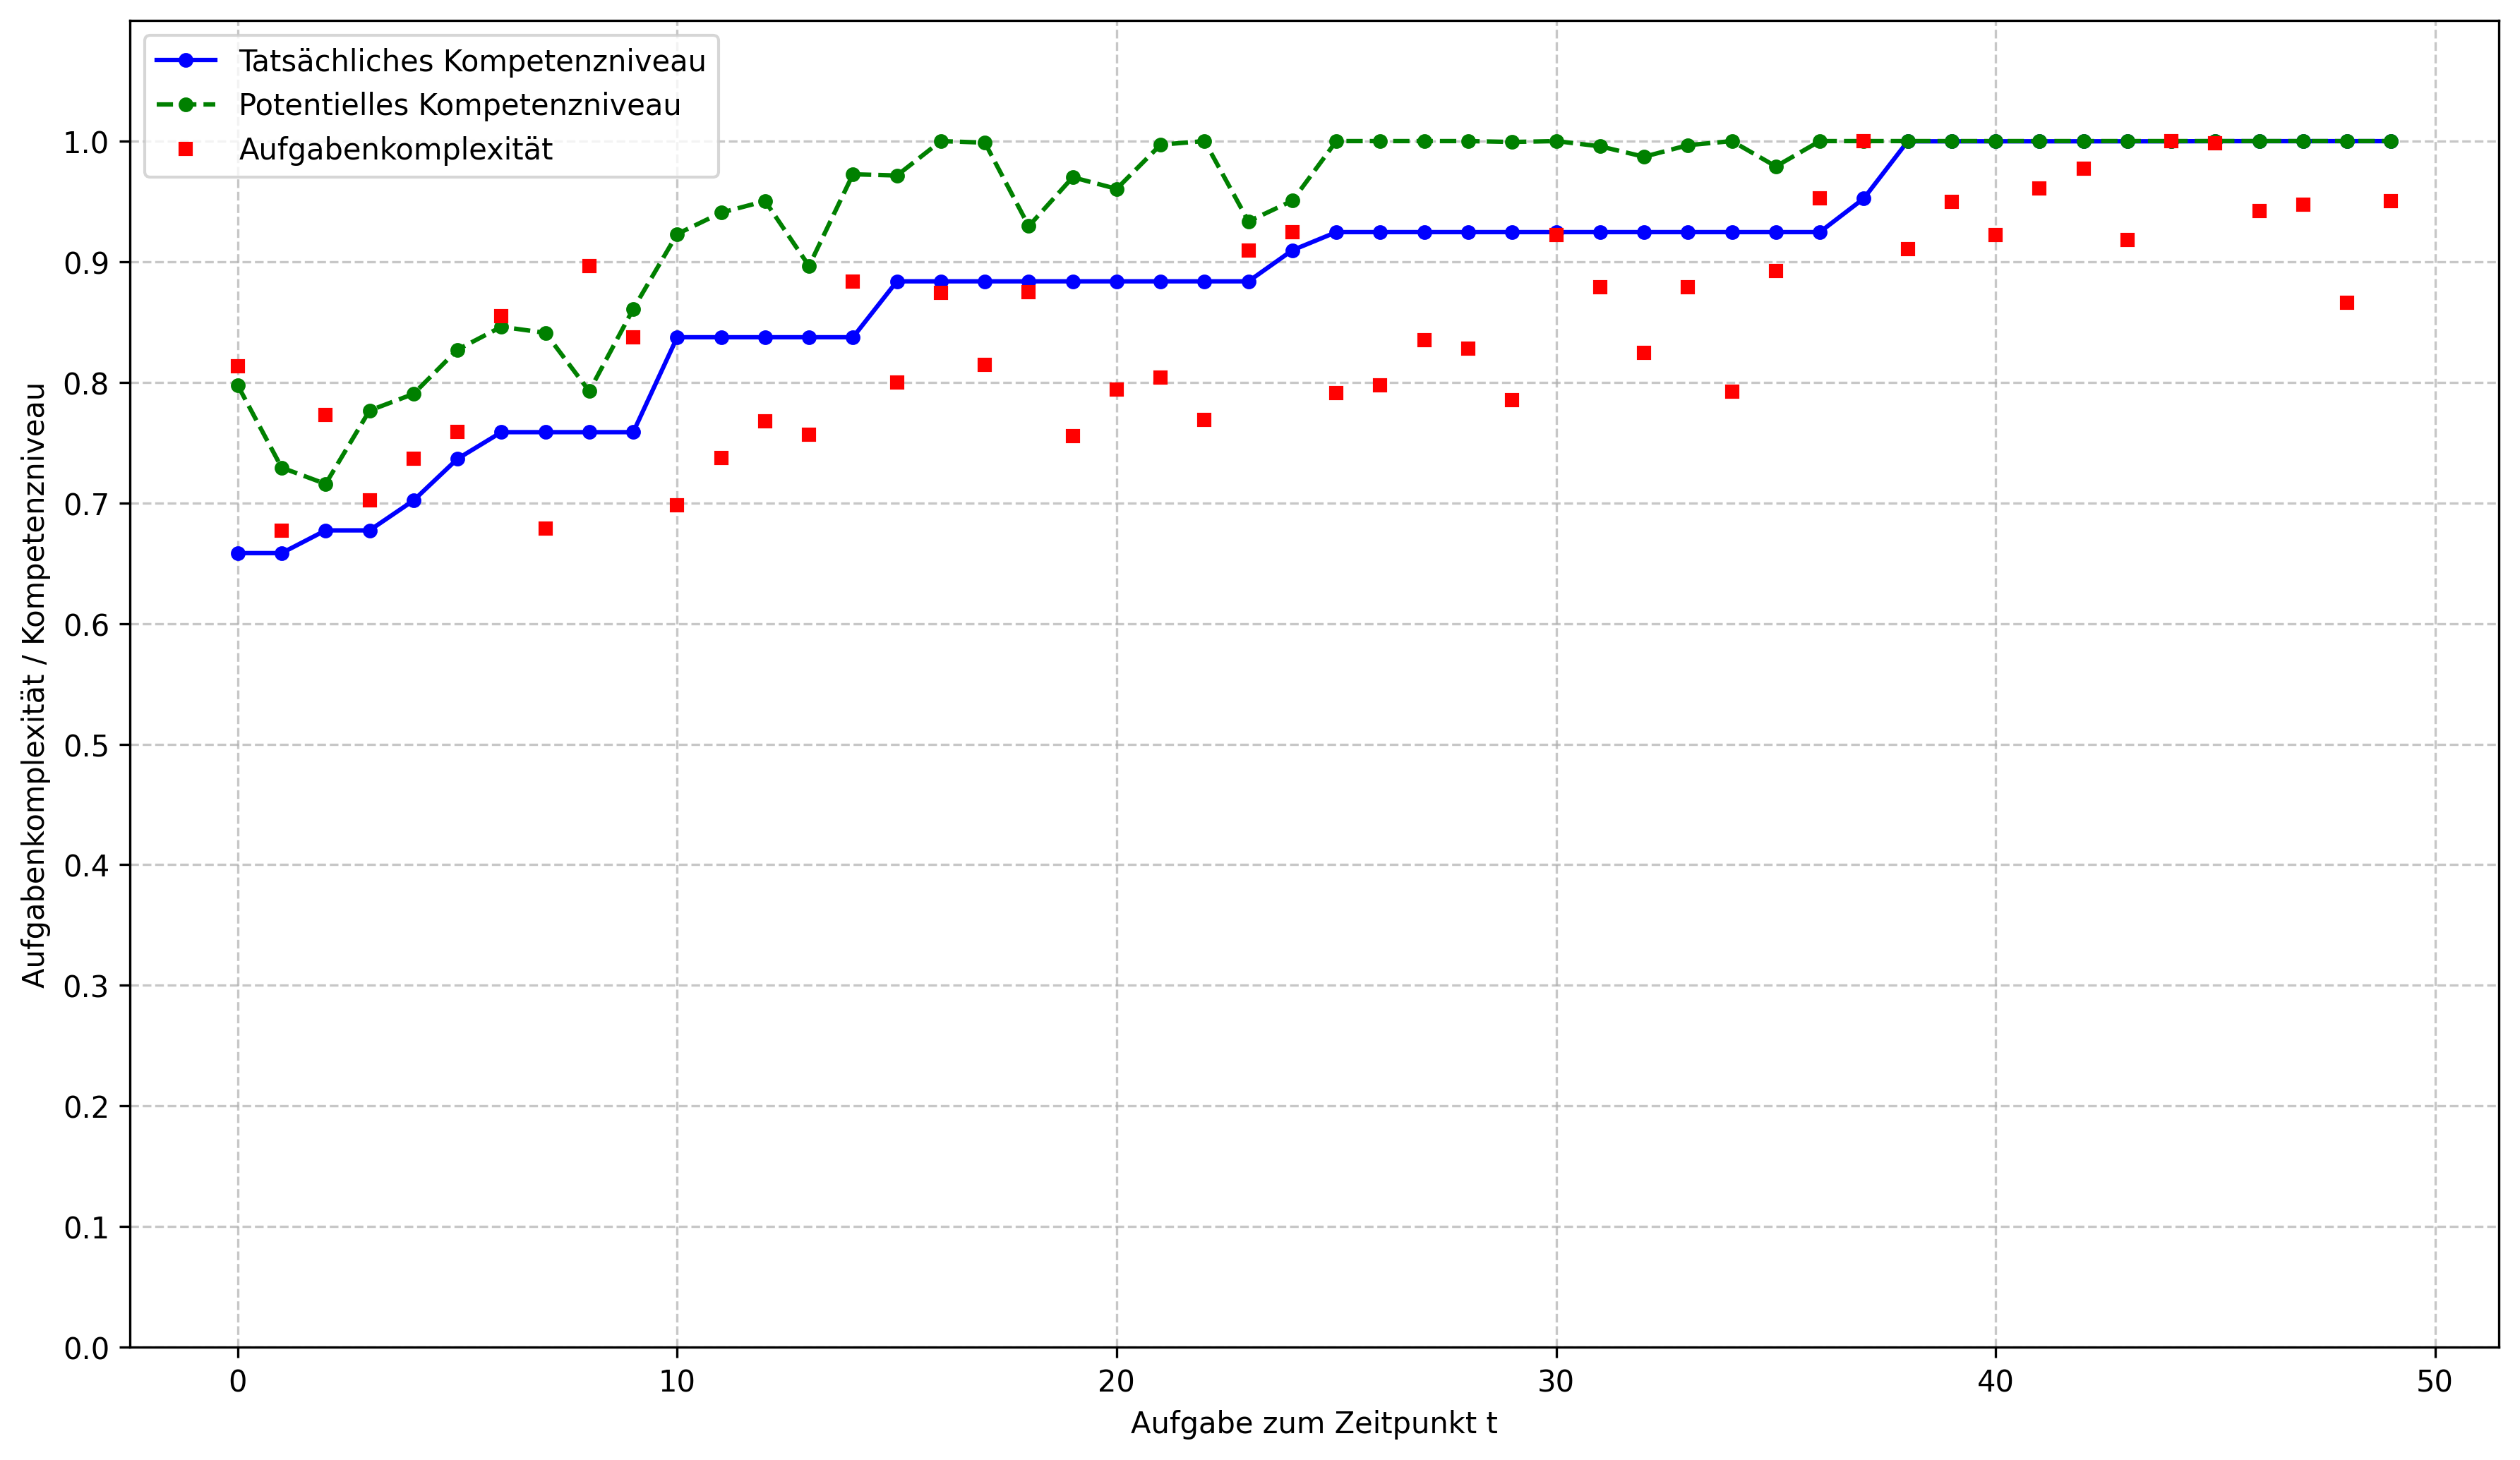

Competency: [np.float64(0.4812662835051451), np.float64(0.4913166128145971), np.float64(0.49702381990195366), np.float64(0.534607120253943), np.float64(0.534607120253943), np.float64(0.5387825365684236), np.float64(0.5698912336201214), np.float64(0.5968008234144894), np.float64(0.6114908373139862), np.float64(0.6209067733613634), np.float64(0.6384272995172426), np.float64(0.6384272995172426), np.float64(0.6464458567047304), np.float64(0.6464458567047304), np.float64(0.6478951837898472), np.float64(0.6537323805987961), np.float64(0.6725188619635738), np.float64(0.6792965841830385), np.float64(0.693640505354193), np.float64(0.706730015505863), np.float64(0.7133189764111117), np.float64(0.7362542425380114), np.float64(0.7471700679549724), np.float64(0.751854788060681), np.float64(0.7588836088071624), np.float64(0.759465280875677), np.float64(0.7686780873685028), np.float64(0.7860522962797372), np.float64(0.7860522962797372), np.float64(0.7920997145385922), np.float64(0.7920997145385922), 

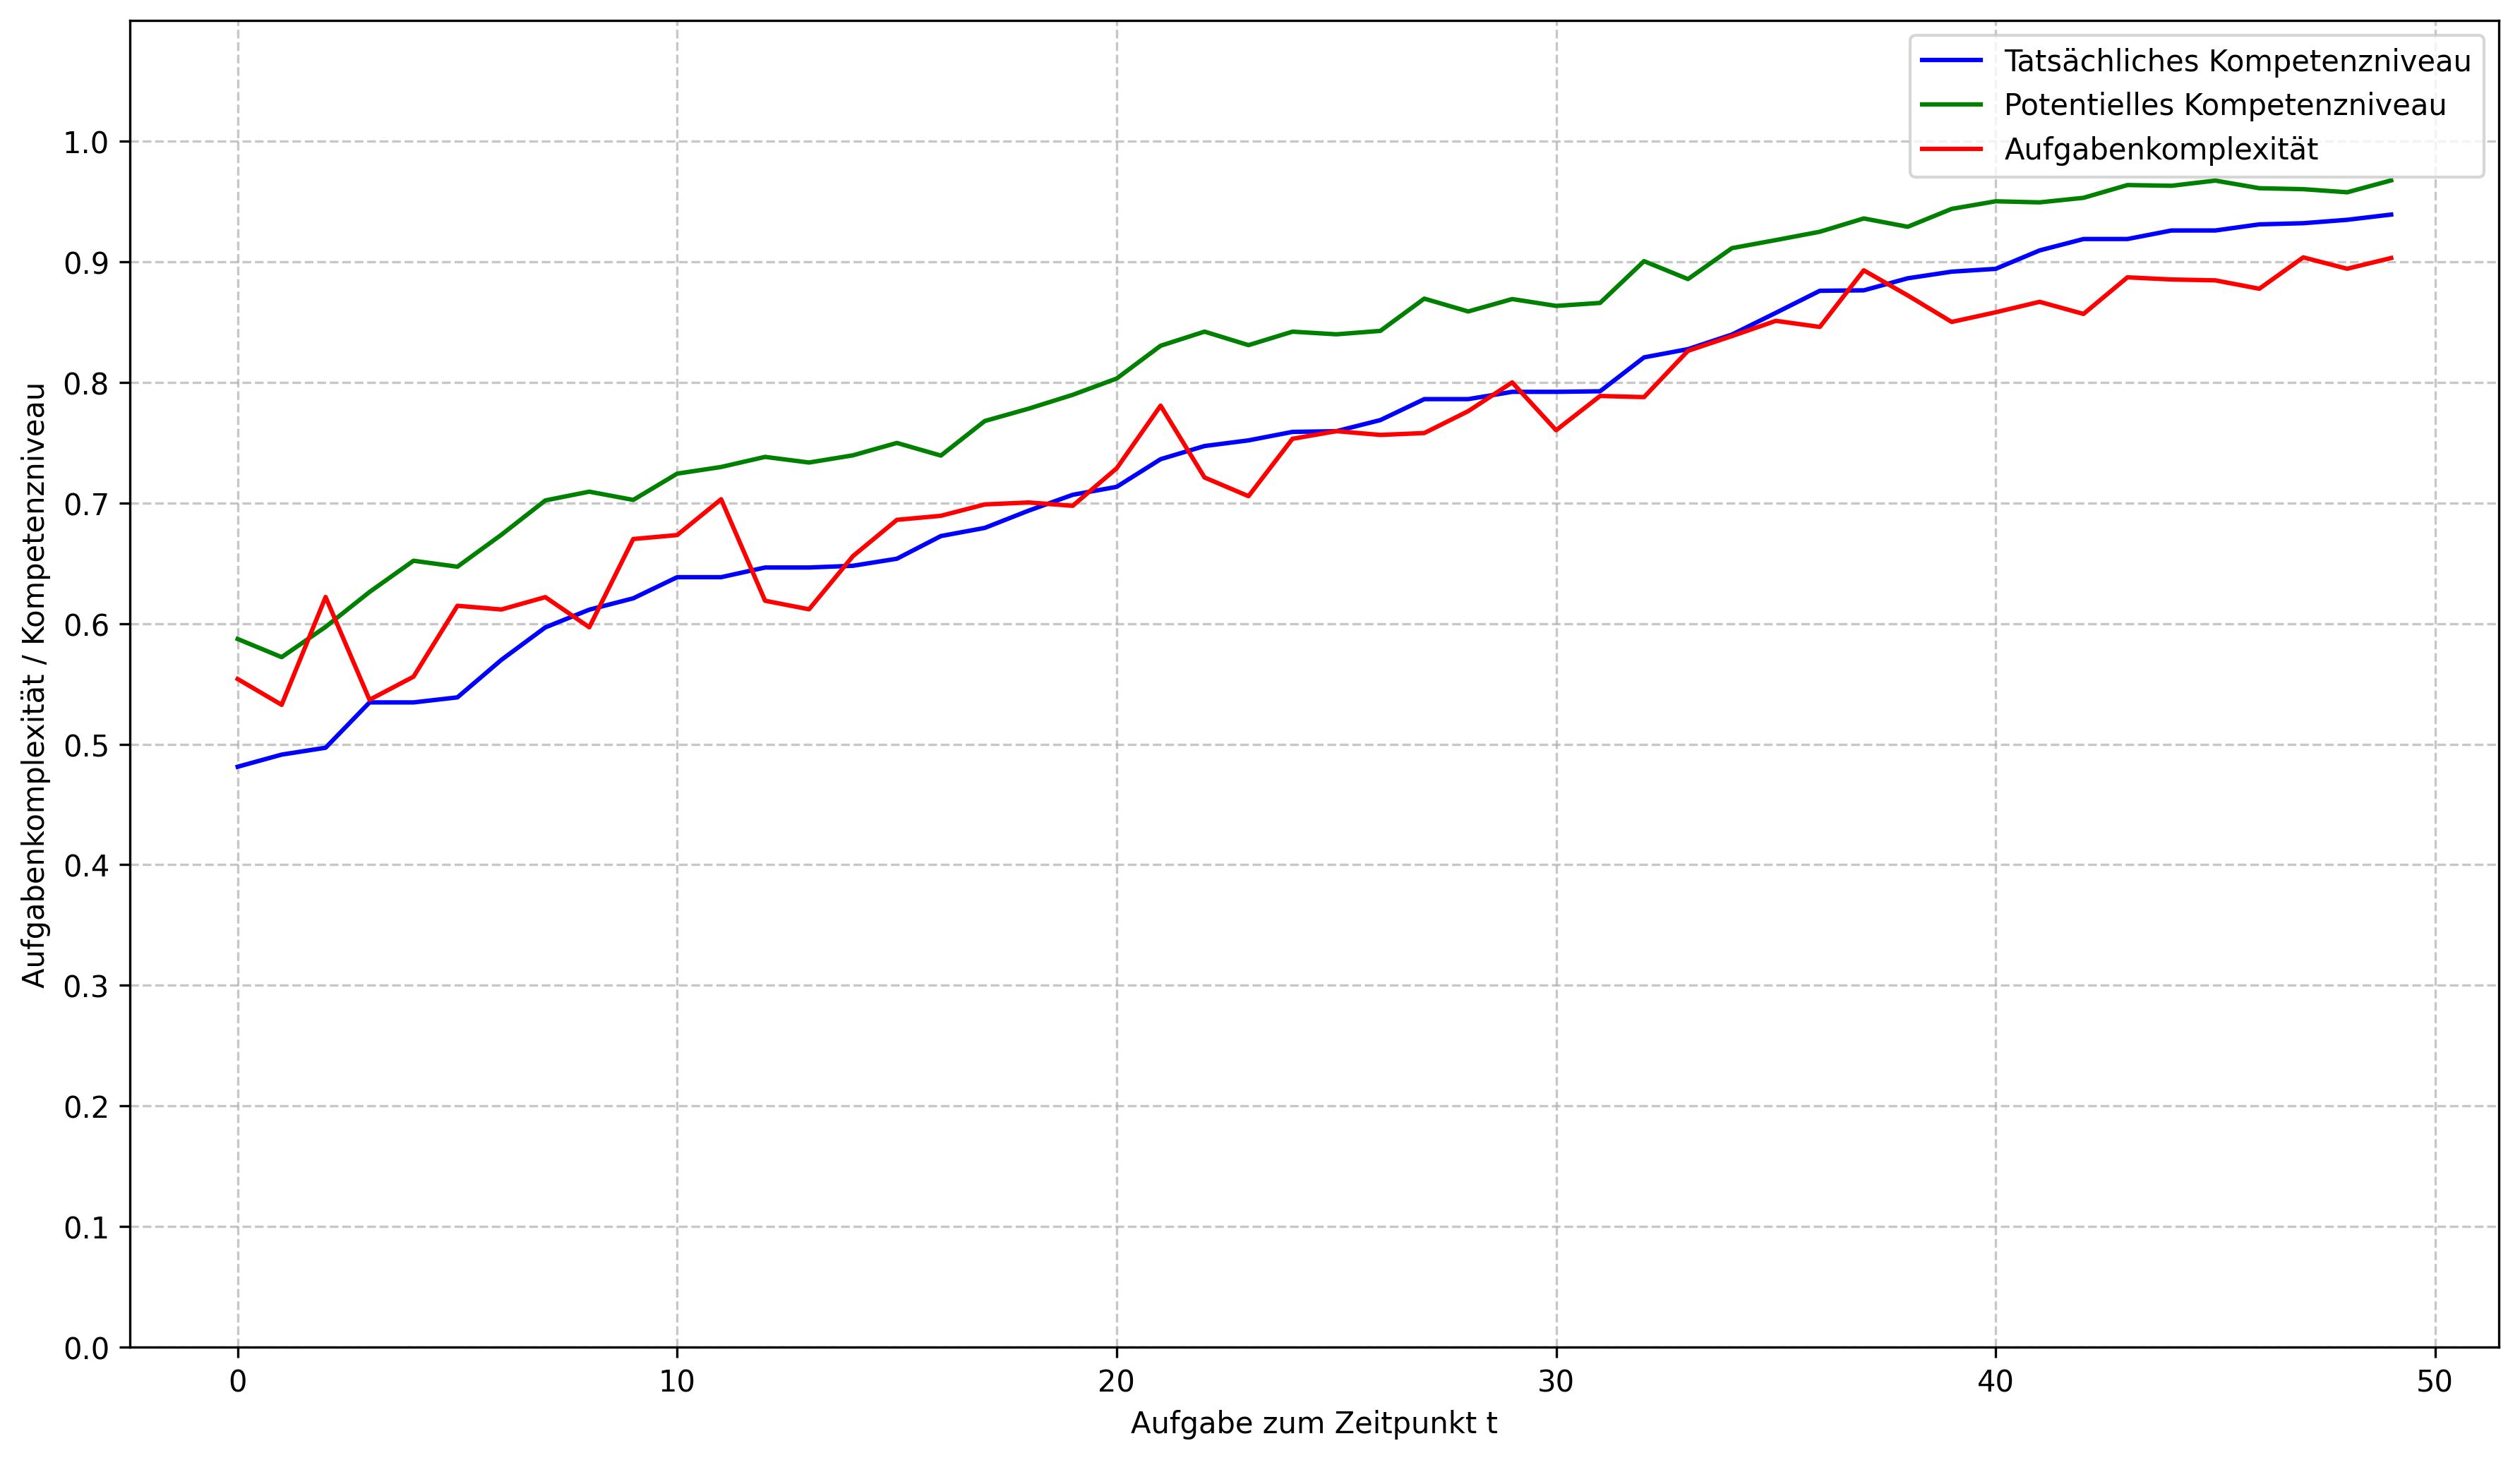

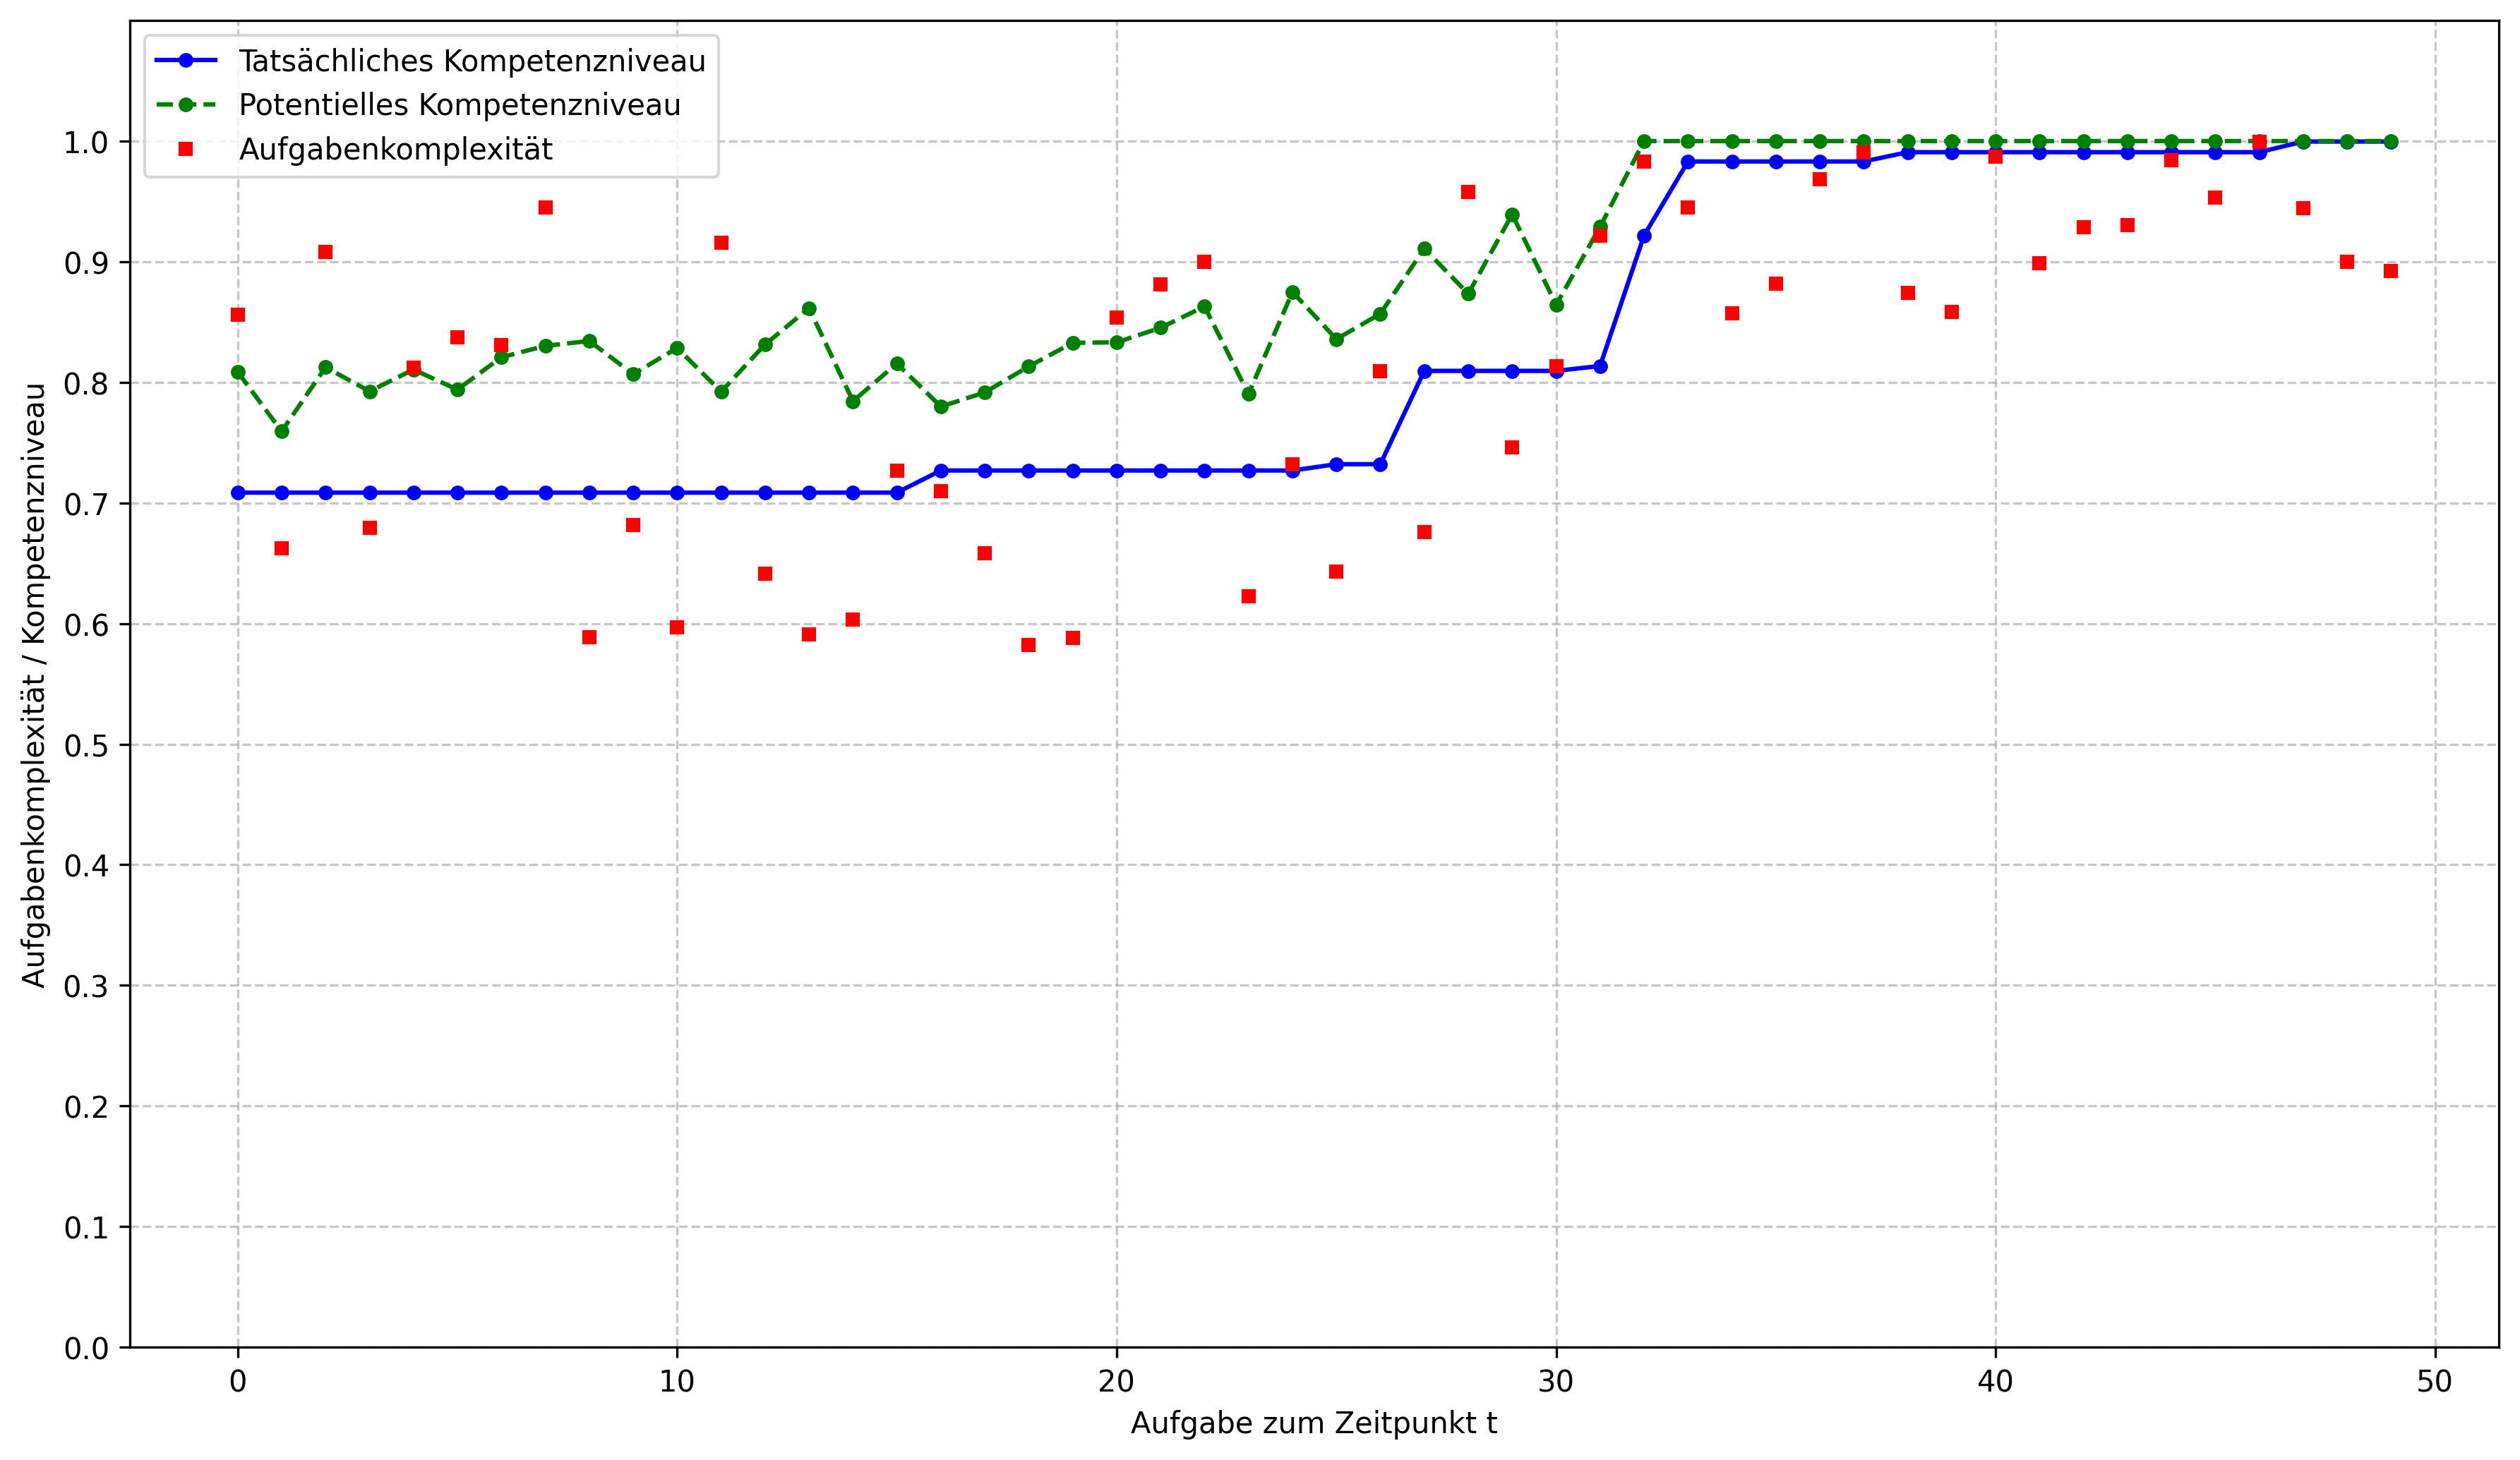

Competency: [np.float64(0.4805525401855062), np.float64(0.4805525401855062), np.float64(0.48360746585132275), np.float64(0.4900398662752878), np.float64(0.5141872090534088), np.float64(0.5282947042666204), np.float64(0.5379154149126281), np.float64(0.5427247230320194), np.float64(0.5611274641734317), np.float64(0.6006137942068155), np.float64(0.6112344653458682), np.float64(0.6136720411654), np.float64(0.640818510400772), np.float64(0.640818510400772), np.float64(0.6432214678420761), np.float64(0.6620227259688062), np.float64(0.6669092060239499), np.float64(0.6708411919635431), np.float64(0.6708411919635431), np.float64(0.68008591495763), np.float64(0.6932681596603438), np.float64(0.7103615470976286), np.float64(0.7177958046172577), np.float64(0.7229657702928156), np.float64(0.7229657702928156), np.float64(0.7269650737479296), np.float64(0.7364181289104291), np.float64(0.7644277285975043), np.float64(0.764449389989257), np.float64(0.7668501439703804), np.float64(0.7786763282780421), np

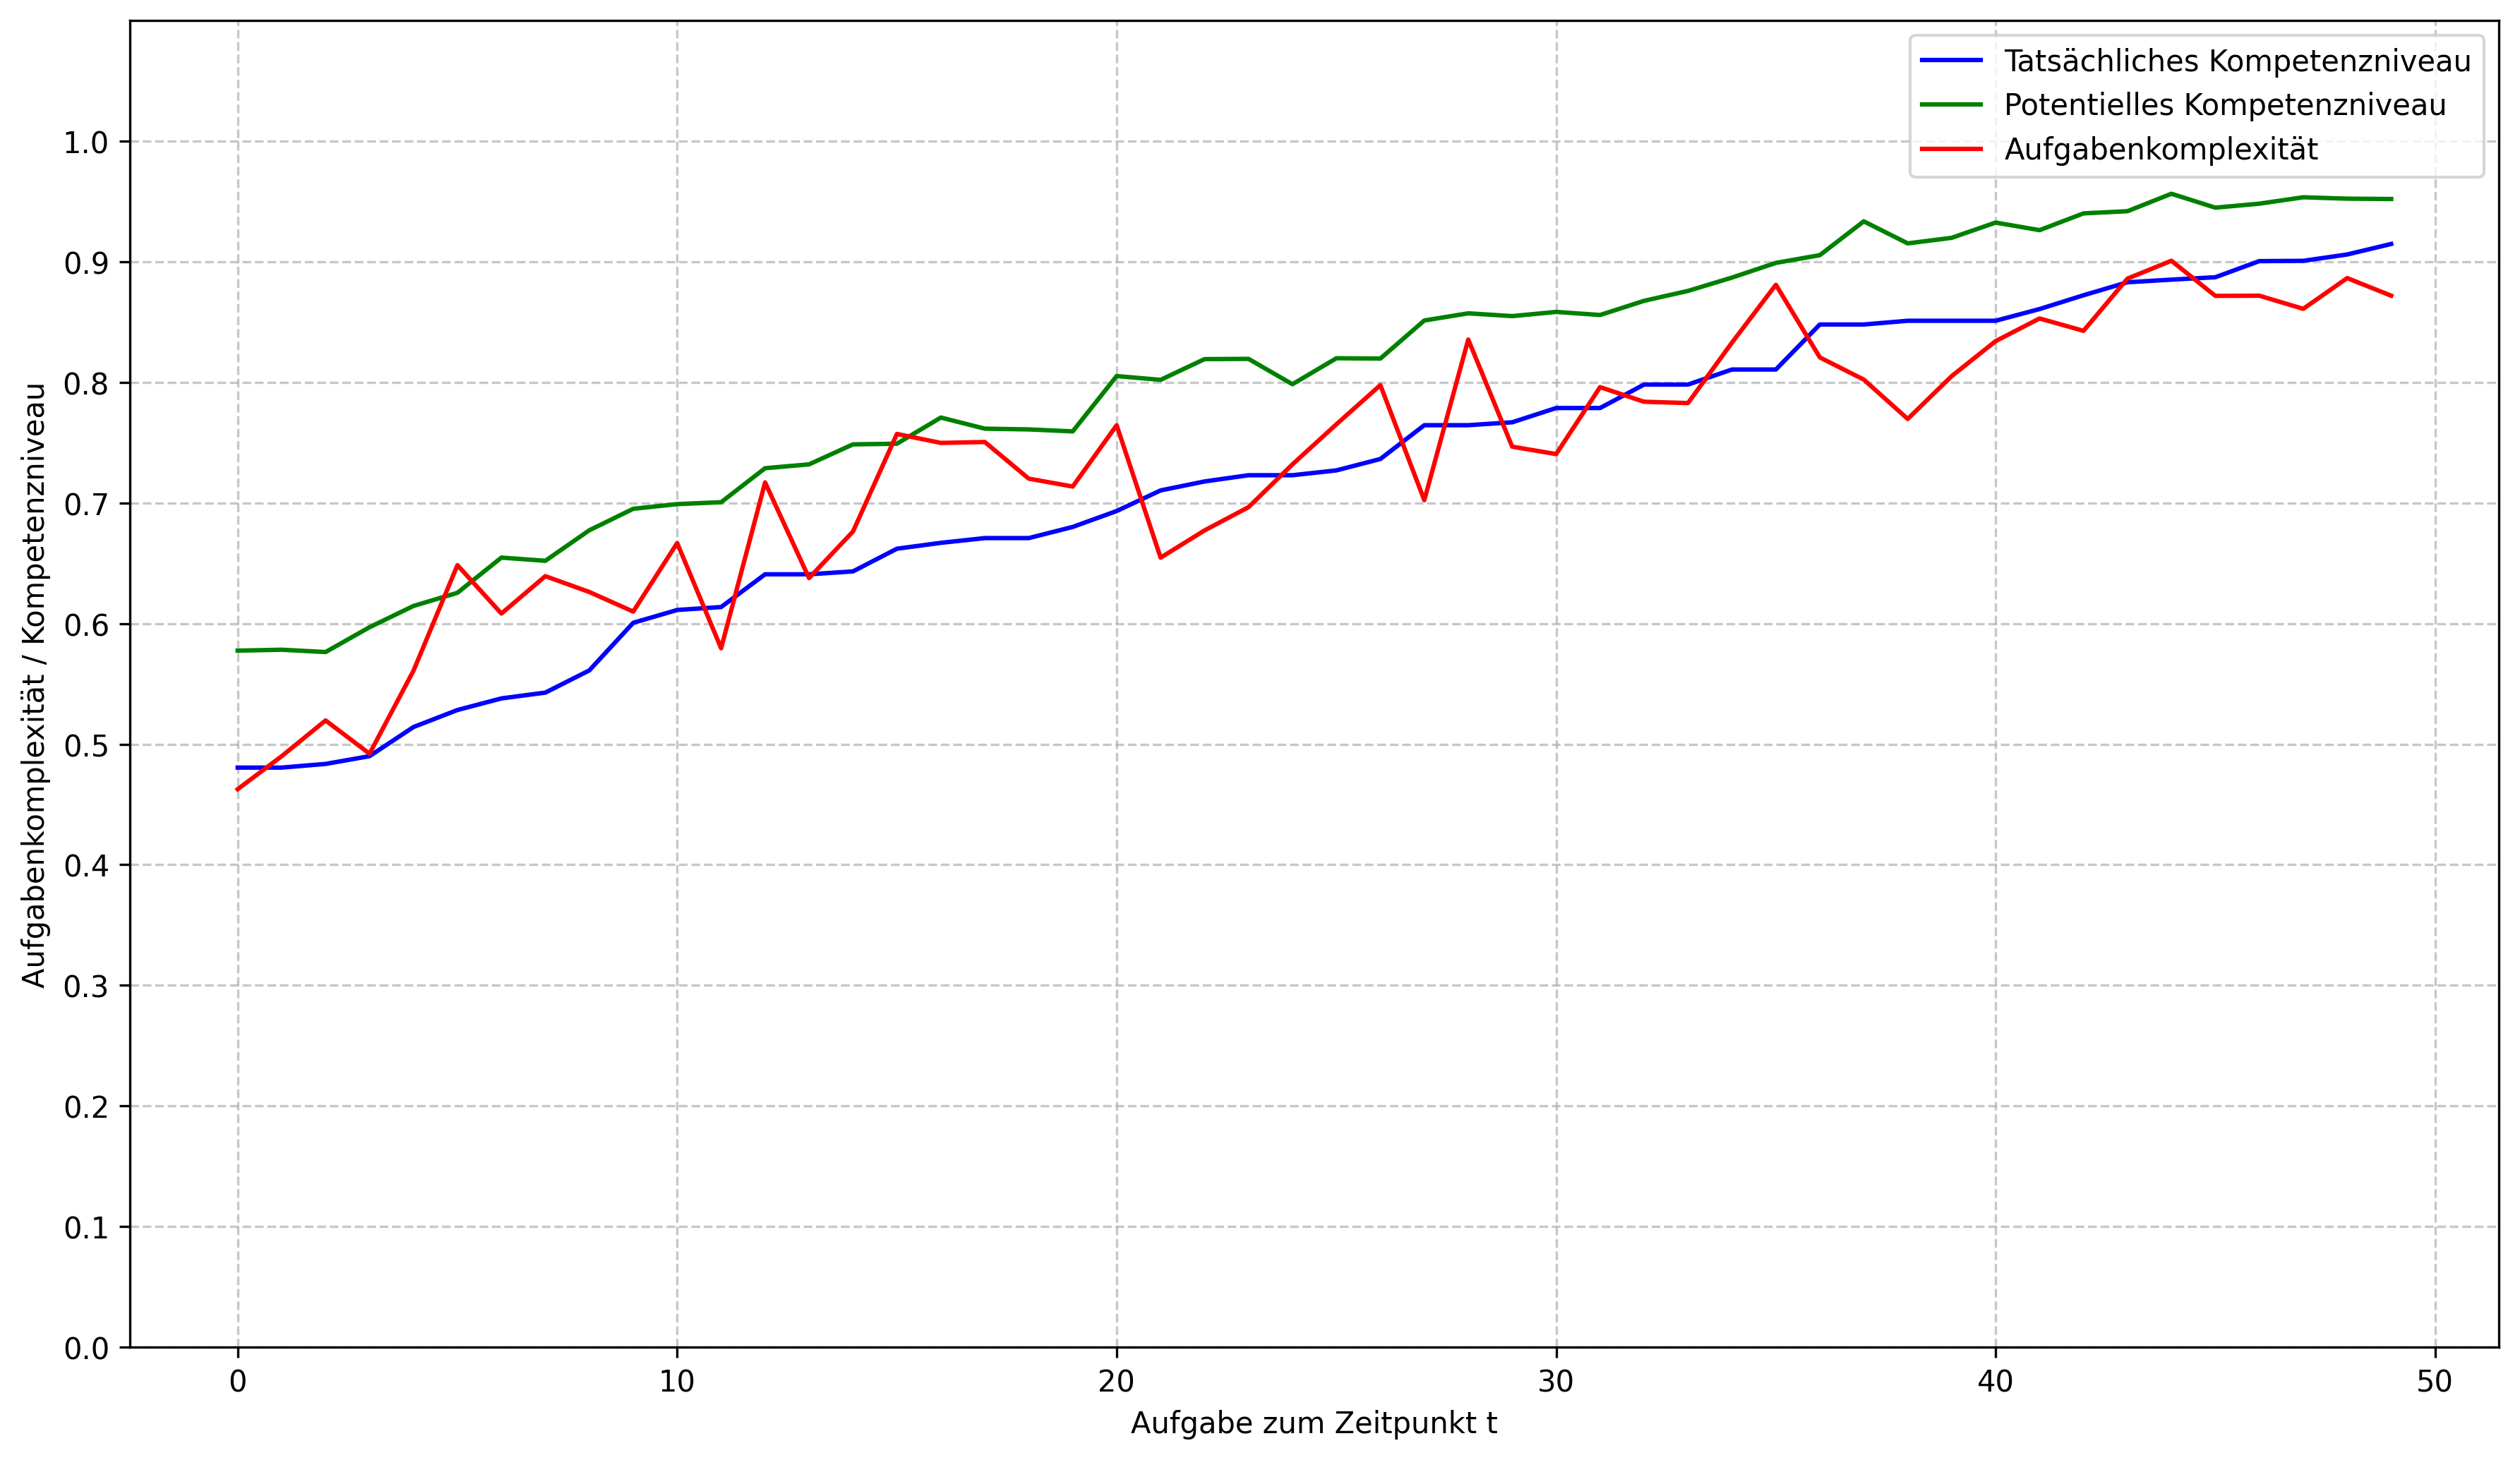

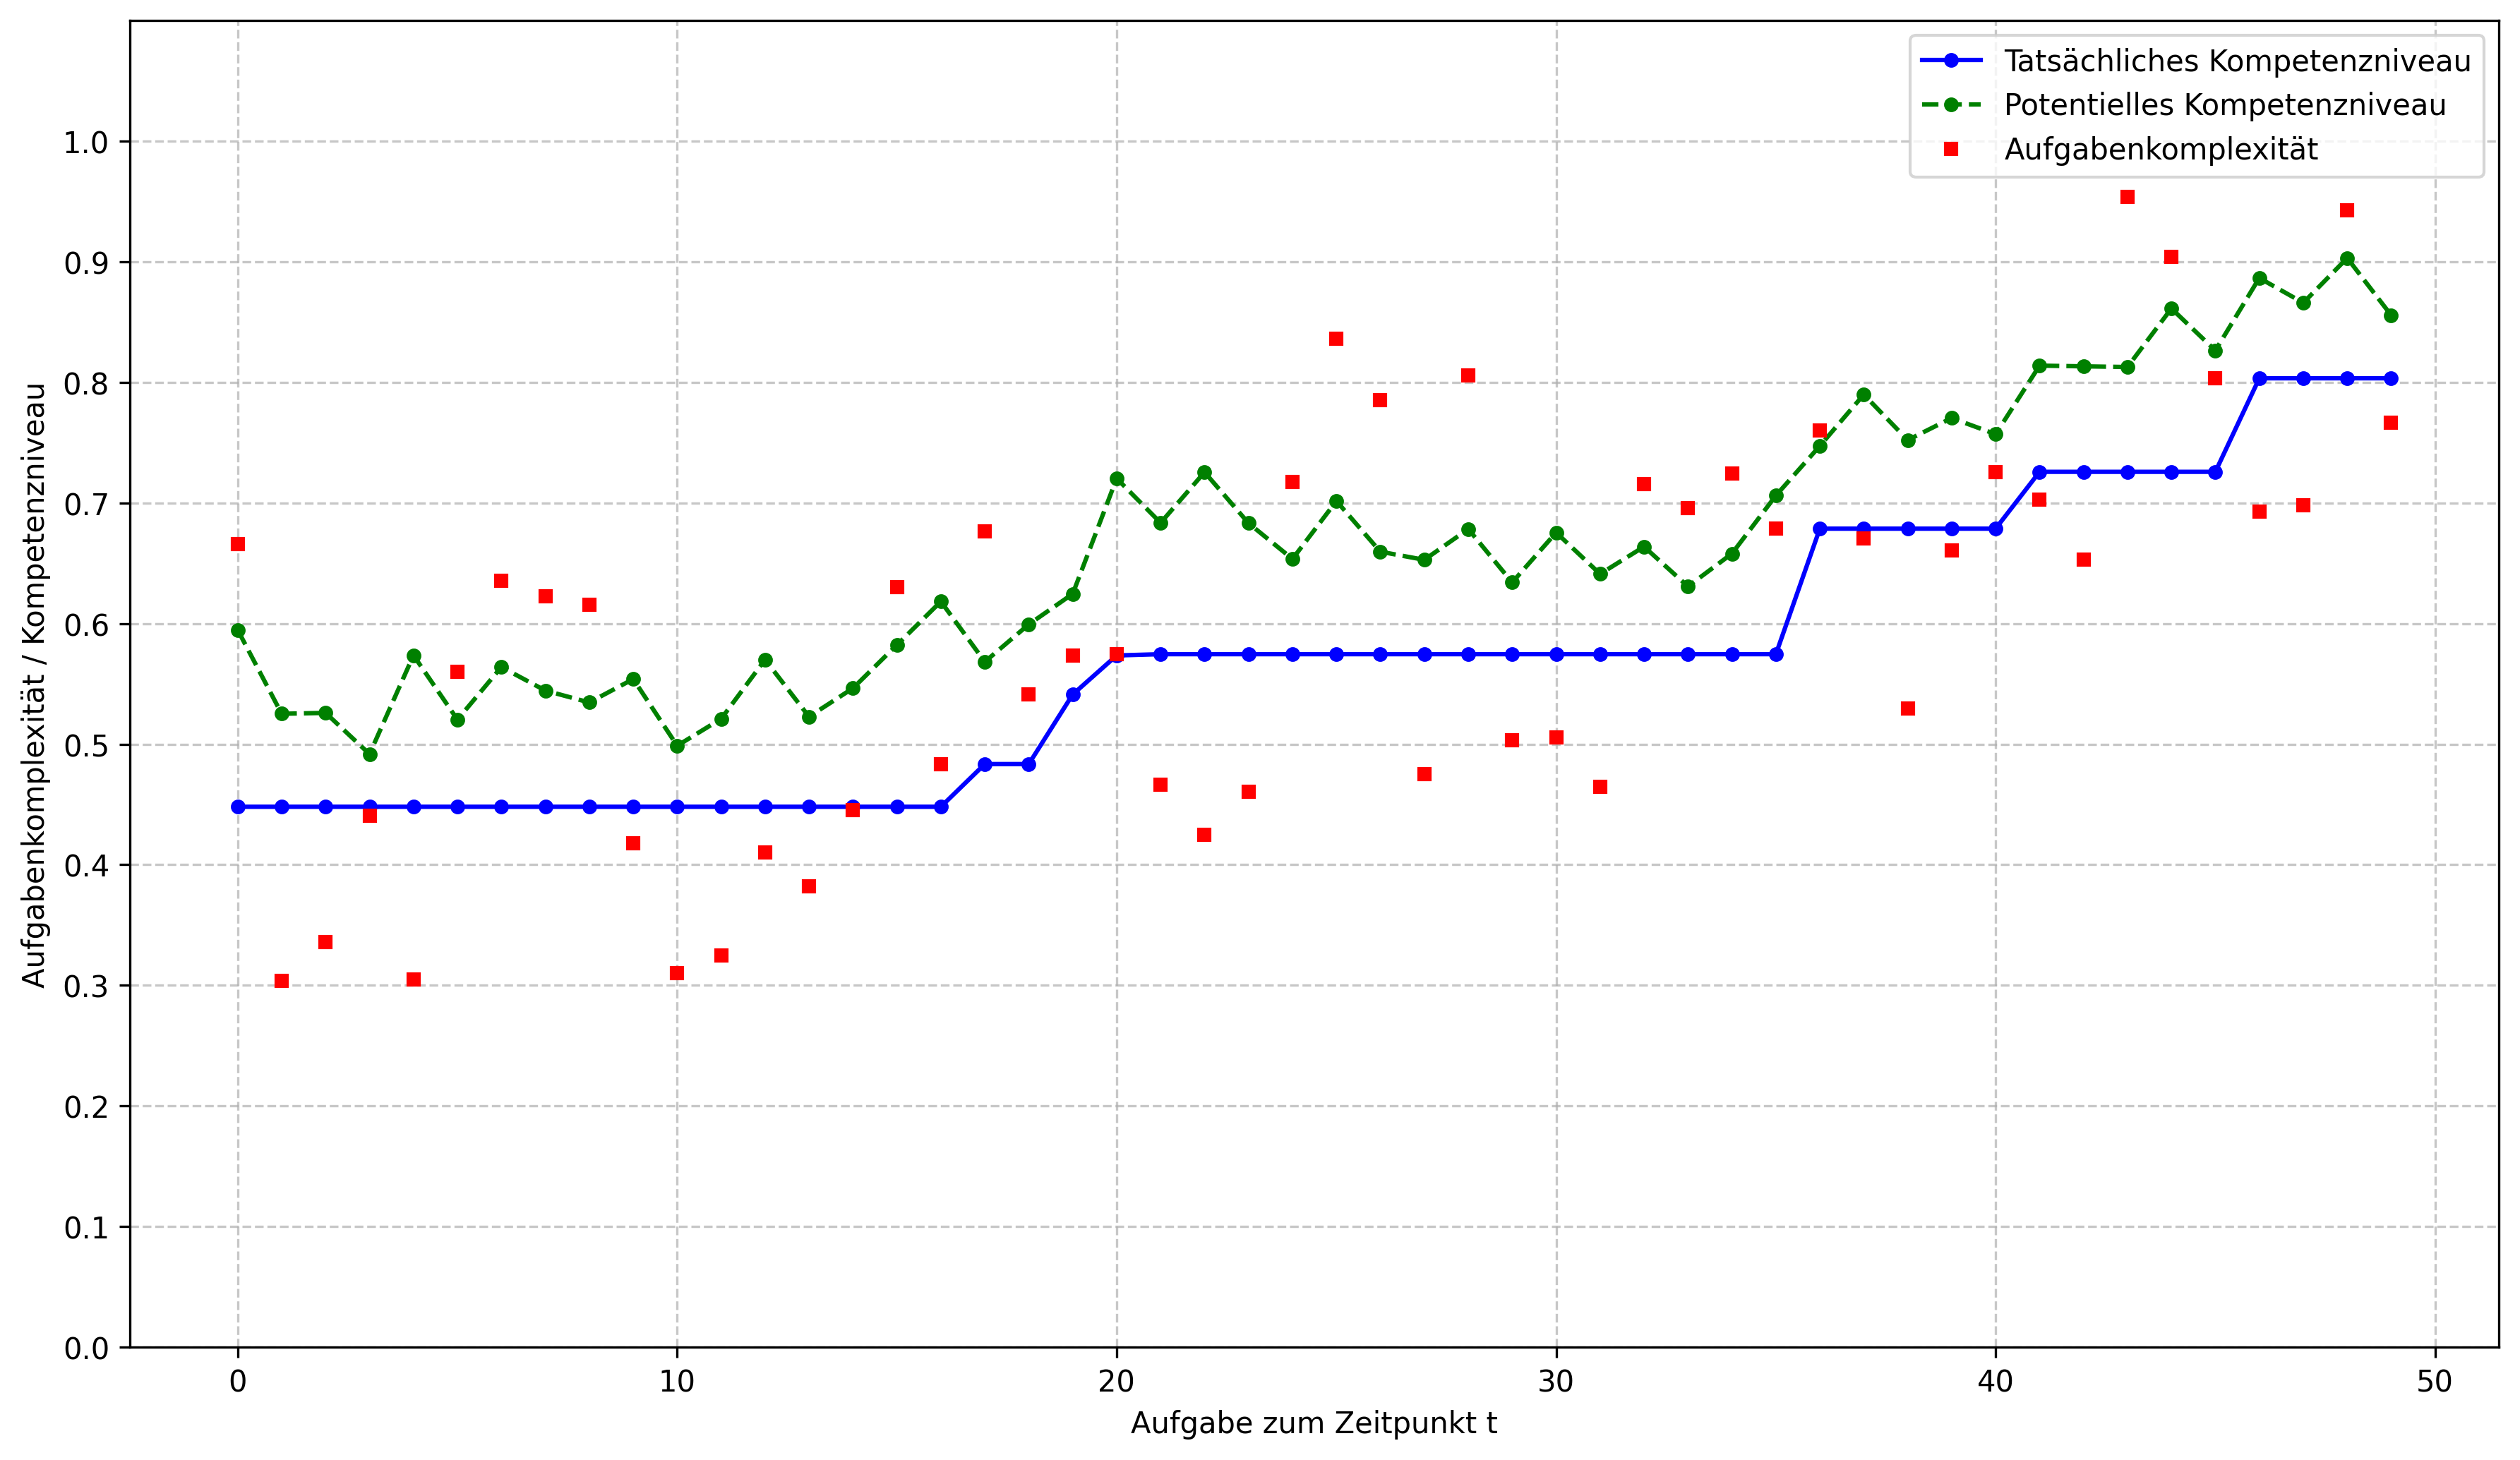

Competency: [np.float64(0.4594999013175351), np.float64(0.49690143649532637), np.float64(0.5065373563879204), np.float64(0.5094796062031794), np.float64(0.5355676354184906), np.float64(0.5461059806190552), np.float64(0.550001306205661), np.float64(0.5558622842161186), np.float64(0.5558622842161186), np.float64(0.5605548365579224), np.float64(0.5724999586132283), np.float64(0.5895708253487902), np.float64(0.595224051881188), np.float64(0.6264985333377473), np.float64(0.6373252841826367), np.float64(0.6481391960498137), np.float64(0.6481391960498137), np.float64(0.6604180051998972), np.float64(0.6613962400889775), np.float64(0.6613962400889775), np.float64(0.6693576664461588), np.float64(0.6825886797154415), np.float64(0.7020180806186195), np.float64(0.7356595006956552), np.float64(0.7578967015741939), np.float64(0.7828462876674345), np.float64(0.78765423380554), np.float64(0.8045352765608268), np.float64(0.8164252026728183), np.float64(0.8276705293022455), np.float64(0.8315154500473959)

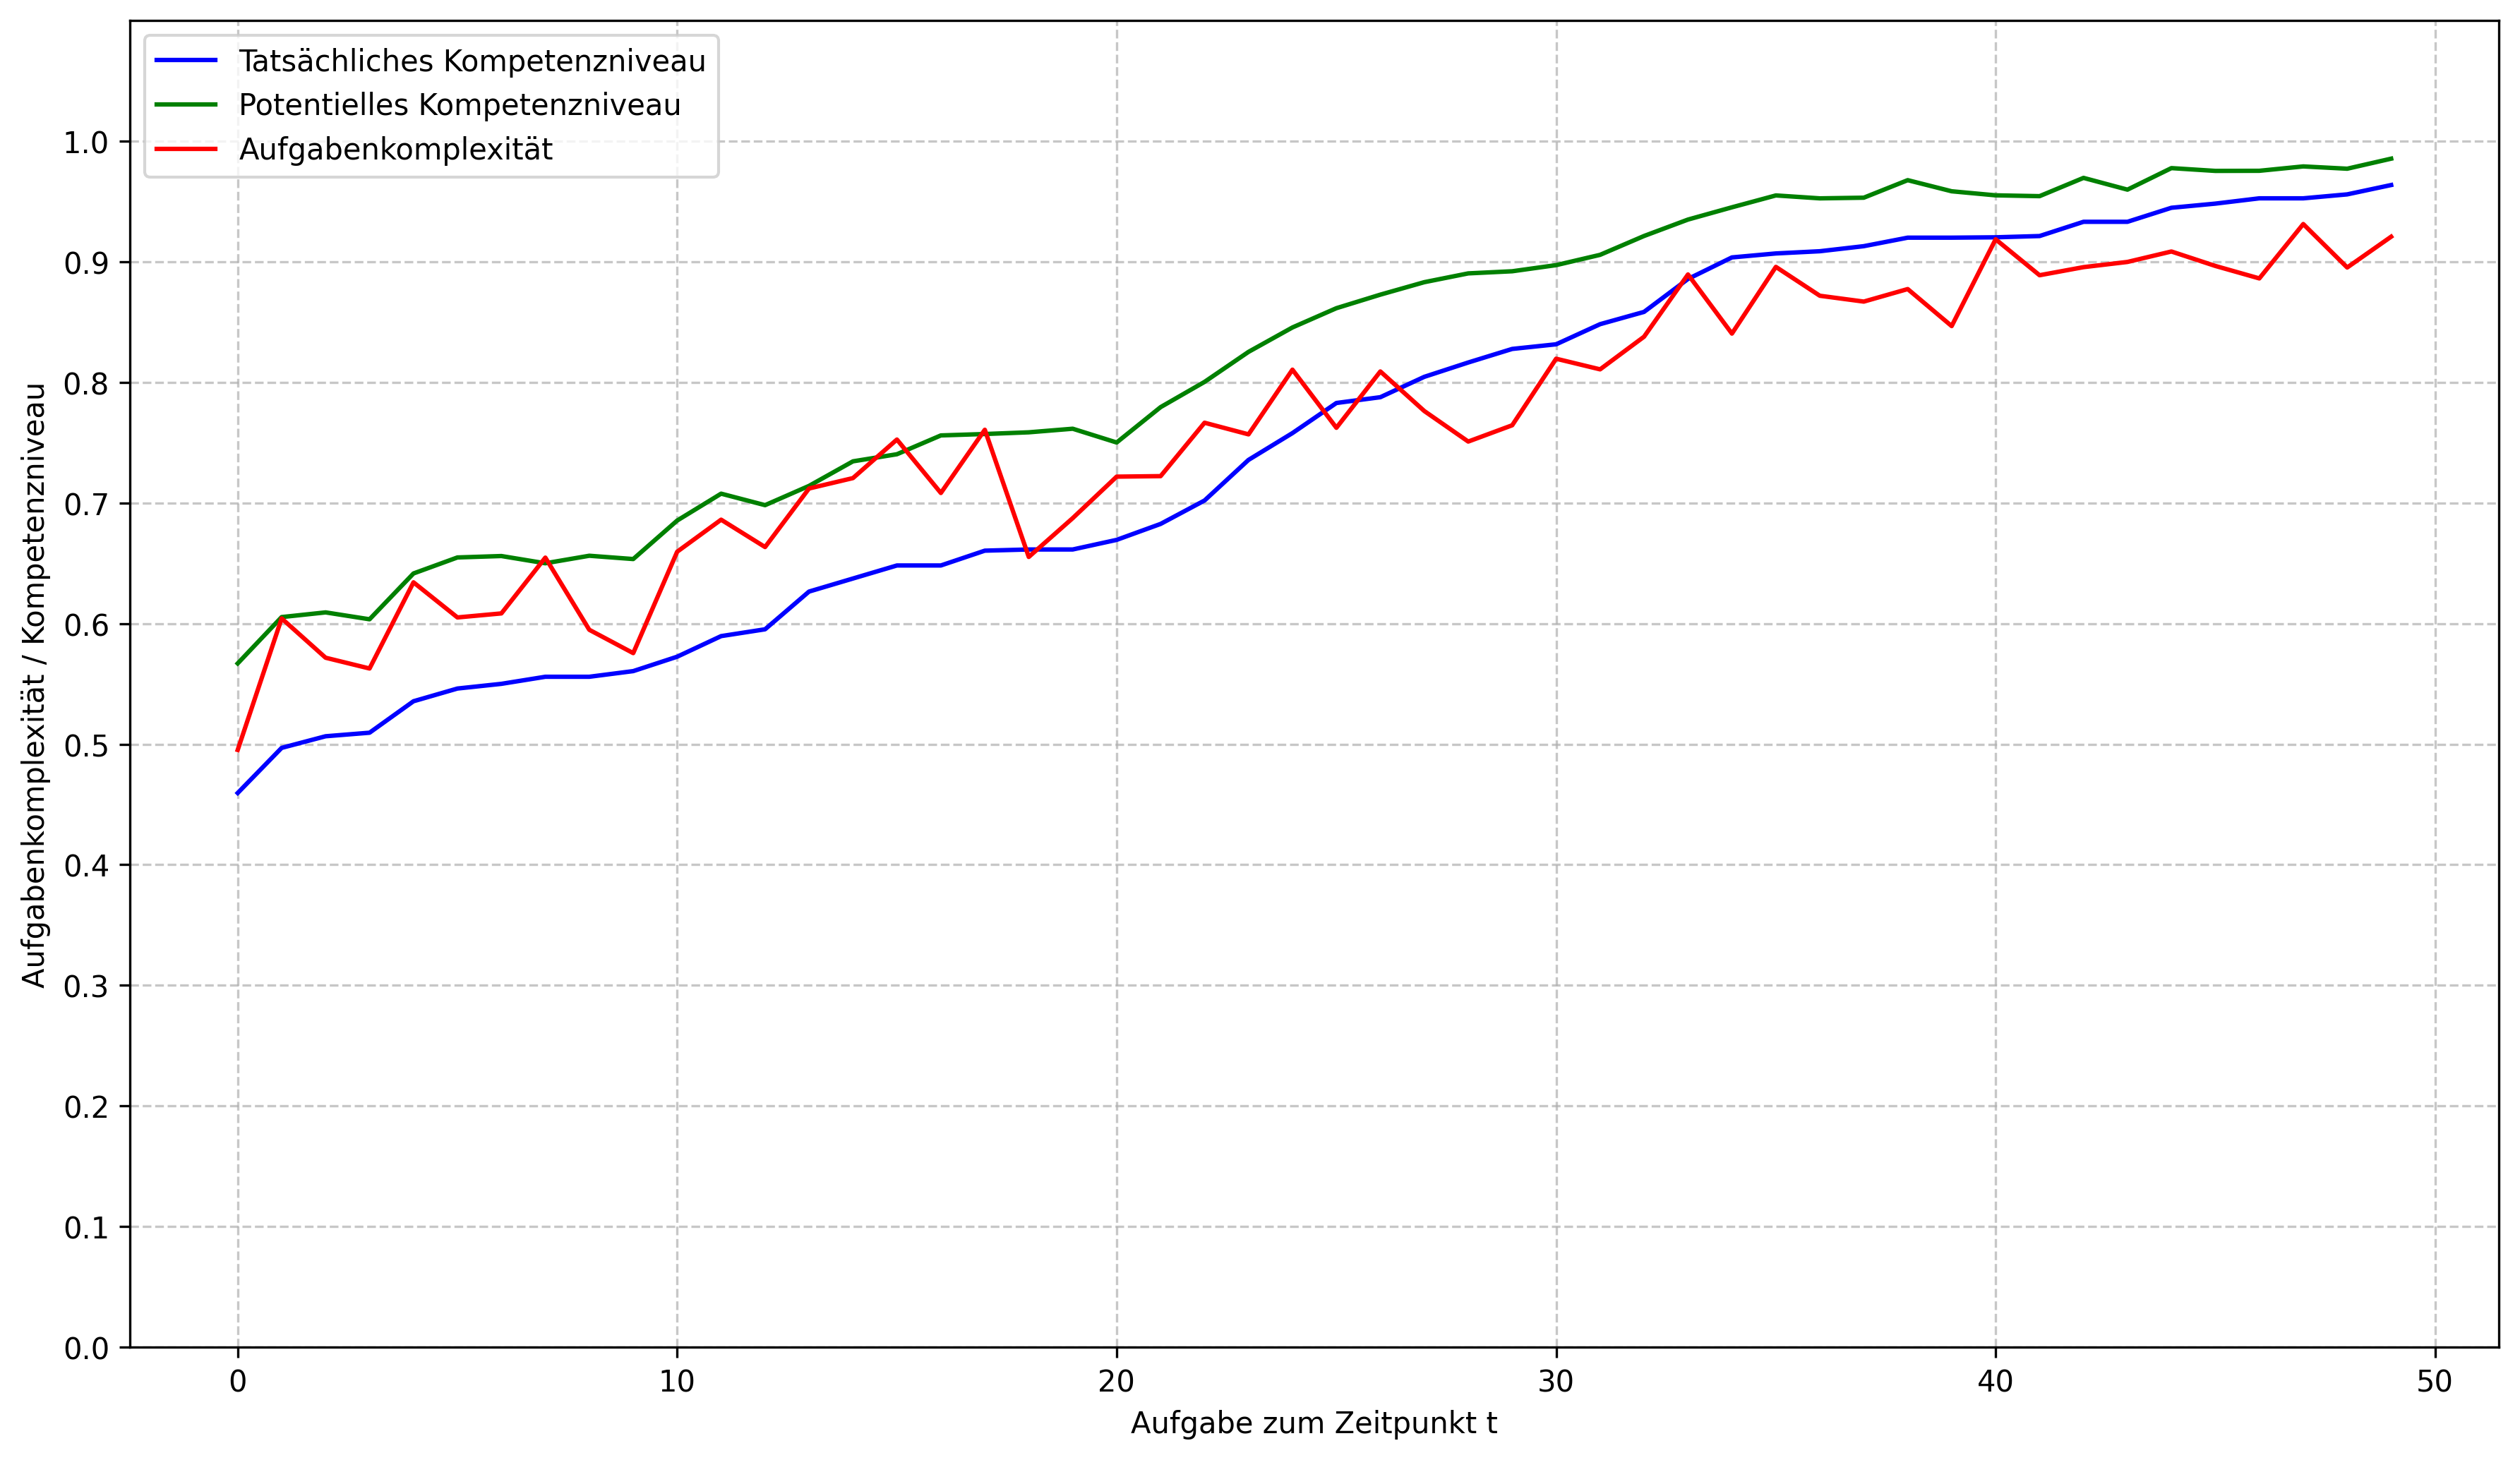

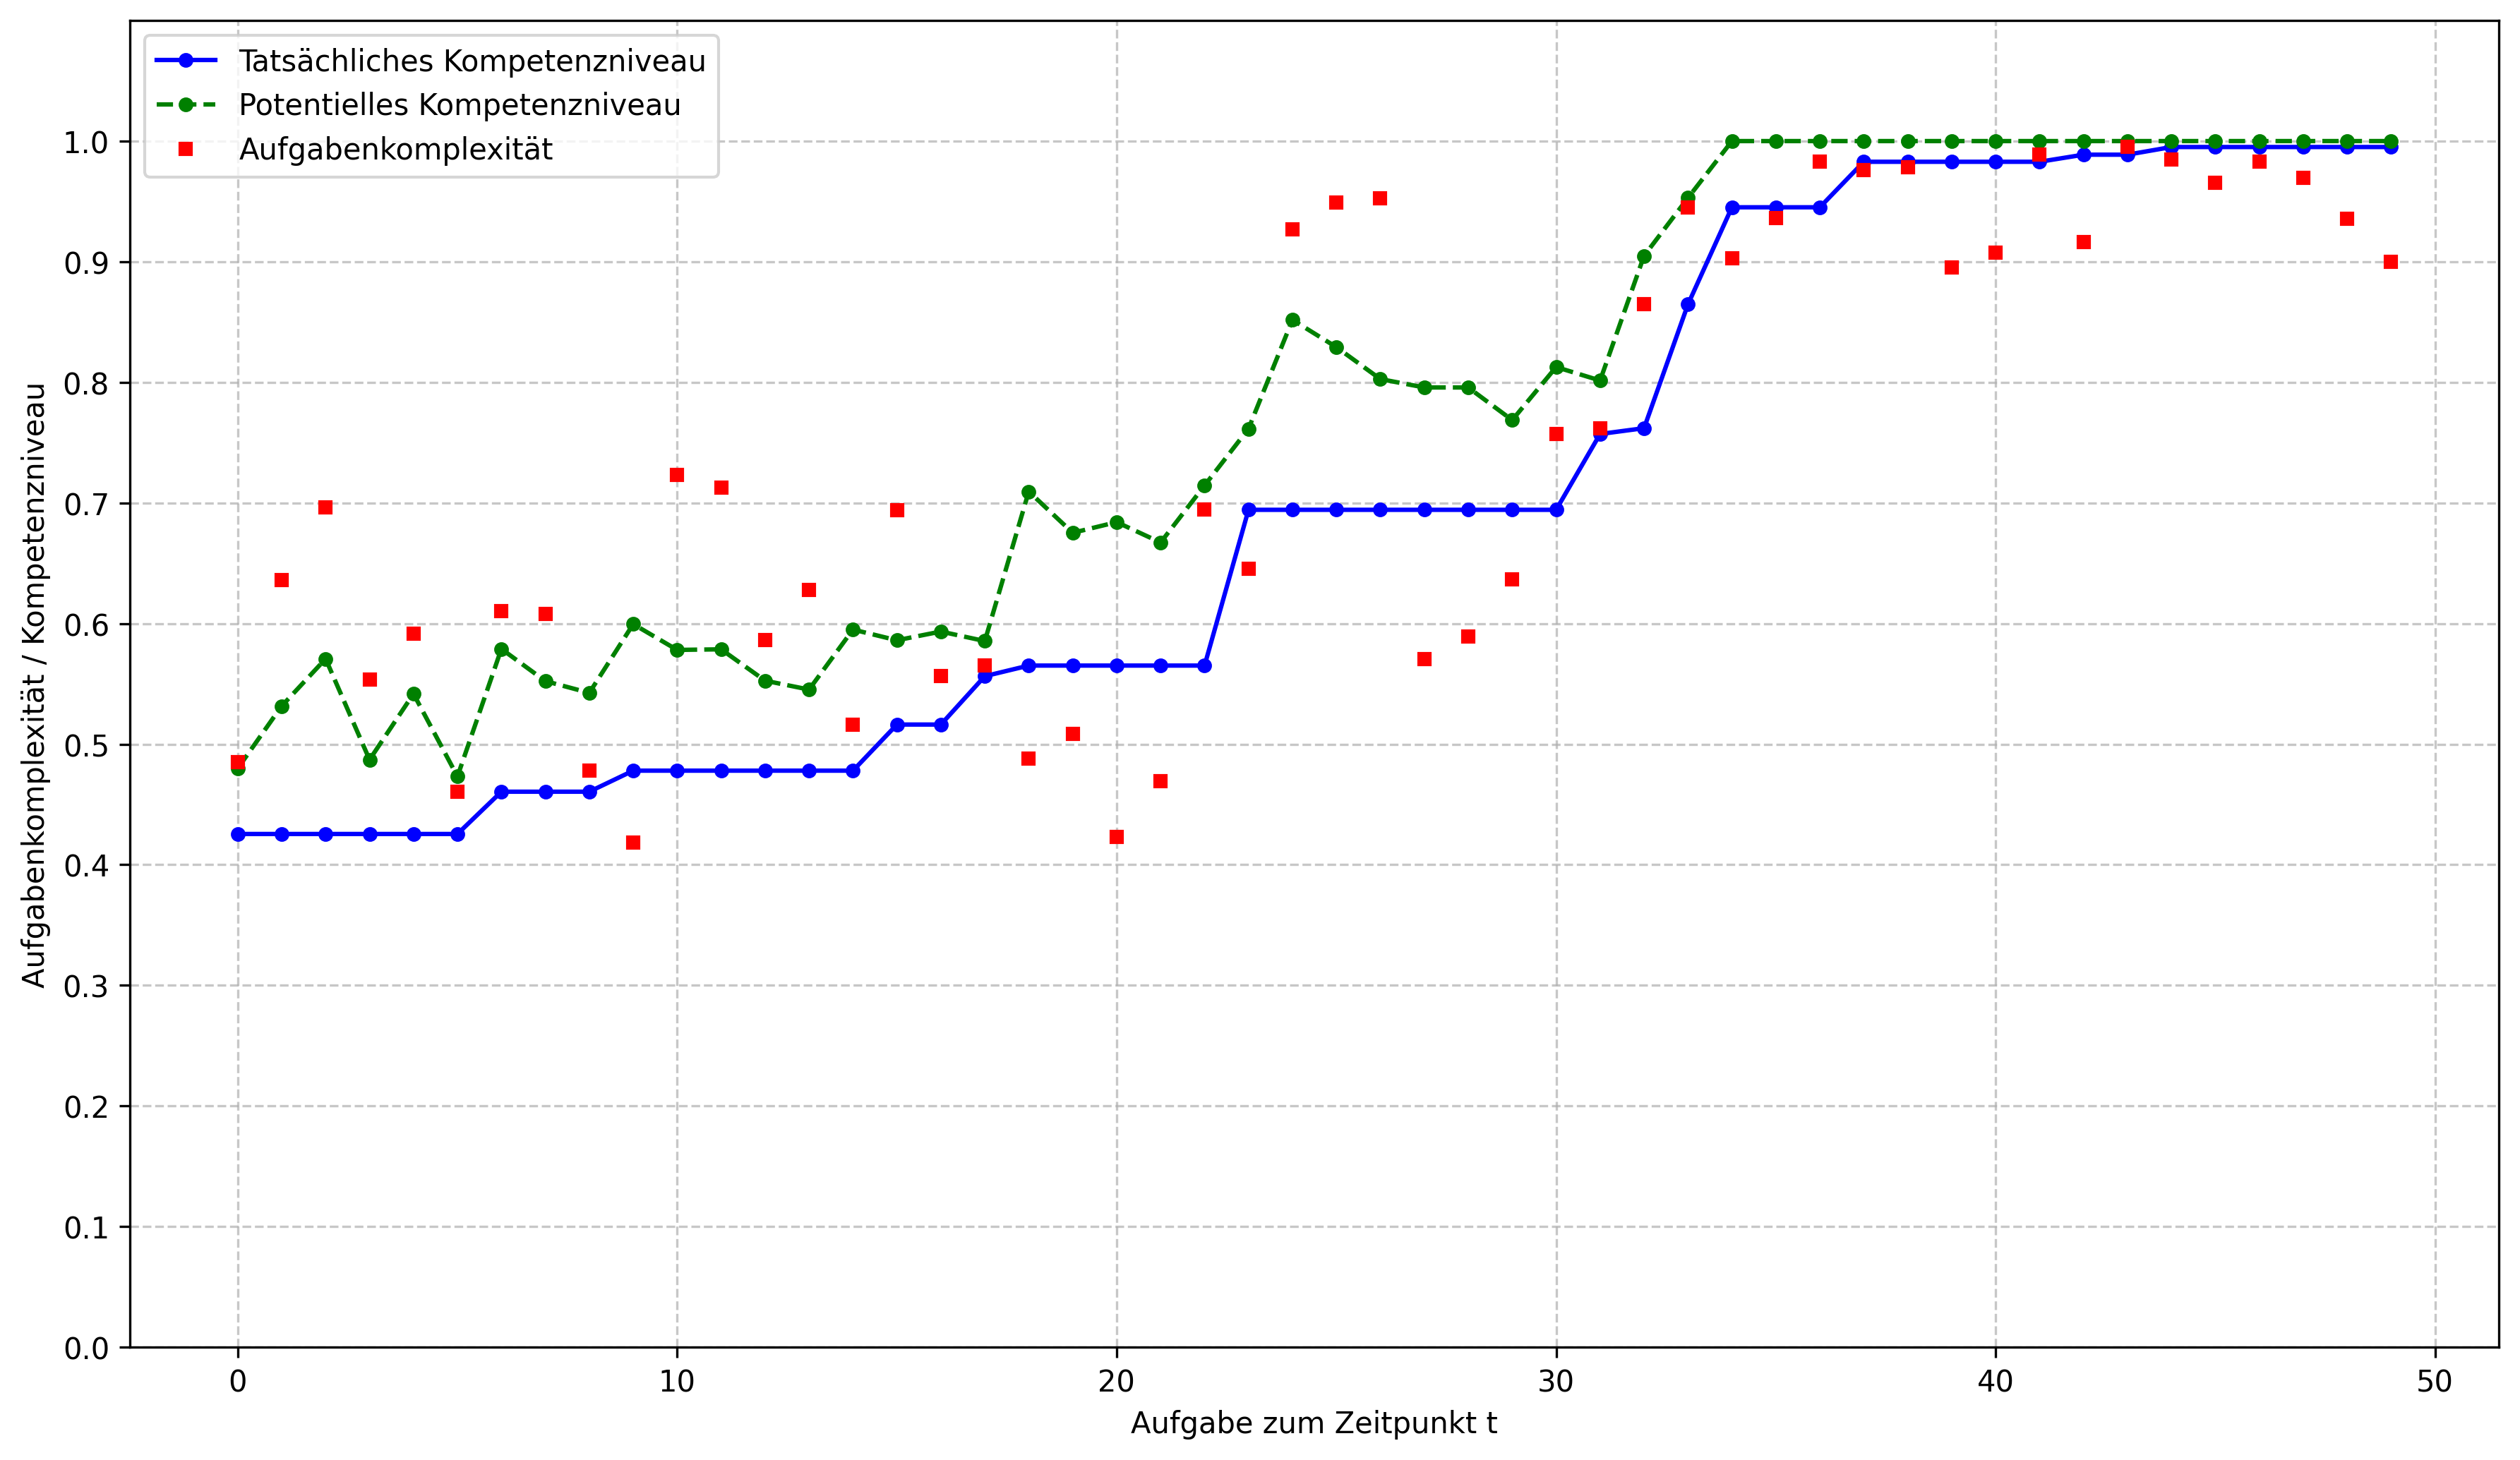

Competency: [np.float64(0.47517507488356414), np.float64(0.477886231776066), np.float64(0.47826493639834894), np.float64(0.479960687097856), np.float64(0.4951249818071031), np.float64(0.5346896621024656), np.float64(0.5477681210594214), np.float64(0.5533139375383088), np.float64(0.581977175491963), np.float64(0.5941034174514276), np.float64(0.5985774165277705), np.float64(0.6013760323784517), np.float64(0.6038358338264076), np.float64(0.6060379071737722), np.float64(0.6227451942717092), np.float64(0.6432706187673396), np.float64(0.6432706187673396), np.float64(0.666285636258166), np.float64(0.6886906332690944), np.float64(0.698717489292818), np.float64(0.7093536226457889), np.float64(0.7245930852873781), np.float64(0.7590489690373806), np.float64(0.7681365947739841), np.float64(0.7825515181375974), np.float64(0.7825515181375974), np.float64(0.8023962471173469), np.float64(0.819106608522122), np.float64(0.8364952514506798), np.float64(0.8474079491909047), np.float64(0.8545576492028485),

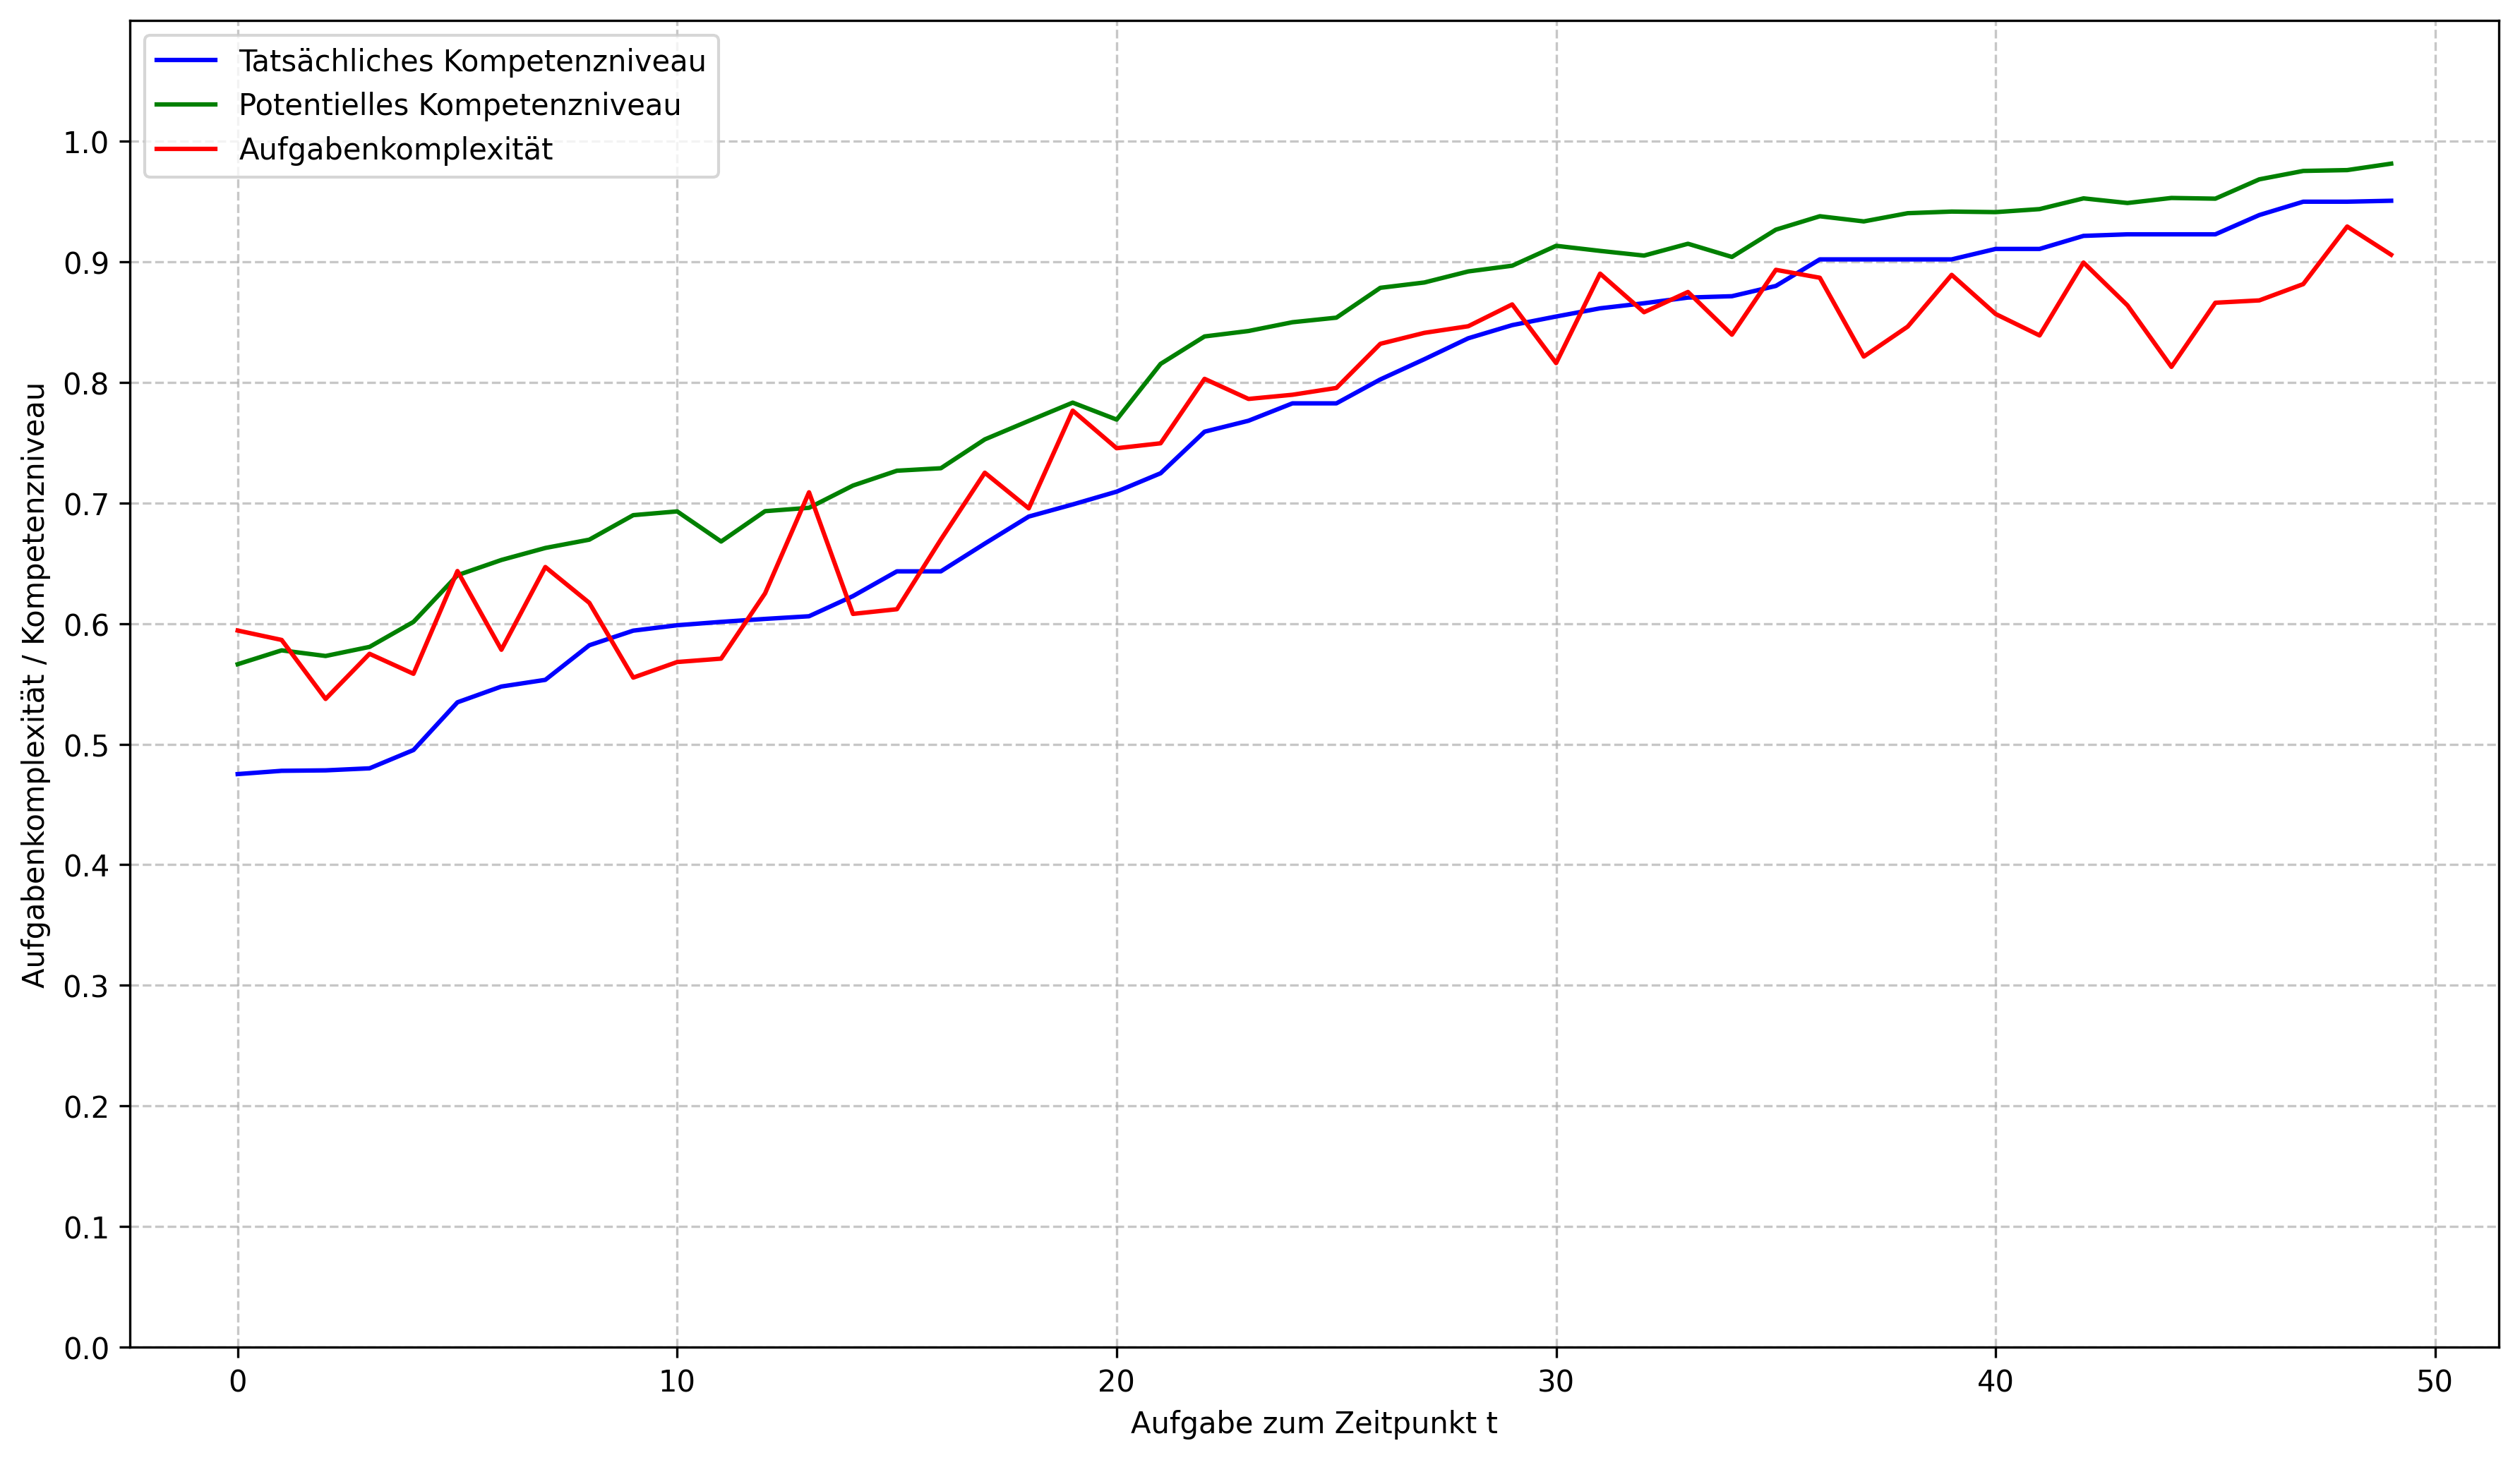

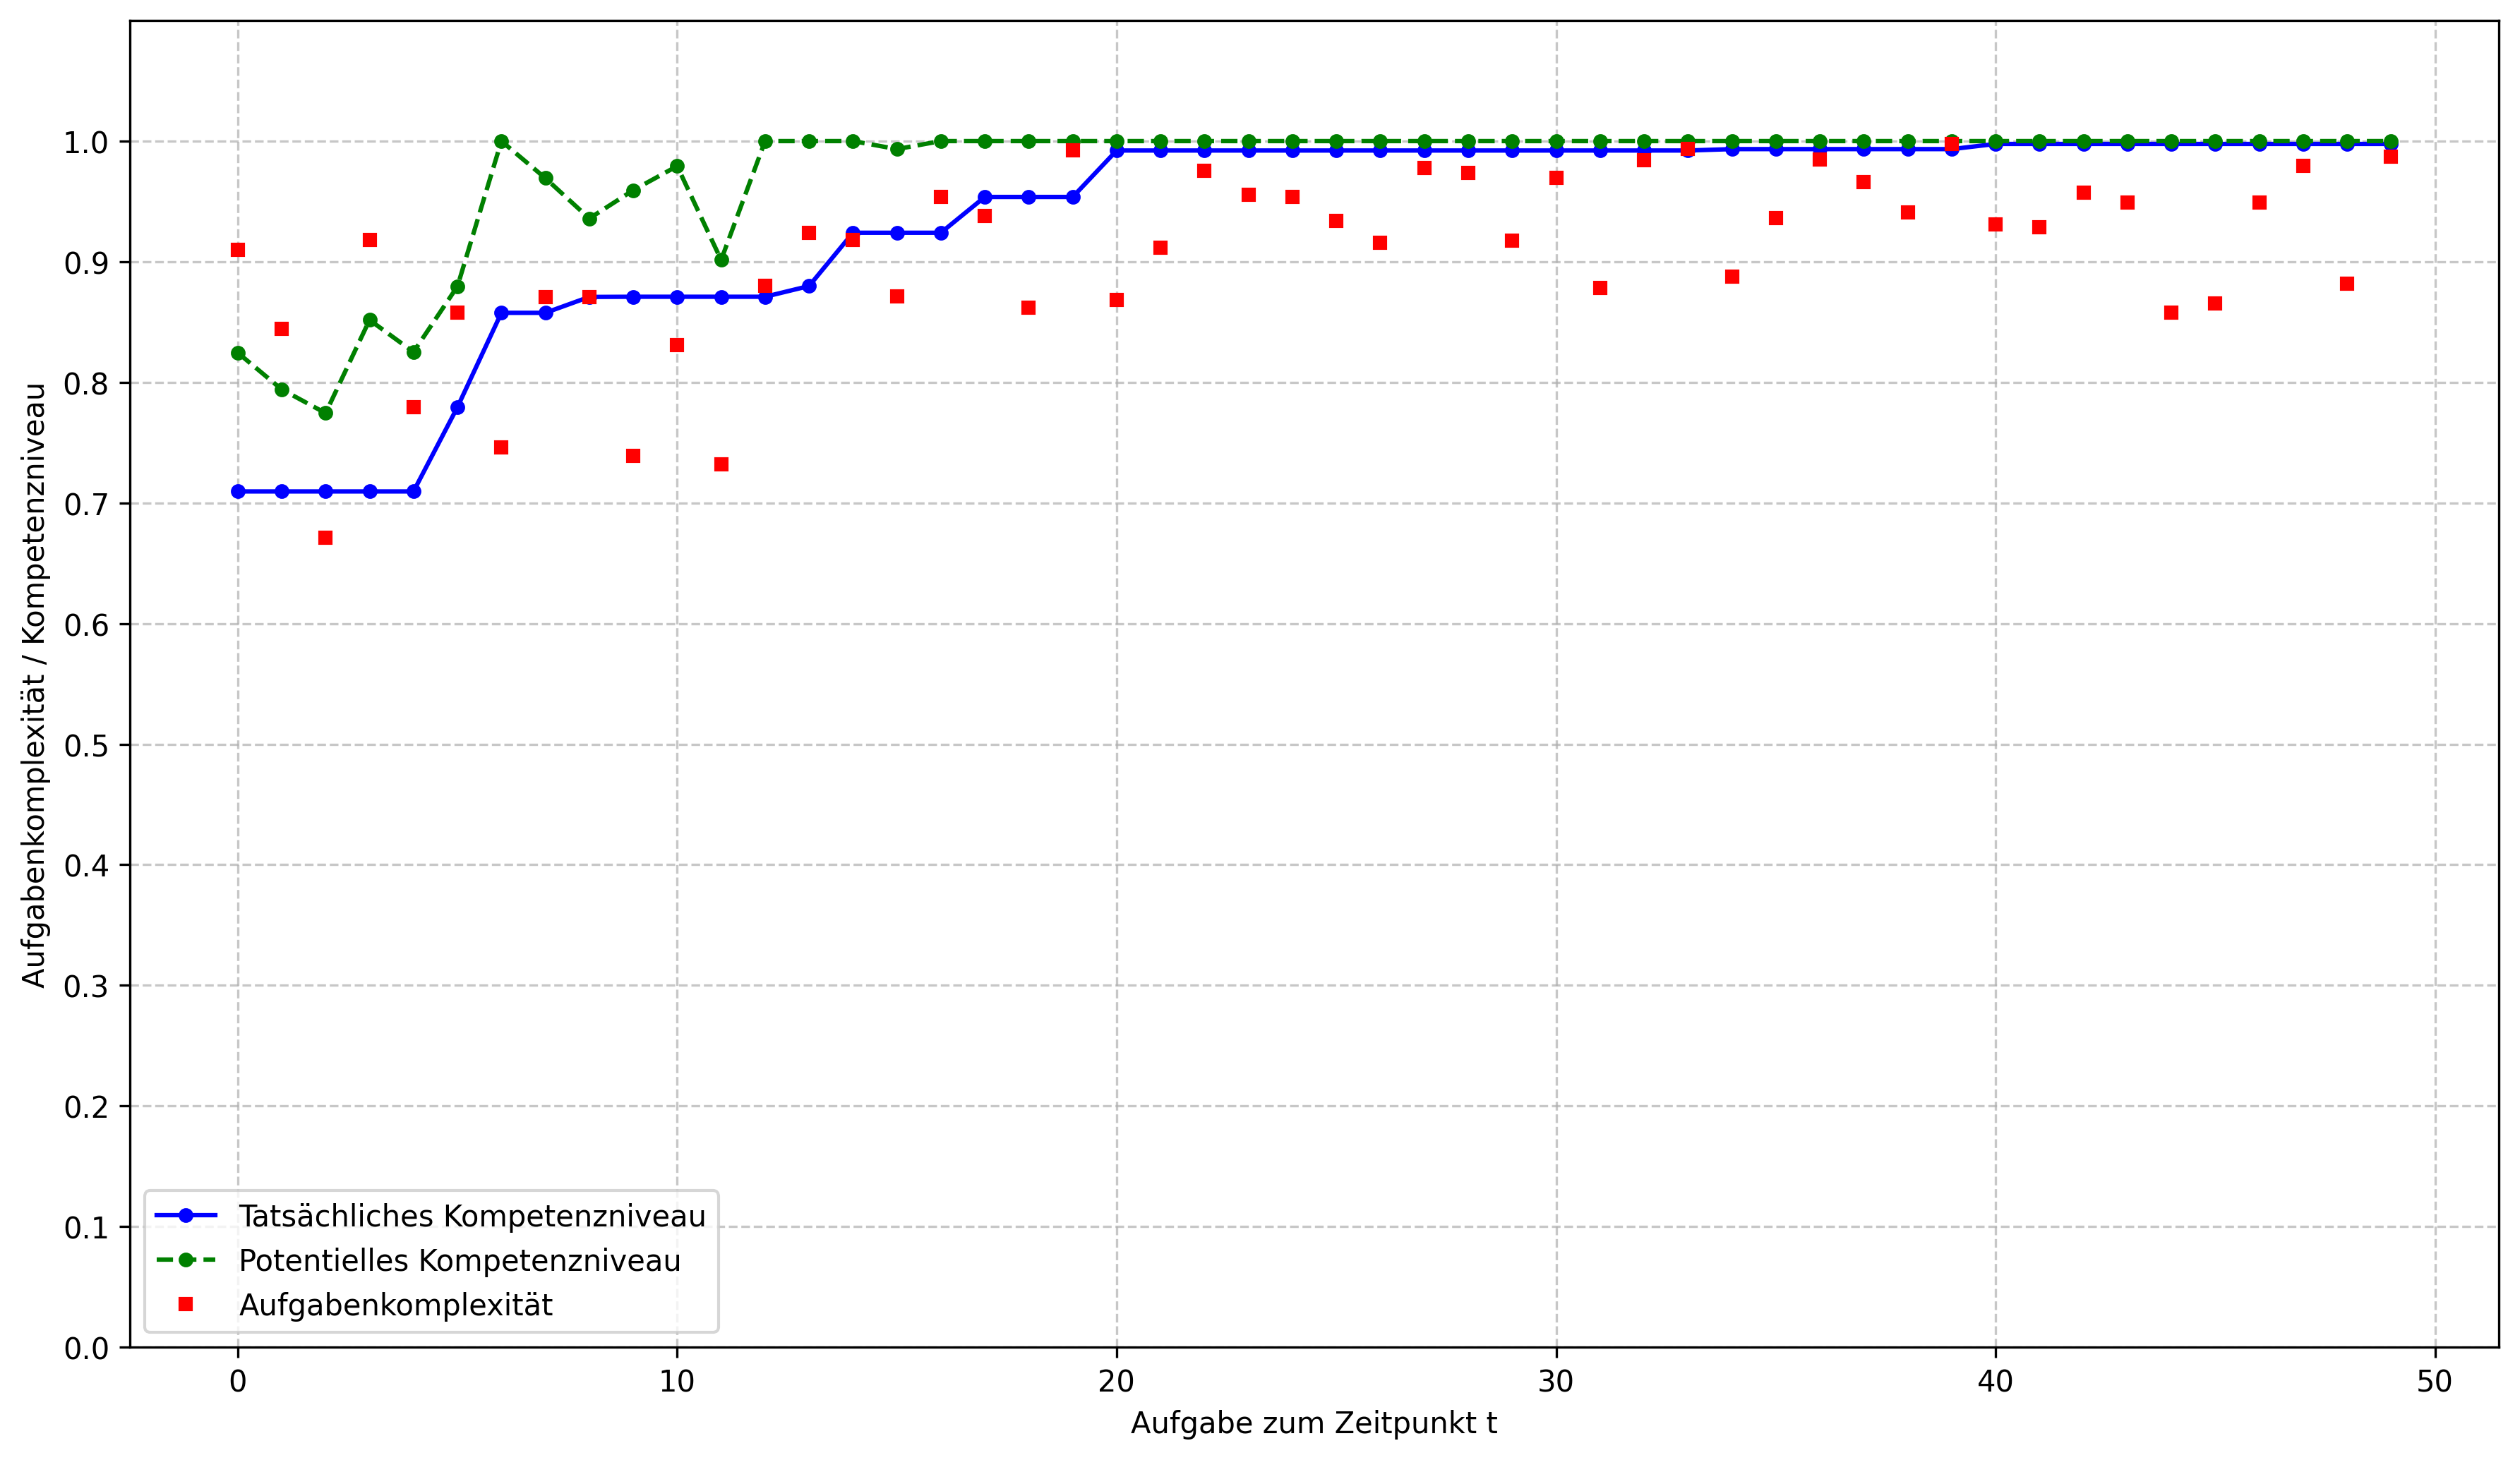

In [ ]:
plot_average_over_all_learners(log)

for i in range(10):
    plot_one_log_item(log, i)
    plot_one_element(log, i, 3)
# for e in log[8]:
#     print(e["real_task_complexity"][3])
#     print(e["potential_competency"][3])

In [395]:
c = 0.2123

f = calc_frequency(c)
print(f)
c = calc_complexity(f)
print(c)
f= calc_frequency(c)
print(f)

2
0.22048120921154243
2
